In [1]:
from collections import defaultdict
from functools import partial
import json
import multiprocessing as mp
from pathlib import Path
import random
import re
import sys
import time
from typing import Any

from google.cloud import storage
import numpy as np
import pandas as pd
from tqdm import tqdm
from rdkit import Chem
from rdkit.Chem import MACCSkeys
from rdkit import DataStructs
from rdkit.Chem import Descriptors, rdMolDescriptors
from rdkit import RDLogger
import vertexai
from vertexai.generative_models import GenerativeModel, GenerationConfig
from vertexai.tuning import sft

sys.path.insert(0, '../agenticadmet')
from eval import extract_preds, extract_refs, eval_admet
from utils import ECFP_from_smiles, tanimoto_similarity, standardize, standardize_cxsmiles

[21:04:25] Initializing Normalizer


In [2]:
logger = RDLogger.logger()
logger.setLevel(RDLogger.CRITICAL)

In [3]:
PROJECT_ID = "bioptic-io"
LOCATION = "us-central1"
vertexai.init(project=PROJECT_ID, location=LOCATION)

RANDOM_SEED = 42
SPLIT = 0

In [4]:
TARGET_COLUMNS = ["HLM", "MLM", "LogD", "KSOL", "MDR1-MDCKII"]
PROPERTIES = ['LogHLM', 'LogMLM', 'LogD', 'LogKSOL', 'LogMDR1-MDCKII']
PROPERTY = 'LogD'

In [5]:
data = pd.read_csv(f'../data/asap/datasets/rnd_splits/split_{SPLIT}.csv')
data

,smiles,HLM,KSOL,LogD,MLM,MDR1-MDCKII,smiles_std,cxsmiles_std,mol_idx,smiles_ext,LogHLM,LogMLM,LogKSOL,LogMDR1-MDCKII,split
0,COC1=CC=CC(Cl)=C1NC(=O)N1CCC[C@H](C(N)=O)C1 |a...,NaN,NaN,0.3,NaN,2.0,COc1cccc(Cl)c1NC(=O)N1CCC[C@H](C(N)=O)C1,COc1cccc(Cl)c1NC(=O)N1CCC[C@H](C(N)=O)C1 |a:16|,191,|a:16|,NaN,NaN,NaN,0.477121,val
1,O=C(NCC(F)F)[C@H](NC1=CC2=C(C=C1Br)CNC2)C1=CC(...,NaN,333.0,2.9,NaN,0.2,O=C(NCC(F)F)[C@H](Nc1cc2c(cc1Br)CNC2)c1cc(Cl)c...,O=C(NCC(F)F)[C@H](Nc1cc2c(cc1Br)CNC2)c1cc(Cl)c...,335,|&1:7|,NaN,NaN,2.523746,0.079181,train
2,O=C(NCC(F)F)[C@H](NC1=CC=C2CNCC2=C1)C1=CC(Br)=...,NaN,NaN,0.4,NaN,0.5,O=C(NCC(F)F)[C@H](Nc1ccc2c(c1)CNC2)c1cc(Br)cc2...,O=C(NCC(F)F)[C@H](Nc1ccc2c(c1)CNC2)c1cc(Br)cc2...,336,|&1:7|,NaN,NaN,NaN,0.176091,train
3,NC(=O)[C@H]1CCCN(C(=O)CC2=CC=CC3=C2C=CO3)C1 |&...,NaN,376.0,1.0,NaN,8.5,NC(=O)[C@H]1CCCN(C(=O)Cc2cccc3occc23)C1,NC(=O)[C@H]1CCCN(C(=O)Cc2cccc3occc23)C1 |&1:3|,300,|&1:3|,NaN,NaN,2.576341,0.977724,train
4,CC1=CC(CC(=O)N2CCC[C@H](C(N)=O)C2)=CC=N1 |&1:11|,NaN,375.0,-0.3,NaN,0.9,Cc1cc(CC(=O)N2CCC[C@H](C(N)=O)C2)ccn1,Cc1cc(CC(=O)N2CCC[C@H](C(N)=O)C2)ccn1 |&1:11|,249,|&1:11|,NaN,NaN,2.575188,0.278754,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399,CC(C)NC[C@H](O)COC1=CC=CC2=CC=CC=C12 |&1:5|,25.5,NaN,NaN,63.0,NaN,CC(C)NC[C@H](O)COc1cccc2ccccc12,CC(C)NC[C@H](O)COc1cccc2ccccc12 |&1:5|,22,|&1:5|,1.423246,1.806180,NaN,NaN,val
400,O=C(O)CC1=CC=CC=C1NC1=C(Cl)C=CC=C1Cl,216.0,NaN,NaN,386.0,NaN,O=C(O)Cc1ccccc1Nc1c(Cl)cccc1Cl,O=C(O)Cc1ccccc1Nc1c(Cl)cccc1Cl,380,NaN,2.336460,2.587711,NaN,NaN,val
401,NCC1=CC(Cl)=CC(C(=O)NC2=CC=C3CNCC3=C2)=C1,NaN,NaN,2.0,NaN,NaN,NCc1cc(Cl)cc(C(=O)Nc2ccc3c(c2)CNC3)c1,NCc1cc(Cl)cc(C(=O)Nc2ccc3c(c2)CNC3)c1,303,NaN,NaN,NaN,NaN,NaN,train
402,COC(=O)NC1=NC2=CC=C(C(=O)C3=CC=CC=C3)C=C2N1,NaN,NaN,2.9,NaN,NaN,COC(=O)Nc1nc2ccc(C(=O)c3ccccc3)cc2[nH]1,COC(=O)Nc1nc2ccc(C(=O)c3ccccc3)cc2[nH]1,166,NaN,NaN,NaN,NaN,NaN,train


In [6]:
def save_and_upload_training_data(data, path, gs_uri):
    with open(path, 'w') as f:
        for item in data:
            f.write(json.dumps(item) + '\n')

    storage_client = storage.Client()
    bucket_name, key = gs_uri[5:].split("/", 1)
    bucket = storage_client.bucket(bucket_name)
    blob = bucket.blob(key)
    blob.upload_from_filename(path)

In [7]:
def start_finetuning_sft(
        train_dataset_gs_uri: str, val_dataset_gs_uri: str | None = None, source_model: str = "gemini-1.5-pro-002",
        adapter_size: int = 4, epochs: int = 10, tuned_model_display_name: str | None = None
    ):
    sft_tuning_job = sft.train(
        source_model=source_model,
        train_dataset=train_dataset_gs_uri,
        validation_dataset=val_dataset_gs_uri,
        adapter_size=adapter_size,
        epochs=epochs,
        tuned_model_display_name=tuned_model_display_name
    )

In [8]:
def get_single_property_answer(model, content):
    result = model.generate_content(content['contents'])
    answer = result.candidates[0].content.parts[0].text
    try:
        answer = float(re.search(r'(-?\d+\.\d+)', answer.strip()).group(1))
    except Exception as e:
        print(answer)
        return None
    
    return answer

In [9]:
def get_answer(model, content):
    result = model.generate_content(content['contents'])
    candidate_properties = defaultdict(list)
    for candidate in result.candidates:
        answer = candidate.content.parts[0].text
        try:
            # Extract all property=value pairs from the answer
            matches = re.findall(r'(\w+(?:-\w+)*?)=(-?\d+\.\d+)', answer.strip())
            if not matches:
                print(answer)
                return None
                
            # Convert to dictionary
            for prop, val in matches:
                candidate_properties[prop].append(float(val))
            
        except Exception as e:
            print(answer)
            return None

    answer = {
        prop: np.mean(candidate_properties[prop]) for prop in PROPERTIES
    }
    # reorder to match PROPERTIES
    answer = {prop: answer[prop] for prop in PROPERTIES if prop in answer}

    return answer

## Hypothesis 1 - top-k closest molecules from train with given properties

In [163]:
SPLIT = 1
TOPK = 5
# PROPERTY = 'LogD'
# TARGET_COLUMN = 'LogD'
# PROPERTY = 'LogKSOL'
# TARGET_COLUMN = 'KSOL'
# PROPERTY = 'LogMLM'
# TARGET_COLUMN = 'MLM'
PROPERTY = 'LogMDR1-MDCKII'
TARGET_COLUMN = 'MDR1-MDCKII'

In [164]:
data = pd.read_csv(f'../data/asap/datasets/rnd_splits/split_{SPLIT}.csv')
data

,smiles,HLM,KSOL,LogD,MLM,MDR1-MDCKII,smiles_std,cxsmiles_std,mol_idx,smiles_ext,LogHLM,LogMLM,LogKSOL,LogMDR1-MDCKII,split
0,COC1=CC=CC(Cl)=C1NC(=O)N1CCC[C@H](C(N)=O)C1 |a...,NaN,NaN,0.3,NaN,2.0,COc1cccc(Cl)c1NC(=O)N1CCC[C@H](C(N)=O)C1,COc1cccc(Cl)c1NC(=O)N1CCC[C@H](C(N)=O)C1 |a:16|,191,|a:16|,NaN,NaN,NaN,0.477121,train
1,O=C(NCC(F)F)[C@H](NC1=CC2=C(C=C1Br)CNC2)C1=CC(...,NaN,333.0,2.9,NaN,0.2,O=C(NCC(F)F)[C@H](Nc1cc2c(cc1Br)CNC2)c1cc(Cl)c...,O=C(NCC(F)F)[C@H](Nc1cc2c(cc1Br)CNC2)c1cc(Cl)c...,335,|&1:7|,NaN,NaN,2.523746,0.079181,train
2,O=C(NCC(F)F)[C@H](NC1=CC=C2CNCC2=C1)C1=CC(Br)=...,NaN,NaN,0.4,NaN,0.5,O=C(NCC(F)F)[C@H](Nc1ccc2c(c1)CNC2)c1cc(Br)cc2...,O=C(NCC(F)F)[C@H](Nc1ccc2c(c1)CNC2)c1cc(Br)cc2...,336,|&1:7|,NaN,NaN,NaN,0.176091,train
3,NC(=O)[C@H]1CCCN(C(=O)CC2=CC=CC3=C2C=CO3)C1 |&...,NaN,376.0,1.0,NaN,8.5,NC(=O)[C@H]1CCCN(C(=O)Cc2cccc3occc23)C1,NC(=O)[C@H]1CCCN(C(=O)Cc2cccc3occc23)C1 |&1:3|,300,|&1:3|,NaN,NaN,2.576341,0.977724,val
4,CC1=CC(CC(=O)N2CCC[C@H](C(N)=O)C2)=CC=N1 |&1:11|,NaN,375.0,-0.3,NaN,0.9,Cc1cc(CC(=O)N2CCC[C@H](C(N)=O)C2)ccn1,Cc1cc(CC(=O)N2CCC[C@H](C(N)=O)C2)ccn1 |&1:11|,249,|&1:11|,NaN,NaN,2.575188,0.278754,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399,CC(C)NC[C@H](O)COC1=CC=CC2=CC=CC=C12 |&1:5|,25.5,NaN,NaN,63.0,NaN,CC(C)NC[C@H](O)COc1cccc2ccccc12,CC(C)NC[C@H](O)COc1cccc2ccccc12 |&1:5|,22,|&1:5|,1.423246,1.806180,NaN,NaN,train
400,O=C(O)CC1=CC=CC=C1NC1=C(Cl)C=CC=C1Cl,216.0,NaN,NaN,386.0,NaN,O=C(O)Cc1ccccc1Nc1c(Cl)cccc1Cl,O=C(O)Cc1ccccc1Nc1c(Cl)cccc1Cl,380,NaN,2.336460,2.587711,NaN,NaN,train
401,NCC1=CC(Cl)=CC(C(=O)NC2=CC=C3CNCC3=C2)=C1,NaN,NaN,2.0,NaN,NaN,NCc1cc(Cl)cc(C(=O)Nc2ccc3c(c2)CNC3)c1,NCc1cc(Cl)cc(C(=O)Nc2ccc3c(c2)CNC3)c1,303,NaN,NaN,NaN,NaN,NaN,train
402,COC(=O)NC1=NC2=CC=C(C(=O)C3=CC=CC=C3)C=C2N1,NaN,NaN,2.9,NaN,NaN,COC(=O)Nc1nc2ccc(C(=O)c3ccccc3)cc2[nH]1,COC(=O)Nc1nc2ccc(C(=O)c3ccccc3)cc2[nH]1,166,NaN,NaN,NaN,NaN,NaN,train


In [165]:
train = data[data['split'] == 'train'].reset_index(drop=True)
val = data[data['split'] == 'val'].reset_index(drop=True)
ref_data = data[(data['split'] == 'train') & ~data[PROPERTY].isna()].reset_index(drop=True)
train_ecfp = np.array(train['smiles_std'].apply(partial(ECFP_from_smiles, use_chirality=True)).tolist())
val_ecfp = np.array(val['smiles_std'].apply(partial(ECFP_from_smiles, use_chirality=True)).tolist())
ref_ecfp = np.array(ref_data['smiles_std'].apply(partial(ECFP_from_smiles, use_chirality=True)).tolist())
train2ref_dist = tanimoto_similarity(train_ecfp, ref_ecfp)
val2ref_dist = tanimoto_similarity(val_ecfp, ref_ecfp)
train2ref_dist.shape, val2ref_dist.shape

((323, 311), (81, 311))

In [166]:
ref_data

,smiles,HLM,KSOL,LogD,MLM,MDR1-MDCKII,smiles_std,cxsmiles_std,mol_idx,smiles_ext,LogHLM,LogMLM,LogKSOL,LogMDR1-MDCKII,split
0,COC1=CC=CC(Cl)=C1NC(=O)N1CCC[C@H](C(N)=O)C1 |a...,NaN,NaN,0.30,NaN,2.0,COc1cccc(Cl)c1NC(=O)N1CCC[C@H](C(N)=O)C1,COc1cccc(Cl)c1NC(=O)N1CCC[C@H](C(N)=O)C1 |a:16|,191,|a:16|,NaN,NaN,NaN,0.477121,train
1,O=C(NCC(F)F)[C@H](NC1=CC2=C(C=C1Br)CNC2)C1=CC(...,NaN,333.0,2.90,NaN,0.2,O=C(NCC(F)F)[C@H](Nc1cc2c(cc1Br)CNC2)c1cc(Cl)c...,O=C(NCC(F)F)[C@H](Nc1cc2c(cc1Br)CNC2)c1cc(Cl)c...,335,|&1:7|,NaN,NaN,2.523746,0.079181,train
2,O=C(NCC(F)F)[C@H](NC1=CC=C2CNCC2=C1)C1=CC(Br)=...,NaN,NaN,0.40,NaN,0.5,O=C(NCC(F)F)[C@H](Nc1ccc2c(c1)CNC2)c1cc(Br)cc2...,O=C(NCC(F)F)[C@H](Nc1ccc2c(c1)CNC2)c1cc(Br)cc2...,336,|&1:7|,NaN,NaN,NaN,0.176091,train
3,CC1=CC(CC(=O)N2CCC[C@H](C(N)=O)C2)=CC=N1 |&1:11|,NaN,375.0,-0.30,NaN,0.9,Cc1cc(CC(=O)N2CCC[C@H](C(N)=O)C2)ccn1,Cc1cc(CC(=O)N2CCC[C@H](C(N)=O)C2)ccn1 |&1:11|,249,|&1:11|,NaN,NaN,2.575188,0.278754,train
4,O=C(NCC(F)F)[C@H](NC1=CN=C2CNCC2=C1)C1=CC(Cl)=...,NaN,362.0,1.50,NaN,0.8,O=C(NCC(F)F)[C@H](Nc1cnc2c(c1)CNC2)c1cc(Cl)cc(...,O=C(NCC(F)F)[C@H](Nc1cnc2c(c1)CNC2)c1cc(Cl)cc(...,341,|&1:7|,NaN,NaN,2.559907,0.255273,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306,COC1=CC=C2C(=C1)CCN(C1=NC=NC3=C1C=CN3)[C@H]2C(...,60.0,14.0,4.33,321.0,7.0,COc1ccc2c(c1)CCN(c1ncnc3[nH]ccc13)[C@H]2C(C)C,COc1ccc2c(c1)CCN(c1ncnc3[nH]ccc13)[C@H]2C(C)C ...,189,|&1:20|,1.785330,2.507856,1.176091,0.903090,train
307,CC(C)[C@H](NC1=NC=NC2=C1C=CN2)C1=CC=C2OCCOC2=C...,50.0,224.0,3.20,340.0,26.8,CC(C)[C@H](Nc1ncnc2[nH]ccc12)c1ccc2c(c1)OCCO2,CC(C)[C@H](Nc1ncnc2[nH]ccc12)c1ccc2c(c1)OCCO2 ...,60,|&1:3|,1.707570,2.532754,2.352183,1.444045,train
308,CNC(=O)CN1C[C@@]2(C(=O)N(C3=CN=CC4=CC=CC=C34)C...,1.0,NaN,1.07,23.0,1.7,CNC(=O)CN1C[C@@]2(C(=O)N(c3cncc4ccccc34)C[C@@H...,CNC(=O)CN1C[C@@]2(C(=O)N(c3cncc4ccccc34)C[C@@H...,112,NaN,0.301030,1.380211,NaN,0.431364,train
309,C=CC(=O)NC1=CC=CC(N(CC2=CC=CC(Cl)=C2)C(=O)CC2=...,1070.0,24.7,3.80,2380.0,8.0,C=CC(=O)Nc1cccc(N(Cc2cccc(Cl)c2)C(=O)Cc2cncc3c...,C=CC(=O)Nc1cccc(N(Cc2cccc(Cl)c2)C(=O)Cc2cncc3c...,6,NaN,3.029789,3.376759,1.409933,0.954243,train


In [167]:
def get_all_topk_smiles_with_properties(ref_data, query_data, query2ref_dist, topk=TOPK, property=PROPERTY):
    for i in range(query2ref_dist.shape[0]):
        query_smiles = query_data.iloc[i]['cxsmiles_std']
        query_property = query_data.iloc[i][property]
        if np.isnan(query_property):
            continue

        dist = query2ref_dist[i]
        order = np.argsort(dist)[::-1]
        ordered_dist = dist[order]
        order = order[~np.isclose(ordered_dist, 1.0)]  # remove self-similarity including duplicates
        topk_idx = order[:topk]
        topk_dist = ordered_dist[:topk]
        topk_smiles = ref_data.iloc[topk_idx]['cxsmiles_std'].tolist()
        topk_properties = ref_data.iloc[topk_idx][property].tolist()
        yield topk_smiles, topk_properties, topk_dist, query_smiles, query_property

In [168]:
def format_data(
    input_smiles: list[str],
    input_properties: list[float],
    query_smiles: str,
    query_property: float | None = None,
    system_instruction: str | None = None
):
    if system_instruction is not None:
        output = {
            "systemInstruction": {
            "role": "Ignored",
            "parts": [
            {
                "text": system_instruction
            }
            ]
        }
    }
    else:
        output = {}
    
    output.update({
        "contents": [
            {
            "role": "user",
            "parts": [{
                "text": "; ".join([
                    f"{smi}, {PROPERTY}={prop:.2f}" 
                    for smi, prop in zip(input_smiles, input_properties)
                ]) + f"; Determine {PROPERTY} of {query_smiles}"
            }]
            }
        ]
    })

    if query_property is not None:
        output['contents'].append({
            "role": "model",
            "parts": [
                {
                    "text": f"{PROPERTY}={query_property:.2f}"
                }
            ]
        })
    
    return output

In [169]:
SYSTEM_INSTRUCTIONS = {
    f"{PROPERTY}": \
        f"You are an experienced medicinal chemist who worked determining the {PROPERTY} of molecules for years. "
        f"You can determine the {PROPERTY} of a molecule based on its structure and properties of similar molecules from a reference set. "
        f"You are given a list of {TOPK} reference molecules represented in SMILES paired with their {PROPERTY} values. "
        f"Some values might be incorrect due to assay errors. If you see extended notation like |&1:3|, "
        f"it means that the molecule has mixed stereochemistry. If you see notation like |o1:4|, it means "
        f"that the molecule has undefined stereochemistry (either R or S isomer). Take these compounds with care. "
        f"If a molecule doesn't have a notation or notation is like |a:16|, it means there's absolute (known) stereochemistry of the compound. "
        f"Your task is to determine the {PROPERTY} the molecule represented in SMILES. "
        f"Answer only with a single floating point number."
}

In [170]:
train_dataset = [
    format_data(
        input_smiles=input_smiles,
        input_properties=input_properties,
        query_smiles=query_smiles,
        query_property=query_property,
        system_instruction=SYSTEM_INSTRUCTIONS[PROPERTY]
    )
    for input_smiles, input_properties, topk_dist, query_smiles, query_property in get_all_topk_smiles_with_properties(
        ref_data=ref_data,
        query_data=train,
        query2ref_dist=train2ref_dist,
        topk=TOPK,
        property=PROPERTY
    )
]

In [171]:
val_dataset = [
    format_data(
        input_smiles=input_smiles,
        input_properties=input_properties,
        query_smiles=query_smiles,
        query_property=query_property,
        system_instruction=SYSTEM_INSTRUCTIONS[PROPERTY]
    )
    for input_smiles, input_properties, topk_dist, query_smiles, query_property in get_all_topk_smiles_with_properties(
        ref_data=ref_data,
        query_data=val,
        query2ref_dist=val2ref_dist,
        topk=TOPK,
        property=PROPERTY
    )
]

In [172]:
train_dataset[0]

{'systemInstruction': {'role': 'Ignored',
  'parts': [{'text': "You are an experienced medicinal chemist who worked determining the LogMDR1-MDCKII of molecules for years. You can determine the LogMDR1-MDCKII of a molecule based on its structure and properties of similar molecules from a reference set. You are given a list of 5 reference molecules represented in SMILES paired with their LogMDR1-MDCKII values. Some values might be incorrect due to assay errors. If you see extended notation like |&1:3|, it means that the molecule has mixed stereochemistry. If you see notation like |o1:4|, it means that the molecule has undefined stereochemistry (either R or S isomer). Take these compounds with care. If a molecule doesn't have a notation or notation is like |a:16|, it means there's absolute (known) stereochemistry of the compound. Your task is to determine the LogMDR1-MDCKII the molecule represented in SMILES. Answer only with a single floating point number."}]},
 'contents': [{'role': 'us

In [173]:
val_dataset[0]

{'systemInstruction': {'role': 'Ignored',
  'parts': [{'text': "You are an experienced medicinal chemist who worked determining the LogMDR1-MDCKII of molecules for years. You can determine the LogMDR1-MDCKII of a molecule based on its structure and properties of similar molecules from a reference set. You are given a list of 5 reference molecules represented in SMILES paired with their LogMDR1-MDCKII values. Some values might be incorrect due to assay errors. If you see extended notation like |&1:3|, it means that the molecule has mixed stereochemistry. If you see notation like |o1:4|, it means that the molecule has undefined stereochemistry (either R or S isomer). Take these compounds with care. If a molecule doesn't have a notation or notation is like |a:16|, it means there's absolute (known) stereochemistry of the compound. Your task is to determine the LogMDR1-MDCKII the molecule represented in SMILES. Answer only with a single floating point number."}]},
 'contents': [{'role': 'us

### Dry test - what if taking average property of top-k molecules does the job already?

In [185]:
val_tmp = val.copy()
pred_tmp = [
    (topk_properties @ np.array(topk_dist)) / np.sum(topk_dist)
    # np.mean(topk_properties)
    for topk_smiles, topk_properties, topk_dist, query_smiles, query_property in get_all_topk_smiles_with_properties(
        ref_data=ref_data,
        query_data=val,
        query2ref_dist=val2ref_dist,
        topk=10,
        property=PROPERTY
    )
]
val_tmp.loc[val_tmp[f'{PROPERTY}'].notna(), f'pred_{PROPERTY}'] = pred_tmp
val_preds = extract_preds(val_tmp, target_columns=[PROPERTY])
val_refs = extract_refs(val_tmp, target_columns=[PROPERTY])
metrics = eval_admet(val_preds, val_refs, target_columns=[TARGET_COLUMN])
print(json.dumps(metrics, indent=2))

{
  "MDR1-MDCKII": {
    "mean_absolute_error": 0.17151077148689525,
    "r2": 0.6004595404175248
  },
  "aggregated": {
    "macro_mean_absolute_error": 0.17151077148689525,
    "macro_r2": 0.6004595404175248
  }
}


In [288]:
data_dir = Path(f"../data/asap/datasets/rnd_splits/split_{SPLIT}/")
data_dir.mkdir(parents=True, exist_ok=True)
train_data_path = data_dir / f"gemini_{PROPERTY}_top{TOPK}_train.jsonl"
val_data_path = data_dir / f"gemini_{PROPERTY}_top{TOPK}_val.jsonl"
train_gs_uri = f"<gs_bucket>/data/asap/datasets/rnd_splits/split_{SPLIT}/gemini_{PROPERTY}_top{TOPK}_train.jsonl"
val_gs_uri = f"<gs_bucket>/data/asap/datasets/rnd_splits/split_{SPLIT}/gemini_{PROPERTY}_top{TOPK}_val.jsonl"

save_and_upload_training_data(train_dataset, train_data_path, train_gs_uri)
save_and_upload_training_data(val_dataset, val_data_path, val_gs_uri)

In [289]:
start_finetuning_sft(train_dataset_gs_uri=train_gs_uri, val_dataset_gs_uri=val_gs_uri, source_model="gemini-1.5-flash-002", epochs=30)

Creating SupervisedTuningJob
SupervisedTuningJob created. Resource name: projects/199759238457/locations/us-central1/tuningJobs/3552061391152087040
To use this SupervisedTuningJob in another session:
tuning_job = sft.SupervisedTuningJob('projects/199759238457/locations/us-central1/tuningJobs/3552061391152087040')
View Tuning Job:
https://console.cloud.google.com/vertex-ai/generative/language/locations/us-central1/tuning/tuningJob/3552061391152087040?project=199759238457


In [ ]:
TUNING_JOB_ID = "3552061391152087040"   # KSOL, gemini-1.5-flash-002, system instruction (improved, many years experience), text joined (improved), epochs=30, top-k=5, MAE=0.37
# TUNING_JOB_ID = "5571362874074333184"   # KSOL, gemini-1.5-flash-002, system instruction (improved, many years experience), text joined (improved), epochs=10, top-k=5, MAE=0.31
# TUNING_JOB_ID = "9217871197360881664"   # KSOL, gemini-1.5-flash-002, system instruction (improved, many years experience), text joined (improved), epochs=5, top-k=5, MAE=0.359
# TUNING_JOB_ID = "7133619363562651648"   # MDR1-MDCKII, gemini-1.5-flash-002, system instruction (improved, many years experience), text joined (improved), epochs=5, top-k=5, MAE=0.24
# TUNING_JOB_ID = "3523984262225199104"   # HLM, gemini-1.5-flash-002, system instruction (improved, many years experience), text joined (improved), epochs=5, top-k=5, MAE=0.316
# TUNING_JOB_ID = "5258433068716261376"   # HLM, gemini-1.5-flash-002, system instruction (improved, many years experience), text joined (improved), epochs=10, top-k=4, MAE=0.33
# TUNING_JOB_ID = "4019098746259243008"   # HLM, gemini-1.5-flash-002, system instruction (improved, many years experience), text joined (improved), epochs=10, top-k=5, MAE=0.36
# TUNING_JOB_ID = "3480566747067580416"   # cleaned, gemini-1.5-flash-002, system instruction (improved, many years experience), text joined (improved), epochs=10, top-k=5, MAE=0.44
# TUNING_JOB_ID = "8737257072673947648"   # gemini-1.5-flash-002, system instruction (improved, many years experience), text joined (improved), epochs=13, top-k=5, MAE=0.47
# TUNING_JOB_ID = "1716145253603344384"   # gemini-1.5-flash-002, system instruction (improved, many years experience), text joined (improved), epochs=7, top-k=5, MAE=0.51
# TUNING_JOB_ID = "7212929336297390080"   # gemini-1.5-flash-002, system instruction (improved, many years experience), text joined (improved), epochs=10, top-k=5, MAE=0.42
# TUNING_JOB_ID = "9165521249739210752"   # gemini-1.5-flash-002, system instruction (improved, removed abs stereo), text joined (improved), epochs=10, top-k=5, MAE=0.42
# TUNING_JOB_ID = "1809806052103815168"   # repeat 2, gemini-1.5-flash-002, system instruction (improved), text joined (improved), epochs=10, top-k=5, MAE=0.412
# TUNING_JOB_ID = "7872777050451345408"   # repeat, gemini-1.5-flash-002, system instruction (improved), text joined (improved), epochs=10, top-k=5, MAE=0.411
# TUNING_JOB_ID = "2525033967925592064"   # gemini-1.5-flash-002, system instruction (improved), text joined (improved), epochs=10, top-k=5, MAE=0.42
# TUNING_JOB_ID = "4887734922434838528"   # gemini-1.5-flash-002, system instruction, text joined (improved), epochs=10, top-k=5, MAE=0.394
# TUNING_JOB_ID = "1340728003415506944"   # gemini-1.5-flash-002, system instruction, text joined, epochs=3, top-k=5, MAE=0.6
# TUNING_JOB_ID = "8767902660763320320"   # gemini-1.5-flash-002, system instruction, text joined, epochs=30, top-k=5, MAE=0.59
# TUNING_JOB_ID = "2000540533197373440"   # gemini-1.5-flash-002, system instruction, text joined, epochs=5, top-k=5, MAE=0.55
# TUNING_JOB_ID = "3566174722406219776"   # gemini-1.5-flash-002, system instruction, text joined, epochs=10, top-k=5, MAE=0.49
# TUNING_JOB_ID = "2562997905409441792"   # gemini-1.5-flash-002, no system instruction, text joined, epochs=10, top-k=5, MAE=0.55
# TUNING_JOB_ID = "268959253031550976"   # gemini-1.5-pro-002, no system instruction, epochs=16, top-k=5, MAE=0.49
# TUNING_JOB_ID = "578018777459851264"  # gemini-1.5-flash-002, system instruction, epochs=20, top-k=5, MAE=0.68
# TUNING_JOB_ID = "7043780467480330240"   # gemini-1.5-pro-002, system instruction, epochs=10, top-k=5, MAE=0.425
# TUNING_JOB_ID = "1396099408990306304"   # gemini-1.5-pro-002, no system instruction, epochs=10, top-k=5, MAE=0.54
# TUNING_JOB_ID = "5127894650220183552"   # gemini-1.5-flash-002, no system instruction, epochs=5, top-k=5, MAE=0.55
# TUNING_JOB_ID = "7338880592282386432"   # gemini-1.5-flash-002 epochs=30, top-k=5, MAE=0.68
# TUNING_JOB_ID = "6688814133569126400"   # gemini-1.5-flash-002 epochs=10, top-k=5, MAE=0.52
# TUNING_JOB_ID = "1077088204819005440"   # split 1, gemini-1.5-pro-002 epochs=10, top-k=5, MAE=0.43
# TUNING_JOB_ID = "3011225915100233728"   # gemini-1.5-pro-002 epochs=10, top-k=3
# TUNING_JOB_ID = "7484694525823156224"   # gemini-1.5-pro-002 epochs=10, top-k=5, MAE=0.35
# TUNING_JOB_ID = "8143205233837735936"   # gemini-1.5-pro-002 epochs=30, top-k=5, MAE=0.47
# TUNING_JOB_ID = "6480462177663713280"   # gemini-1.5-pro-002 epochs=10, top-k=50
# TUNING_JOB_ID = "4625981885791600640"   # gemini-1.5-pro-002 epochs=30
# TUNING_JOB_ID = "9170184278552608768"   # gemini-1.5-pro-002 epochs=10
# TUNING_JOB_ID = "4485736978645516288" # gemini-1.5-flash-001 epochs=10
sft_tuning_job = sft.SupervisedTuningJob(f"projects/{PROJECT_ID}/locations/{LOCATION}/tuningJobs/{TUNING_JOB_ID}")
tuned_model = GenerativeModel(
    sft_tuning_job.tuned_model_endpoint_name,
    generation_config=GenerationConfig(
        temperature=0.0
    ),
    system_instruction=SYSTEM_INSTRUCTIONS[PROPERTY]
)

In [424]:
val_dataset = [
    format_data(
        input_smiles=input_smiles,
        input_properties=input_properties,
        query_smiles=query_smiles,
        system_instruction=SYSTEM_INSTRUCTIONS[PROPERTY]
    )
    for input_smiles, input_properties, query_smiles, query_property in get_all_topk_smiles_with_properties(
        ref_data=ref_data,
        query_data=val,
        query2ref_dist=val2ref_dist,
        topk=TOPK,
        property=PROPERTY
    )
]

In [425]:
for content in val_dataset:
    result = tuned_model.generate_content(content['contents'])
    print(result)
    break

candidates {
  content {
    role: "model"
    parts {
      text: "LogKSOL=2.54\n\n"
    }
  }
  finish_reason: STOP
  avg_logprobs: -0.068184667163425028
}
usage_metadata {
  prompt_token_count: 508
  candidates_token_count: 9
  total_token_count: 517
  prompt_tokens_details {
    modality: TEXT
    token_count: 508
  }
  candidates_tokens_details {
    modality: TEXT
    token_count: 9
  }
}
create_time {
  seconds: 1741930820
  nanos: 522665000
}
response_id: "RMHTZ6nzH9aJmecPrt_GkAw"



In [426]:
predictions = list(tqdm(map(partial(get_single_property_answer, tuned_model), val_dataset), total=len(val_dataset)))
val_ = val.copy()
val_.loc[val_[PROPERTY].notna(), f'pred_{PROPERTY}'] = predictions
val_preds = extract_preds(val, target_columns=[PROPERTY])
val_refs = extract_refs(val, target_columns=[PROPERTY])
metrics = eval_admet(val_preds, val_refs, target_columns=[TARGET_COLUMN])
print(json.dumps(metrics, indent=2))

100%|██████████| 63/63 [00:48<00:00,  1.31it/s]

{
  "KSOL": {
    "mean_absolute_error": 0.3757438575725559,
    "r2": 0.2066959078786007
  },
  "aggregated": {
    "macro_mean_absolute_error": 0.3757438575725559,
    "macro_r2": 0.2066959078786007
  }
}


## Hypothesis 2 - top-k closest molecules from train with given properties (no fine-tune)

In [29]:
model = GenerativeModel(
    "gemini-1.5-pro-002",
    system_instruction=SYSTEM_INSTRUCTIONS[PROPERTY],
    generation_config=GenerationConfig(
        temperature=0.0
    )
)

In [32]:
predictions = list(tqdm(map(partial(get_single_property_answer, model), val_dataset), total=len(val_dataset)))
val.loc[val[PROPERTY].notna(), f'pred_{PROPERTY}'] = predictions
val_preds = extract_preds(val, target_columns=[PROPERTY])
val_refs = extract_refs(val, target_columns=[PROPERTY])
metrics = eval_admet(val_preds, val_refs, target_columns=[TARGET_COLUMN])
print(json.dumps(metrics, indent=2))

{
  "LogD": {
    "mean_absolute_error": 0.5304477611940297,
    "r2": 0.6273667699465235
  },
  "aggregated": {
    "macro_mean_absolute_error": 0.5304477611940297,
    "macro_r2": 0.6273667699465235
  }
}


## Hypothesis 3 - RDKit descriptors

In [9]:
train = data[data['split'] == 'train'].reset_index(drop=True)
val = data[data['split'] == 'val'].reset_index(drop=True)

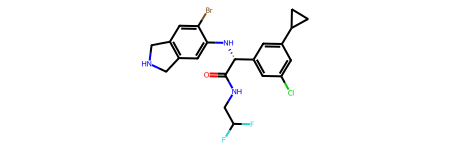

In [10]:
smiles = train.iloc[0]['smiles_std']
mol = Chem.MolFromSmiles(smiles)
mol

In [11]:
def extract_properties_v2(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return {"error": "Invalid SMILES string."}
    
    properties = {}

    # --- Basic RDKit Descriptors ---
    properties["molecular_weight"] = Descriptors.MolWt(mol)
    properties["num_rotatable_bonds"] = Descriptors.NumRotatableBonds(mol)
    properties["TPSA"] = rdMolDescriptors.CalcTPSA(mol)
    properties["H_bond_donors"] = Descriptors.NumHDonors(mol)
    properties["H_bond_acceptors"] = Descriptors.NumHAcceptors(mol)
    properties["Wildman_Crippen_LogP"] = Descriptors.MolLogP(mol)
    
    # --- Ring Counts ---
    properties["num_aromatic_rings"] = rdMolDescriptors.CalcNumAromaticRings(mol)
    properties["num_aliphatic_rings"] = rdMolDescriptors.CalcNumAliphaticRings(mol)
    
    # --- Functional Groups via SMARTS ---
    carboxylic_acid_smarts = Chem.MolFromSmarts('C(=O)[OH]')
    properties["carboxylic_acids"] = len(mol.GetSubstructMatches(carboxylic_acid_smarts))
    
    boronic_acid_smarts = Chem.MolFromSmarts('B(O)O')
    properties["boronic_acids"] = len(mol.GetSubstructMatches(boronic_acid_smarts))
    
    amide_smarts = Chem.MolFromSmarts('C(=O)N')
    properties["amide_groups"] = len(mol.GetSubstructMatches(amide_smarts))
    
    quaternary_ammonium_smarts = Chem.MolFromSmarts('[N+](C)(C)(C)C')
    properties["quaternary_amines"] = len(mol.GetSubstructMatches(quaternary_ammonium_smarts))
    
    sulfonic_acid_smarts = Chem.MolFromSmarts('S(=O)(=O)[OH]')
    properties["sulfonic_acids"] = len(mol.GetSubstructMatches(sulfonic_acid_smarts))
    
    amine_smarts = Chem.MolFromSmarts('[NX3;H2,H1]')
    properties["primary_secondary_amines"] = len(mol.GetSubstructMatches(amine_smarts))
    
    hydroxyl_smarts = Chem.MolFromSmarts('[OX2H]')
    properties["hydroxyl_groups"] = len(mol.GetSubstructMatches(hydroxyl_smarts))
    
    ether_smarts = Chem.MolFromSmarts('[OX2]C')
    properties["ethers"] = len(mol.GetSubstructMatches(ether_smarts))
    
    halogen_smarts = Chem.MolFromSmarts('[F,Cl,Br,I]')
    properties["halogens"] = len(mol.GetSubstructMatches(halogen_smarts))
    
    trifluoromethyl_smarts = Chem.MolFromSmarts('[CX3](F)(F)F')
    properties["trifluoromethyl"] = len(mol.GetSubstructMatches(trifluoromethyl_smarts))
    
    thioether_smarts = Chem.MolFromSmarts('[#6][S][#6]')
    properties["thioethers"] = len(mol.GetSubstructMatches(thioether_smarts))
    
    sulfone_smarts = Chem.MolFromSmarts('S(=O)(=O)')
    properties["sulfones_sulfoxides"] = len(mol.GetSubstructMatches(sulfone_smarts))
    
    carbonyl_smarts = Chem.MolFromSmarts('[CX3]=O')
    properties["carbonyls"] = len(mol.GetSubstructMatches(carbonyl_smarts))
    
    ester_smarts = Chem.MolFromSmarts('C(=O)O')
    properties["esters"] = len(mol.GetSubstructMatches(ester_smarts))

    properties["LogP"] = Descriptors.MolLogP(mol)
    
    # --- Additional Descriptors for LogD Prediction ---
    properties["FractionCSP3"] = rdMolDescriptors.CalcFractionCSP3(mol)
    properties["MolMR"] = Descriptors.MolMR(mol)
    properties["Chi0"] = Descriptors.Chi0(mol)
    properties["Chi1"] = Descriptors.Chi1(mol)
    properties["Kappa1"] = Descriptors.Kappa1(mol)
    properties["Kappa2"] = Descriptors.Kappa2(mol)
    properties["Kappa3"] = Descriptors.Kappa3(mol)
    properties["BertzCT"] = Descriptors.BertzCT(mol)
    properties["Ipc"] = Descriptors.Ipc(mol)
    
    # --- Extended Connectivity Fingerprint (Morgan FP) ---
    ## fp = Chem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=1024)
    ## fp_array = np.zeros((1024,), dtype=int)
    ## DataStructs.ConvertToNumpyArray(fp, fp_array)
    ## properties["morgan_fp"] = fp_array.tolist()
    ## fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=1024)
    ## fp_array = np.zeros((1024,), dtype=int)
    ## DataStructs.ConvertToNumpyArray(fp, fp_array)
    ## properties["morgan_fp"] = fp_array.tolist()
    
    # generator = rdMolDescriptors.MorganGenerator(radius=2, fpSize=1024)
    # fp = generator.GetFingerprint(mol)
    # fp_array = np.zeros((1024,), dtype=int)
    # DataStructs.ConvertToNumpyArray(fp, fp_array)
    # properties["morgan_fp"] = fp_array.tolist()

    return properties

In [ ]:
extract_properties_v2(smiles)

{'molecular_weight': 484.7720000000002,
 'num_rotatable_bonds': 7,
 'TPSA': 53.160000000000004,
 'H_bond_donors': 3,
 'H_bond_acceptors': 3,
 'Wildman_Crippen_LogP': 5.117600000000003,
 'num_aromatic_rings': 2,
 'num_aliphatic_rings': 2,
 'carboxylic_acids': 0,
 'boronic_acids': 0,
 'amide_groups': 1,
 'quaternary_amines': 0,
 'sulfonic_acids': 0,
 'primary_secondary_amines': 3,
 'hydroxyl_groups': 0,
 'ethers': 0,
 'halogens': 4,
 'trifluoromethyl': 0,
 'thioethers': 0,
 'sulfones_sulfoxides': 0,
 'carbonyls': 1,
 'esters': 0,
 'LogP': 5.117600000000003,
 'FractionCSP3': 0.38095238095238093,
 'MolMR': 113.4901,
 'Chi0': 20.543241116511002,
 'Chi1': 13.901887240964333,
 'Kappa1': 20.567849557232954,
 'Kappa2': 8.5780651111598,
 'Kappa3': 4.89949711170493,
 'BertzCT': 936.382492308937,
 'Ipc': 5535452.576047839}

In [13]:
def get_rdkit_descriptors(data) -> list[dict[str, Any]]:
    all_descriptors = []
    for i in range(data.shape[0]):
        smiles = data.iloc[i]['cxsmiles_std']
        descriptors = extract_properties_v2(smiles)
        all_descriptors.append(descriptors)
    
    return all_descriptors

In [14]:
SYSTEM_INSTRUCTIONS = {
    "LogD": \
        "You are an experienced medicinal chemist who worked many years with solubility testing of compounds. "
        "You can determine the LogD of a molecule based on its structure and calculated molecular properties. "
        "In SMILES, if you see extended notation like |&1:3|, "
        "it means that the molecule has mixed stereochemistry. If you see notation like |o1:4|, it means "
        "that the molecule has undefined stereochemistry (either R or S isomer). Take these compounds with care. "
        "If a molecule doesn't have a notation or notation is like |a:16|, it means there's absolute (known) stereochemistry of the compound. "
        "Your task is to determine the LogD of the molecule at pH 7.4 represented in SMILES and with given molecular properties. "
        "Answer only with a single floating point number."
}

In [15]:
def format_data(
    smiles: str,
    properties: dict[str, Any],
    system_instruction: str | None = None,
    answer: float | None = None
):
    if system_instruction is not None:
        output = {
            "systemInstruction": {
            "role": "Ignored",
            "parts": [
            {
                "text": system_instruction
            }
            ]
        }
    }
    else:
        output = {}
    
    output.update({
        "contents": [
            {
            "role": "user",
            "parts": [
                {
                    "text": f"{prop_name}: {prop_val:.2f}" if isinstance(prop_val, float) else f"{prop_name}: {prop_val}"
                }
                for prop_name, prop_val in properties.items()
            ] + [
                {
                    "text": f"Determine {PROPERTY} of {smiles}"
                }
            ]
            }
        ]
    })

    if answer is not None:
        output['contents'].append({
            "role": "model",
            "parts": [
                {
                    "text": f"{PROPERTY}: {answer:.2f}"
                }
            ]
        })
    
    return output

In [16]:
train_ = train[train[PROPERTY].notna()].reset_index(drop=True)
train_dataset = [
    format_data(
        smiles=smiles,
        properties=properties,
        system_instruction=SYSTEM_INSTRUCTIONS[PROPERTY],
        answer=answer
    )
    for smiles, properties, answer in zip(train_['cxsmiles_std'], get_rdkit_descriptors(train_), train_[PROPERTY])
]

In [17]:
train_dataset[0]

{'systemInstruction': {'role': 'Ignored',
  'parts': [{'text': "You are an experienced medicinal chemist who worked many years with solubility testing of compounds. You can determine the LogD of a molecule based on its structure and calculated molecular properties. In SMILES, if you see extended notation like |&1:3|, it means that the molecule has mixed stereochemistry. If you see notation like |o1:4|, it means that the molecule has undefined stereochemistry (either R or S isomer). Take these compounds with care. If a molecule doesn't have a notation or notation is like |a:16|, it means there's absolute (known) stereochemistry of the compound. Your task is to determine the LogD of the molecule at pH 7.4 represented in SMILES and with given molecular properties. Answer only with a single floating point number."}]},
 'contents': [{'role': 'user',
   'parts': [{'text': 'molecular_weight: 484.77'},
    {'text': 'num_rotatable_bonds: 7'},
    {'text': 'TPSA: 53.16'},
    {'text': 'H_bond_do

In [18]:
val_ = val[val[PROPERTY].notna()].reset_index(drop=True)
val_dataset = [
    format_data(
        smiles=smiles,
        properties=properties,
        system_instruction=SYSTEM_INSTRUCTIONS[PROPERTY]
    )
    for smiles, properties in zip(val_['cxsmiles_std'], get_rdkit_descriptors(val_))
]

In [19]:
val_dataset[0]

{'systemInstruction': {'role': 'Ignored',
  'parts': [{'text': "You are an experienced medicinal chemist who worked many years with solubility testing of compounds. You can determine the LogD of a molecule based on its structure and calculated molecular properties. In SMILES, if you see extended notation like |&1:3|, it means that the molecule has mixed stereochemistry. If you see notation like |o1:4|, it means that the molecule has undefined stereochemistry (either R or S isomer). Take these compounds with care. If a molecule doesn't have a notation or notation is like |a:16|, it means there's absolute (known) stereochemistry of the compound. Your task is to determine the LogD of the molecule at pH 7.4 represented in SMILES and with given molecular properties. Answer only with a single floating point number."}]},
 'contents': [{'role': 'user',
   'parts': [{'text': 'molecular_weight: 311.77'},
    {'text': 'num_rotatable_bonds: 3'},
    {'text': 'TPSA: 84.66'},
    {'text': 'H_bond_do

In [20]:
data_path = Path(f"../data/asap/datasets/rnd_splits/split_{SPLIT}/gemini_train_rdkit.jsonl")
data_path.parent.mkdir(parents=True, exist_ok=True)
gs_uri = f"<gs_bucket>/data/asap/datasets/rnd_splits/split_{SPLIT}/gemini_train_rdkit.jsonl"

save_and_upload_training_data(train_dataset, data_path, gs_uri)

In [21]:
start_finetuning_sft(train_dataset_gs_uri=gs_uri, source_model="gemini-1.5-flash-002", epochs=10)

Creating SupervisedTuningJob
SupervisedTuningJob created. Resource name: projects/199759238457/locations/us-central1/tuningJobs/5890872157013016576
To use this SupervisedTuningJob in another session:
tuning_job = sft.SupervisedTuningJob('projects/199759238457/locations/us-central1/tuningJobs/5890872157013016576')
View Tuning Job:
https://console.cloud.google.com/vertex-ai/generative/language/locations/us-central1/tuning/tuningJob/5890872157013016576?project=199759238457


In [ ]:
TUNING_JOB_ID = "5890872157013016576"  # gemini-1.5-flash-002, epochs=10, MAE=0.91
# TUNING_JOB_ID = "1349613156879564800"
# TUNING_JOB_ID = "6729936967959576576"
sft_tuning_job = sft.SupervisedTuningJob(f"projects/{PROJECT_ID}/locations/{LOCATION}/tuningJobs/{TUNING_JOB_ID}")
tuned_model = GenerativeModel(
    sft_tuning_job.tuned_model_endpoint_name,
    generation_config=GenerationConfig(
        temperature=0.,
        seed=RANDOM_SEED
    ),
    system_instruction=SYSTEM_INSTRUCTIONS[PROPERTY]
)

In [21]:
predictions = list(tqdm(map(partial(get_single_property_answer, tuned_model), val_dataset), total=len(val_dataset)))
val_ = val.copy()
val_.loc[val_[PROPERTY].notna(), f'pred_{PROPERTY}'] = predictions
val_preds = extract_preds(val_, target_columns=[PROPERTY])
val_refs = extract_refs(val_, target_columns=[PROPERTY])
metrics = eval_admet(val_preds, val_refs, target_columns=[TARGET_COLUMN])
print(json.dumps(metrics, indent=2))

100%|██████████| 61/61 [00:51<00:00,  1.18it/s]

{
  "LogD": {
    "mean_absolute_error": 0.9162295081967213,
    "r2": 0.223021321845691
  },
  "aggregated": {
    "macro_mean_absolute_error": 0.9162295081967213,
    "macro_r2": 0.223021321845691
  }
}


## Hypothesis 4 - RDKit descriptors (no fine-tune)

In [49]:
model = GenerativeModel(
    "gemini-1.5-pro-002",
    system_instruction=SYSTEM_INSTRUCTIONS[PROPERTY],
    generation_config=GenerationConfig(
        temperature=0.0
    )
)

In [52]:
predictions = list(tqdm(map(partial(get_single_property_answer, model), val_dataset), total=len(val_dataset)))
val_ = val.copy()
val_.loc[val_[PROPERTY].notna(), f'pred_{PROPERTY}'] = predictions
val_preds = extract_preds(val_, target_columns=[PROPERTY])
val_refs = extract_refs(val_, target_columns=[PROPERTY])
metrics = eval_admet(val_preds, val_refs, target_columns=[TARGET_COLUMN])
print(json.dumps(metrics, indent=2))

{
  "LogD": {
    "mean_absolute_error": 0.8692537313432835,
    "r2": 0.19464075871267517
  },
  "aggregated": {
    "macro_mean_absolute_error": 0.8692537313432835,
    "macro_r2": 0.19464075871267517
  }
}


## Hypothesis 5 - SMILES only

In [53]:
SYSTEM_INSTRUCTIONS = {
    "LogD": \
        "You are an experienced medicinal chemist who worked many years with solubility testing of compounds. "
        "You can determine the LogD of a molecule based on its structure. "
        "You are given a SMILES string of a molecule. Your task is to determine the LogD of the molecule at pH 7.4. "
        "Answer only with a single floating point number in the \"Answer: number\" format, e.g. \"Answer: 2.7\". "
        "Don't describe your solution and don't put any other text in your answer."
}

In [54]:
def format_data(
    smiles: str,
    system_instruction: str | None = None,
    answer: float | None = None
):
    if system_instruction is not None:
        output = {
            "systemInstruction": {
            "parts": [
            {
                "text": system_instruction
            }
            ]
        }
    }
    else:
        output = {}
    
    output.update({
        "contents": [
            {
            "role": "user",
            "parts": [
                {
                    "text": f"Determine {PROPERTY} of {smiles}"
                }
            ]
            }
        ]
    })

    if answer is not None:
        output['contents'].append({
            "role": "model",
            "parts": [
                {
                    "text": f"Answer: {answer:.2f}"
                }
            ]
        })
    
    return output

In [55]:
train_ = train[train[PROPERTY].notna()].reset_index(drop=True)
train_dataset = [
    format_data(
        smiles=smiles,
        system_instruction=SYSTEM_INSTRUCTIONS[PROPERTY],
        answer=answer
    )
    for smiles, answer in zip(train_['cxsmiles_std'], train_[PROPERTY])
]

In [56]:
train_dataset[0]

{'systemInstruction': {'parts': [{'text': 'You are an experienced medicinal chemist who worked many years with solubility testing of compounds. You can determine the LogD of a molecule based on its structure. You are given a SMILES string of a molecule. Your task is to determine the LogD of the molecule at pH 7.4. Answer only with a single floating point number in the "Answer: number" format, e.g. "Answer: 2.7". Don\'t describe your solution and don\'t put any other text in your answer.'}]},
 'contents': [{'role': 'user',
   'parts': [{'text': 'Determine LogD of O=C(NCC(F)F)[C@H](Nc1cc2c(cc1Br)CNC2)c1cc(Cl)cc(C2CC2)c1 |&1:7|'}]},
  {'role': 'model', 'parts': [{'text': 'Answer: 2.90'}]}]}

In [57]:
val_ = val[val[PROPERTY].notna()].reset_index(drop=True)
val_dataset = [
    format_data(
        smiles=smiles,
        system_instruction=SYSTEM_INSTRUCTIONS[PROPERTY]
    )
    for smiles in val_['cxsmiles_std']
]

In [58]:
val_dataset[0]

{'systemInstruction': {'parts': [{'text': 'You are an experienced medicinal chemist who worked many years with solubility testing of compounds. You can determine the LogD of a molecule based on its structure. You are given a SMILES string of a molecule. Your task is to determine the LogD of the molecule at pH 7.4. Answer only with a single floating point number in the "Answer: number" format, e.g. "Answer: 2.7". Don\'t describe your solution and don\'t put any other text in your answer.'}]},
 'contents': [{'role': 'user',
   'parts': [{'text': 'Determine LogD of COc1cccc(Cl)c1NC(=O)N1CCC[C@H](C(N)=O)C1 |a:16|'}]}]}

In [59]:
data_path = Path(f"../data/asap/datasets/rnd_splits/split_{SPLIT}/gemini_train_smiles.jsonl")
data_path.parent.mkdir(parents=True, exist_ok=True)
gs_uri = f"<gs_bucket>/data/asap/datasets/rnd_splits/split_{SPLIT}/gemini_train_smiles.jsonl"

save_and_upload_training_data(train_dataset, data_path, gs_uri)

In [60]:
start_finetuning_sft(train_dataset_gs_uri=gs_uri, epochs=30)

In [62]:
TUNING_JOB_ID = "2571337701106122752"
sft_tuning_job = sft.SupervisedTuningJob(f"projects/{PROJECT_ID}/locations/{LOCATION}/tuningJobs/{TUNING_JOB_ID}")
tuned_model = GenerativeModel(
    sft_tuning_job.tuned_model_endpoint_name,
    system_instruction=SYSTEM_INSTRUCTIONS[PROPERTY],
    generation_config=GenerationConfig(
        temperature=0.1,
        seed=RANDOM_SEED
    )
)

In [64]:
predictions = list(tqdm(map(partial(get_single_property_answer, tuned_model), val_dataset), total=len(val_dataset)))
val_ = val.copy()
val_.loc[val_[PROPERTY].notna(), f'pred_{PROPERTY}'] = predictions
val_preds = extract_preds(val_, target_columns=[PROPERTY])
val_refs = extract_refs(val_, target_columns=[PROPERTY])
metrics = eval_admet(val_preds, val_refs, target_columns=[TARGET_COLUMN])
print(json.dumps(metrics, indent=2))

{
  "LogD": {
    "mean_absolute_error": 0.5259701492537313,
    "r2": 0.6010311277217946
  },
  "aggregated": {
    "macro_mean_absolute_error": 0.5259701492537313,
    "macro_r2": 0.6010311277217946
  }
}


## Hypothesis 6 - top-k closest molecules from train with given properties (for all properties)

In [137]:
TOPK = 5

In [138]:
train = ref_data = data[data['split'] == 'train'].reset_index(drop=True)
val = data[data['split'] == 'val'].reset_index(drop=True)
train_ecfp = np.array(train['smiles_std'].apply(partial(ECFP_from_smiles, use_chirality=True)).tolist())
val_ecfp = np.array(val['smiles_std'].apply(partial(ECFP_from_smiles, use_chirality=True)).tolist())
ref_ecfp = np.array(ref_data['smiles_std'].apply(partial(ECFP_from_smiles, use_chirality=True)).tolist())
train2ref_dist = tanimoto_similarity(train_ecfp, ref_ecfp)
val2ref_dist = tanimoto_similarity(val_ecfp, ref_ecfp)
train2ref_dist.shape, val2ref_dist.shape

((323, 323), (81, 323))

In [139]:
ref_data

,smiles,HLM,KSOL,LogD,MLM,MDR1-MDCKII,smiles_std,cxsmiles_std,mol_idx,smiles_ext,LogHLM,LogMLM,LogKSOL,LogMDR1-MDCKII,split
0,O=C(NCC(F)F)[C@H](NC1=CC2=C(C=C1Br)CNC2)C1=CC(...,NaN,333.0,2.9,NaN,0.2,O=C(NCC(F)F)[C@H](Nc1cc2c(cc1Br)CNC2)c1cc(Cl)c...,O=C(NCC(F)F)[C@H](Nc1cc2c(cc1Br)CNC2)c1cc(Cl)c...,335,|&1:7|,NaN,NaN,2.523746,0.079181,train
1,O=C(NCC(F)F)[C@H](NC1=CC=C2CNCC2=C1)C1=CC(Br)=...,NaN,NaN,0.4,NaN,0.5,O=C(NCC(F)F)[C@H](Nc1ccc2c(c1)CNC2)c1cc(Br)cc2...,O=C(NCC(F)F)[C@H](Nc1ccc2c(c1)CNC2)c1cc(Br)cc2...,336,|&1:7|,NaN,NaN,NaN,0.176091,train
2,NC(=O)[C@H]1CCCN(C(=O)CC2=CC=CC3=C2C=CO3)C1 |&...,NaN,376.0,1.0,NaN,8.5,NC(=O)[C@H]1CCCN(C(=O)Cc2cccc3occc23)C1,NC(=O)[C@H]1CCCN(C(=O)Cc2cccc3occc23)C1 |&1:3|,300,|&1:3|,NaN,NaN,2.576341,0.977724,train
3,CC1=CC(CC(=O)N2CCC[C@H](C(N)=O)C2)=CC=N1 |&1:11|,NaN,375.0,-0.3,NaN,0.9,Cc1cc(CC(=O)N2CCC[C@H](C(N)=O)C2)ccn1,Cc1cc(CC(=O)N2CCC[C@H](C(N)=O)C2)ccn1 |&1:11|,249,|&1:11|,NaN,NaN,2.575188,0.278754,train
4,COC1=CC(Cl)=CC([C@H](NC2=CC=C3CNCC3=C2)C(=O)NC...,NaN,NaN,0.5,NaN,0.7,COc1cc(Cl)cc([C@H](Nc2ccc3c(c2)CNC3)C(=O)NCC(F...,COc1cc(Cl)cc([C@H](Nc2ccc3c(c2)CNC3)C(=O)NCC(F...,178,|&1:8|,NaN,NaN,NaN,0.230449,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318,C=CC(=O)N1CCCC2=CC=C(N(C(=O)CC3=CN=CC4=CC=CC=C...,1380.0,NaN,NaN,1760.0,NaN,C=CC(=O)N1CCCc2ccc(N(C(=O)Cc3cncc4ccccc34)N(C)...,C=CC(=O)N1CCCc2ccc(N(C(=O)Cc3cncc4ccccc34)N(C)...,3,NaN,3.140194,3.245759,NaN,NaN,train
319,CN(C)CCCN1C2=CC=CC=C2CCC2=CC=CC=C21,NaN,NaN,NaN,169.0,NaN,CN(C)CCCN1c2ccccc2CCc2ccccc21,CN(C)CCCN1c2ccccc2CCc2ccccc21,103,NaN,NaN,2.230449,NaN,NaN,train
320,NCC1=CC(Cl)=CC(C(=O)NC2=CC=C3CNCC3=C2)=C1,NaN,NaN,2.0,NaN,NaN,NCc1cc(Cl)cc(C(=O)Nc2ccc3c(c2)CNC3)c1,NCc1cc(Cl)cc(C(=O)Nc2ccc3c(c2)CNC3)c1,303,NaN,NaN,NaN,NaN,NaN,train
321,COC(=O)NC1=NC2=CC=C(C(=O)C3=CC=CC=C3)C=C2N1,NaN,NaN,2.9,NaN,NaN,COC(=O)Nc1nc2ccc(C(=O)c3ccccc3)cc2[nH]1,COC(=O)Nc1nc2ccc(C(=O)c3ccccc3)cc2[nH]1,166,NaN,NaN,NaN,NaN,NaN,train


In [140]:
def get_all_topk_smiles_with_properties(ref_data, query_data, query2ref_dist, topk=TOPK):
    for i in range(query2ref_dist.shape[0]):
        query_smiles = query_data.iloc[i]['cxsmiles_std']
        query_properties = {}
        topk_smiles2properties = defaultdict(dict)
        for property in PROPERTIES:
            query_property = query_data.iloc[i][property]
            if not np.isnan(query_property):
                query_properties[property] = query_property

            ref_data_with_property = ref_data[ref_data[property].notna()]
            dist = query2ref_dist[i, ref_data_with_property.index]
            order = np.argsort(dist)[::-1]
            ordered_dist = dist[order]
            order = order[~np.isclose(ordered_dist, 1.0)]  # remove self-similarity including duplicates
            topk_idx = order[:topk]
            topk_smiles = ref_data_with_property.iloc[topk_idx]['cxsmiles_std'].tolist()
            topk_properties = ref_data_with_property.iloc[topk_idx][property].tolist()

            for smi, prop in zip(topk_smiles, topk_properties):
                topk_smiles2properties[smi][property] = prop
        
        yield topk_smiles2properties, query_smiles, query_properties

In [141]:
system_instruction = \
"You are an experienced medicinal chemist who worked many years determining ADME properties of drug-like molecules. " \
"You can determine properties like LogD (solubility), LogHLM (human liver microsome stability), LogMLM (mouse liver microsome stability), " \
"LogKSOL (kinetic solubility), and LogMDR1-MDCKII (MDR1-MDCKII permeability) based on molecular structure and properties " \
"of similar molecules from a reference set. You are given a list of reference molecules represented in SMILES " \
"paired with their property values. Some values might be incorrect due to assay errors. If you see extended notation like |&1:3|, " \
"it means that the molecule has mixed stereochemistry. If you see notation like |o1:4|, it means " \
"that the molecule has undefined stereochemistry (either R or S isomer). Take these compounds with care. If a molecule " \
"doesn't have a notation or notation is like |a:16|, it means there's absolute (known) stereochemistry of the compound. " \
"Only pay attention to the relevant or correlating properties, and ignore the rest. " \
"Your task is to determine the requested properties of the molecule represented in SMILES. " \
"Answer only with a single floating point number per property."

In [142]:
def format_data(
    topk_smiles2properties: dict[str, dict[str, float]],
    query_smiles: str,
    query_properties: dict[str, float] | None = None,
    system_instruction: str | None = None
):
    if system_instruction is not None:
        output = {
            "systemInstruction": {
            "parts": [
            {
                "text": system_instruction
            }
            ]
        }
    }
    else:
        output = {}

    parts = [
        {
            "text": "; ".join([
                f"SMILES: {smi}, " + ", ".join([
                    f"{prop_name}={prop_val:.2f}"
                    for prop_name, prop_val in prop_name2prop_val.items()
                ])
                for smi, prop_name2prop_val in topk_smiles2properties.items()
            ])
        }
    ]
    if query_properties is not None:
        parts.append({
            "text": f"SMILES: {query_smiles}; " + "Determine " + ", ".join([
                f"{prop_name}" for prop_name in query_properties.keys()
            ])
        })
    else:
        parts.append({
            "text": f"SMILES: {query_smiles}; " + "Determine " +", ".join([
                f"{prop_name}" for prop_name in PROPERTIES
            ])
        })
    
    output.update({
        "contents": [
            {
            "role": "user",
            "parts": parts
            }
        ]
    })

    if query_properties is not None:
        output['contents'].append({
            "role": "model",
            "parts": [
                {
                    "text": ", ".join([
                        f"{prop_name}={prop_val:.2f}"
                        for prop_name, prop_val in query_properties.items()
                    ])
                }
            ]
        })
    
    return output

In [143]:
train_dataset = [
    format_data(
        topk_smiles2properties=topk_smiles2properties,
        query_smiles=query_smiles,
        query_properties=query_properties,
        system_instruction=system_instruction
    )
    for topk_smiles2properties, query_smiles, query_properties in get_all_topk_smiles_with_properties(
        ref_data=ref_data,
        query_data=train,
        query2ref_dist=train2ref_dist,
        topk=TOPK
    )
]

In [144]:
train_dataset[0]

{'systemInstruction': {'parts': [{'text': "You are an experienced medicinal chemist who worked many years determining ADME properties of drug-like molecules. You can determine properties like LogD (solubility), LogHLM (human liver microsome stability), LogMLM (mouse liver microsome stability), LogKSOL (kinetic solubility), and LogMDR1-MDCKII (MDR1-MDCKII permeability) based on molecular structure and properties of similar molecules from a reference set. You are given a list of reference molecules represented in SMILES paired with their property values. Some values might be incorrect due to assay errors. If you see extended notation like |&1:3|, it means that the molecule has mixed stereochemistry. If you see notation like |o1:4|, it means that the molecule has undefined stereochemistry (either R or S isomer). Take these compounds with care. If a molecule doesn't have a notation or notation is like |a:16|, it means there's absolute (known) stereochemistry of the compound. Only pay atten

In [145]:
val_dataset = [
    format_data(
        topk_smiles2properties=topk_smiles2properties,
        query_smiles=query_smiles
    )
    for topk_smiles2properties, query_smiles, query_properties in get_all_topk_smiles_with_properties(
        ref_data=ref_data,
        query_data=val,
        query2ref_dist=val2ref_dist,
        topk=TOPK
    )
]

In [146]:
val_dataset[0]

{'contents': [{'role': 'user',
   'parts': [{'text': 'SMILES: O=C(Nc1cccc(B(O)O)c1)[C@H]1CCN2CCC[C@H]2C1 |&1:12,&2:19|, LogHLM=1.00, LogMLM=0.85, LogD=0.30, LogKSOL=2.59, LogMDR1-MDCKII=0.63; SMILES: COc1ccccc1NC(=O)Nc1c[nH]c(=O)c2ccccc12, LogHLM=1.24, LogMLM=2.04, LogD=2.20; SMILES: O=C(O)c1cc(Cl)ccc1NS(=O)(=O)c1ccc(Oc2ccccc2Cl)cc1, LogHLM=2.19, LogMLM=1.15, LogD=3.00; SMILES: CN1CC[C@H](NC(=O)c2cccc(B(O)O)c2)[C@H]1c1ccc(Cl)cc1 |&1:4,17|, LogHLM=1.34, LogMLM=1.73; SMILES: O=C(O)c1cc(Cl)c(F)cc1S(=O)(=O)Nc1ccc(Oc2ccccc2Cl)cc1, LogHLM=1.84; SMILES: CNC(=O)c1cc(Cl)ccc1NS(=O)(=O)c1ccc(Oc2ccccc2Cl)cc1, LogMLM=1.98; SMILES: NC(=O)[C@H]1CCCN(C(=O)Cc2cccc3occc23)C1 |&1:3|, LogD=1.00, LogKSOL=2.58, LogMDR1-MDCKII=0.98; SMILES: Cc1cc(CC(=O)N2CCC[C@H](C(N)=O)C2)ccn1 |&1:11|, LogD=-0.30, LogKSOL=2.58, LogMDR1-MDCKII=0.28; SMILES: CNS(=O)(=O)[C@H]1CCCN(C(=O)Cc2cncc3ccccc23)C1 |&1:5|, LogKSOL=2.58, LogMDR1-MDCKII=0.69; SMILES: COc1ccccc1[C@@H]1C[C@H](C)CCN1C(=O)Cc1cncc2ccccc12 |&1:8,10|, LogKSOL=2.3

In [36]:
data_path = Path(f"../data/asap/datasets/rnd_splits/split_{SPLIT}/gemini_all_prop_top{TOPK}_train.jsonl")
data_path.parent.mkdir(parents=True, exist_ok=True)
gs_uri = f"<gs_bucket>/data/asap/datasets/rnd_splits/split_{SPLIT}/gemini_all_prop_top{TOPK}_train.jsonl"

save_and_upload_training_data(train_dataset, data_path, gs_uri)

In [37]:
start_finetuning_sft(train_dataset_gs_uri=gs_uri, source_model="gemini-1.5-flash-002", epochs=10)

Creating SupervisedTuningJob
SupervisedTuningJob created. Resource name: projects/199759238457/locations/us-central1/tuningJobs/3068364235860869120
To use this SupervisedTuningJob in another session:
tuning_job = sft.SupervisedTuningJob('projects/199759238457/locations/us-central1/tuningJobs/3068364235860869120')
View Tuning Job:
https://console.cloud.google.com/vertex-ai/generative/language/locations/us-central1/tuning/tuningJob/3068364235860869120?project=199759238457


In [ ]:
# TUNING_JOB_ID = "3068364235860869120"   # gemini-1.5-flash-002, 10 epochs, orig dist, system instruction (attention to relevant properties), aMAE=0.47
TUNING_JOB_ID = "8344612674302115840"   # gemini-1.5-flash-002, 10 epochs, system instruction (attention to relevant properties), aMAE=0.36.6
# TUNING_JOB_ID = "6066622493643243520"   # gemini-1.5-flash-002, 10 epochs, system instruction (must be good at this), aMAE=0.378
# TUNING_JOB_ID = "1383582568619704320"   # gemini-1.5-flash-002, 10 epochs, system instruction, aMAE=0.378
# TUNING_JOB_ID = "2830073677842743296"   # gemini-1.5-flash-002, 5 epochs, no system instruction, aMAE=0.38
# TUNING_JOB_ID = "3073268057720750080"   # gemini-1.5-flash-002, 10 epochs, no system instruction, aMAE=0.360
# TUNING_JOB_ID = "7886873889031061504"   # gemini-1.5-flash-002, 30 epochs, no system instruction, aMAE=0.363
# TUNING_JOB_ID = "6433900059250655232"   # gemini-1.5-pro-002, 10 epochs, no system instruction, aMAE=0.368
# TUNING_JOB_ID = "5170191763029098496" # gemini-1.5-pro-002, 10 epochs, with system instruction, aMAE=0.36
sft_tuning_job = sft.SupervisedTuningJob(f"projects/{PROJECT_ID}/locations/{LOCATION}/tuningJobs/{TUNING_JOB_ID}")
tuned_model = GenerativeModel(
    sft_tuning_job.tuned_model_endpoint_name,
    generation_config=GenerationConfig(
        temperature=0.0,
    ),
    system_instruction=system_instruction
)

In [148]:
for content in val_dataset:
    result = tuned_model.generate_content(content['contents'])
    print(result)
    break

candidates {
  content {
    role: "model"
    parts {
      text: "LogHLM=1.18, LogMLM=1.38, LogD=1.00, LogKSOL=2.58, LogMDR1-MDCKII=0.78\n\n"
    }
  }
  finish_reason: STOP
  avg_logprobs: -0.37519502639770508
}
usage_metadata {
  prompt_token_count: 946
  candidates_token_count: 48
  total_token_count: 994
  prompt_tokens_details {
    modality: TEXT
    token_count: 946
  }
  candidates_tokens_details {
    modality: TEXT
    token_count: 48
  }
}
create_time {
  seconds: 1741836325
  nanos: 655975000
}
response_id: "JVDSZ-eEKM35ld8PgIPtkAE"



In [153]:
predictions = list(tqdm(map(partial(get_answer, tuned_model), val_dataset), total=len(val_dataset)))
predictions = pd.DataFrame(predictions).rename(columns={prop: f'pred_{prop}' for prop in PROPERTIES})
val_ = pd.concat([val, predictions], axis=1)
val_preds = extract_preds(val_)
val_refs = extract_refs(val_)
metrics = eval_admet(val_preds, val_refs, target_columns=TARGET_COLUMNS)
print(json.dumps(metrics, indent=2))

100%|██████████| 81/81 [01:15<00:00,  1.08it/s]

{
  "HLM": {
    "mean_absolute_error": 0.33868097815108683,
    "r2": 0.34238863751745596
  },
  "MLM": {
    "mean_absolute_error": 0.3509615198789228,
    "r2": 0.4784166739895137
  },
  "LogD": {
    "mean_absolute_error": 0.5440983606557377,
    "r2": 0.7023326942403438
  },
  "KSOL": {
    "mean_absolute_error": 0.3577651743171905,
    "r2": 0.28387748537689395
  },
  "MDR1-MDCKII": {
    "mean_absolute_error": 0.23969758556886916,
    "r2": 0.2959783010508441
  },
  "aggregated": {
    "macro_mean_absolute_error": 0.36624072371436145,
    "macro_r2": 0.42059875843501027
  }
}


## Hypothesis 7 - top-k closest molecules from train with given properties (for all properties) + external data

In [345]:
SPLIT = 1
TOPK_TARGET_DATA = 5
TOPK_EXTERNAL_DATA = 5
INTERNAL_PROPERTIES = PROPERTIES
EXTERNAL_PROPERTIES = ['LOG_HLM_CLint', 'LOG_RLM_CLint', 'LOG_MDR1-MDCK_ER', 'LOG_HPPB', 'LOG_RPPB', 'LOG_SOLUBILITY']

In [346]:
data = pd.read_csv(f'../data/asap/datasets/rnd_splits/split_{SPLIT}.csv')
external_data = pd.read_csv('../data/asap/preproc/biogen-adme-fang-v1-std.tsv', sep='\t')
external_data

,UNIQUE_ID,MOL_smiles,SMILES,LOG_HLM_CLint,LOG_RLM_CLint,LOG_MDR1-MDCK_ER,LOG_HPPB,LOG_RPPB,LOG_SOLUBILITY,smiles_std
0,b5e1231aef0080c76b4207ca1355485432877339,Brc1cc2c(cc1Cn1cncn1)OCCCO2,Brc1cc2c(cc1Cn1cncn1)OCCCO2,0.886265,2.357933,-0.247518,NaN,NaN,1.536432,Brc1cc2c(cc1Cn1cncn1)OCCCO2
1,0604cf74e44450d5963d169e18854d96c4e5dba8,Brc1ccc(-c2nnc(Cn3cnc4ccccc43)o2)o1,Brc1ccc(-c2nnc(Cn3cnc4ccccc43)o2)o1,0.675687,1.613704,-0.010669,NaN,NaN,1.797475,Brc1ccc(-c2nnc(Cn3cnc4ccccc43)o2)o1
2,c518badac8533fdb0de4679c17ce4035eab9ac28,Brc1cnc(N2CCCN(c3ccccc3)CC2)nc1,Brc1cnc(N2CCCN(c3ccccc3)CC2)nc1,2.081607,3.753651,NaN,NaN,NaN,NaN,Brc1cnc(N2CCCN(c3ccccc3)CC2)nc1
3,9be43035e7b8a5078babf4345584f4dc6dcd1448,Brc1cnc2ccccc2c1,Brc1cnc2ccccc2c1,NaN,NaN,NaN,NaN,NaN,-0.033858,Brc1cnc2ccccc2c1
4,57b907f2f455c3ce3ba21114f32f93b301c99a34,Brc1nnc(N2CCC(OC3CCCC3)CC2)s1,Brc1nnc(N2CCC(OC3CCCC3)CC2)s1,1.888410,3.492201,-0.235024,NaN,NaN,NaN,Brc1nnc(N2CCC(OC3CCCC3)CC2)s1
...,...,...,...,...,...,...,...,...,...,...
3512,6170f36d417c6cebd1a98e82f03005da39ccc983,c1nc(N2CCC3(CCCCC3)C2)c2cn[nH]c2n1,c1nc(N2CCC3(CCCCC3)C2)c2cn[nH]c2n1,0.920801,2.851225,-0.096904,NaN,NaN,NaN,c1nc(N2CCC3(CCCCC3)C2)c2cn[nH]c2n1
3513,644313d1941ab4550760b7c1162c54d209a7435f,c1nc(NC2CCN(C3CC3)CC2)c2sccc2n1,c1nc(NC2CCN(C3CC3)CC2)c2sccc2n1,1.240899,1.906157,0.094514,NaN,NaN,1.749891,c1nc(NC2CCN(C3CC3)CC2)c2sccc2n1
3514,32658afab9952faf20249dbb305e1ac85ef10a1b,c1nc(Nc2ccc3c(c2)OCCCO3)c2sccc2n1,c1nc(Nc2ccc3c(c2)OCCCO3)c2sccc2n1,1.964066,3.196559,NaN,NaN,NaN,1.707229,c1nc(Nc2ccc3c(c2)OCCCO3)c2sccc2n1
3515,de4a8fd15738b6f012f58b93bb6784afc82f9742,c1nn(C2CCOCC2)cc1Nc1ncc2nnn(-c3ccc4cn[nH]c4c3)...,c1nn(C2CCOCC2)cc1Nc1ncc2nnn(-c3ccc4cn[nH]c4c3)...,1.985754,2.883853,2.725057,NaN,NaN,NaN,c1nn(C2CCOCC2)cc1Nc1ncc2nnn(-c3ccc4cn[nH]c4c3)...


In [347]:
train = data[data['split'] == 'train'].reset_index(drop=True)
ref_data = pd.concat([train, external_data]).reset_index(drop=True)
val = data[data['split'] == 'val'].reset_index(drop=True)
train_ecfp = np.array(train['smiles_std'].apply(partial(ECFP_from_smiles, use_chirality=True)).tolist())
val_ecfp = np.array(val['smiles_std'].apply(partial(ECFP_from_smiles, use_chirality=True)).tolist())
ref_ecfp = np.array(ref_data['smiles_std'].apply(partial(ECFP_from_smiles, use_chirality=True)).tolist())
train2ref_dist = tanimoto_similarity(train_ecfp, ref_ecfp)
val2ref_dist = tanimoto_similarity(val_ecfp, ref_ecfp)
train2ref_dist.shape, val2ref_dist.shape

((323, 3840), (81, 3840))

In [348]:
ref_data

,smiles,HLM,KSOL,LogD,MLM,MDR1-MDCKII,smiles_std,cxsmiles_std,mol_idx,smiles_ext,...,split,UNIQUE_ID,MOL_smiles,SMILES,LOG_HLM_CLint,LOG_RLM_CLint,LOG_MDR1-MDCK_ER,LOG_HPPB,LOG_RPPB,LOG_SOLUBILITY
0,COC1=CC=CC(Cl)=C1NC(=O)N1CCC[C@H](C(N)=O)C1 |a...,NaN,NaN,0.3,NaN,2.0,COc1cccc(Cl)c1NC(=O)N1CCC[C@H](C(N)=O)C1,COc1cccc(Cl)c1NC(=O)N1CCC[C@H](C(N)=O)C1 |a:16|,191.0,|a:16|,...,train,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,O=C(NCC(F)F)[C@H](NC1=CC2=C(C=C1Br)CNC2)C1=CC(...,NaN,333.0,2.9,NaN,0.2,O=C(NCC(F)F)[C@H](Nc1cc2c(cc1Br)CNC2)c1cc(Cl)c...,O=C(NCC(F)F)[C@H](Nc1cc2c(cc1Br)CNC2)c1cc(Cl)c...,335.0,|&1:7|,...,train,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,O=C(NCC(F)F)[C@H](NC1=CC=C2CNCC2=C1)C1=CC(Br)=...,NaN,NaN,0.4,NaN,0.5,O=C(NCC(F)F)[C@H](Nc1ccc2c(c1)CNC2)c1cc(Br)cc2...,O=C(NCC(F)F)[C@H](Nc1ccc2c(c1)CNC2)c1cc(Br)cc2...,336.0,|&1:7|,...,train,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,CC1=CC(CC(=O)N2CCC[C@H](C(N)=O)C2)=CC=N1 |&1:11|,NaN,375.0,-0.3,NaN,0.9,Cc1cc(CC(=O)N2CCC[C@H](C(N)=O)C2)ccn1,Cc1cc(CC(=O)N2CCC[C@H](C(N)=O)C2)ccn1 |&1:11|,249.0,|&1:11|,...,train,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,O=C(NCC(F)F)[C@H](NC1=CN=C2CNCC2=C1)C1=CC(Cl)=...,NaN,362.0,1.5,NaN,0.8,O=C(NCC(F)F)[C@H](Nc1cnc2c(c1)CNC2)c1cc(Cl)cc(...,O=C(NCC(F)F)[C@H](Nc1cnc2c(c1)CNC2)c1cc(Cl)cc(...,341.0,|&1:7|,...,train,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3835,NaN,NaN,NaN,NaN,NaN,NaN,c1nc(N2CCC3(CCCCC3)C2)c2cn[nH]c2n1,NaN,NaN,NaN,...,NaN,6170f36d417c6cebd1a98e82f03005da39ccc983,c1nc(N2CCC3(CCCCC3)C2)c2cn[nH]c2n1,c1nc(N2CCC3(CCCCC3)C2)c2cn[nH]c2n1,0.920801,2.851225,-0.096904,NaN,NaN,NaN
3836,NaN,NaN,NaN,NaN,NaN,NaN,c1nc(NC2CCN(C3CC3)CC2)c2sccc2n1,NaN,NaN,NaN,...,NaN,644313d1941ab4550760b7c1162c54d209a7435f,c1nc(NC2CCN(C3CC3)CC2)c2sccc2n1,c1nc(NC2CCN(C3CC3)CC2)c2sccc2n1,1.240899,1.906157,0.094514,NaN,NaN,1.749891
3837,NaN,NaN,NaN,NaN,NaN,NaN,c1nc(Nc2ccc3c(c2)OCCCO3)c2sccc2n1,NaN,NaN,NaN,...,NaN,32658afab9952faf20249dbb305e1ac85ef10a1b,c1nc(Nc2ccc3c(c2)OCCCO3)c2sccc2n1,c1nc(Nc2ccc3c(c2)OCCCO3)c2sccc2n1,1.964066,3.196559,NaN,NaN,NaN,1.707229
3838,NaN,NaN,NaN,NaN,NaN,NaN,c1nn(C2CCOCC2)cc1Nc1ncc2nnn(-c3ccc4cn[nH]c4c3)...,NaN,NaN,NaN,...,NaN,de4a8fd15738b6f012f58b93bb6784afc82f9742,c1nn(C2CCOCC2)cc1Nc1ncc2nnn(-c3ccc4cn[nH]c4c3)...,c1nn(C2CCOCC2)cc1Nc1ncc2nnn(-c3ccc4cn[nH]c4c3)...,1.985754,2.883853,2.725057,NaN,NaN,NaN


In [349]:
def get_all_topk_smiles_with_properties(
        ref_data, query_data, query2ref_dist,
        topk_target=TOPK_TARGET_DATA, topk_external=TOPK_EXTERNAL_DATA
    ):
    for i in range(query2ref_dist.shape[0]):
        query_smiles = query_data.iloc[i]['smiles_std']
        query_properties = {}
        topk_smiles2properties = defaultdict(dict)
        for property in INTERNAL_PROPERTIES + EXTERNAL_PROPERTIES:
            if property in INTERNAL_PROPERTIES:
                topk = topk_target
            else:
                topk = topk_external
            
            if property in INTERNAL_PROPERTIES:
                query_property = query_data.iloc[i][property]
                if not np.isnan(query_property):
                    query_properties[property] = query_property

            ref_data_with_property = ref_data[ref_data[property].notna()]
            dist = query2ref_dist[i, ref_data_with_property.index]
            order = np.argsort(dist)[::-1]
            ordered_dist = dist[order]
            order = order[~np.isclose(ordered_dist, 1.0)]  # remove self-similarity including duplicates
            topk_idx = order[:topk]
            topk_smiles = ref_data_with_property.iloc[topk_idx]['smiles_std'].tolist()
            topk_properties = ref_data_with_property.iloc[topk_idx][property].tolist()

            for smi, prop in zip(topk_smiles, topk_properties):
                topk_smiles2properties[smi][property] = prop
        
        yield topk_smiles2properties, query_smiles, query_properties

In [350]:
system_instruction = """
You are an experienced medicinal chemist who worked many years determining ADME properties of drug-like molecules. You can determine properties like LogD (solubility), LogHLM (human liver microsome stability), LogMLM (mouse liver microsome stability), LogKSOL (kinetic solubility), and LogMDR1-MDCKII (MDR1-MDCKII permeability) based on molecular structure and properties of similar molecules from a reference set.

You are given a list of reference molecules represented in SMILES paired with their property values. Here is the list of properties that you may or may not be given as input:
### Target dataset from one wetlab:
Log HLM (uL/min/mg), human microsomal stability
Log MLM (uL/min/mg), rat microsomal stability
Log KSOL (uM), KSOL assay readouts for solubility at pH 7.4
LogD, LogD calculation for solubility at pH 7.4
Log MDR1-MDCKII (10^-6 cm/s), MDR1-MDCKII assay readouts for permeability
### External dataset from another wetlab:
LOG HLM_CLint (mL/min/kg), human microsomal stability
LOG RLM_CLint (mL/min/kg), rat microsomal stability
LOG PLASMA PROTEIN BINDING (% unbound), human plasma protein binding
LOG PLASMA PROTEIN BINDING (% unbound), rat plasma protein binding
LOG MDR1-MDCK ER (B-A/A-B), permeability
LOG SOLUBILITY, LogD calculation for solubility at pH 6.8

Some values might be incorrect due to assay errors. Your task is to determine the requested properties of the molecule represented in SMILES. Answer only with a single floating point number per property."
"""

In [351]:
system_instruction

'\nYou are an experienced medicinal chemist who worked many years determining ADME properties of drug-like molecules. You can determine properties like LogD (solubility), LogHLM (human liver microsome stability), LogMLM (mouse liver microsome stability), LogKSOL (kinetic solubility), and LogMDR1-MDCKII (MDR1-MDCKII permeability) based on molecular structure and properties of similar molecules from a reference set.\n\nYou are given a list of reference molecules represented in SMILES paired with their property values. Here is the list of properties that you may or may not be given as input:\n### Target dataset from one wetlab:\nLog HLM (uL/min/mg), human microsomal stability\nLog MLM (uL/min/mg), rat microsomal stability\nLog KSOL (uM), KSOL assay readouts for solubility at pH 7.4\nLogD, LogD calculation for solubility at pH 7.4\nLog MDR1-MDCKII (10^-6 cm/s), MDR1-MDCKII assay readouts for permeability\n### External dataset from another wetlab:\nLOG HLM_CLint (mL/min/kg), human microsoma

In [352]:
def format_data(
    topk_smiles2properties: dict[str, dict[str, float]],
    query_smiles: str,
    query_properties: dict[str, float] | None = None,
    system_instruction: str | None = None
):
    if system_instruction is not None:
        output = {
            "systemInstruction": {
            "parts": [
            {
                "text": system_instruction
            }
            ]
        }
    }
    else:
        output = {}

    parts = [
        {
            "text": "; ".join([
                f"SMILES: {smi}, " + ", ".join([
                    f"{prop_name}={prop_val:.2f}"
                    for prop_name, prop_val in prop_name2prop_val.items()
                ])
                for smi, prop_name2prop_val in topk_smiles2properties.items()
            ])
        }
    ]
    if query_properties is not None:
        parts.append({
            "text": f"SMILES: {query_smiles}; " + "Determine " + ", ".join([
                f"{prop_name}" for prop_name in query_properties.keys()
            ])
        })
    else:
        parts.append({
            "text": f"SMILES: {query_smiles}; " + "Determine " +", ".join([
                f"{prop_name}" for prop_name in PROPERTIES
            ])
        })
    
    output.update({
        "contents": [
            {
            "role": "user",
            "parts": parts
            }
        ]
    })

    if query_properties is not None:
        output['contents'].append({
            "role": "model",
            "parts": [
                {
                    "text": ", ".join([
                        f"{prop_name}={prop_val:.2f}"
                        for prop_name, prop_val in query_properties.items()
                    ])
                }
            ]
        })
    
    return output

In [353]:
train_dataset = [
    format_data(
        topk_smiles2properties=topk_smiles2properties,
        query_smiles=query_smiles,
        query_properties=query_properties,
        system_instruction=system_instruction
    )
    for topk_smiles2properties, query_smiles, query_properties in get_all_topk_smiles_with_properties(
        ref_data=ref_data,
        query_data=train,
        query2ref_dist=train2ref_dist,
        topk_target=TOPK_TARGET_DATA,
        topk_external=TOPK_EXTERNAL_DATA
    )
]

In [354]:
train_dataset[0]

{'systemInstruction': {'parts': [{'text': '\nYou are an experienced medicinal chemist who worked many years determining ADME properties of drug-like molecules. You can determine properties like LogD (solubility), LogHLM (human liver microsome stability), LogMLM (mouse liver microsome stability), LogKSOL (kinetic solubility), and LogMDR1-MDCKII (MDR1-MDCKII permeability) based on molecular structure and properties of similar molecules from a reference set.\n\nYou are given a list of reference molecules represented in SMILES paired with their property values. Here is the list of properties that you may or may not be given as input:\n### Target dataset from one wetlab:\nLog HLM (uL/min/mg), human microsomal stability\nLog MLM (uL/min/mg), rat microsomal stability\nLog KSOL (uM), KSOL assay readouts for solubility at pH 7.4\nLogD, LogD calculation for solubility at pH 7.4\nLog MDR1-MDCKII (10^-6 cm/s), MDR1-MDCKII assay readouts for permeability\n### External dataset from another wetlab:\n

In [355]:
val_dataset = [
    format_data(
        topk_smiles2properties=topk_smiles2properties,
        query_smiles=query_smiles,
        query_properties=query_properties
    )
    for topk_smiles2properties, query_smiles, query_properties in get_all_topk_smiles_with_properties(
        ref_data=ref_data,
        query_data=val,
        query2ref_dist=val2ref_dist,
        topk_target=TOPK_TARGET_DATA,
        topk_external=TOPK_EXTERNAL_DATA
    )
]

In [356]:
val_dataset[0]

{'contents': [{'role': 'user',
   'parts': [{'text': 'SMILES: NCc1cccc(NC(=O)[C@H](NC(=O)OCc2ccccc2)C2CCCCC2)c1, LogHLM=0.80, LogD=2.00; SMILES: O=C(Nc1cccc(B(O)O)c1)[C@H]1CCN2CCC[C@H]2C1, LogHLM=1.00, LogMLM=0.85, LogD=0.30; SMILES: O=C(Nc1cccc(B(O)O)c1)[C@H]1CCN(Cc2ccccc2)C1, LogHLM=0.90, LogMLM=1.43, LogD=1.90; SMILES: NCc1cccc(NC(=O)[C@H](NC(=O)OCc2ccccc2)C(C2CCC2)C2CCC2)c1, LogHLM=1.13; SMILES: O=C(O)Cc1ccccc1Nc1c(Cl)cccc1Cl, LogHLM=2.34, LogMLM=2.59; SMILES: CN1CCN(C)[C@H](CNC(=O)c2ccc3c(c2)B(O)OC3)C1, LogMLM=1.23; SMILES: O=C(c1ccc2c(c1)B(O)OC2)N1CCN[C@H](c2ccccc2)C1, LogMLM=1.11; SMILES: Cc1cc(CC(=O)N2CCC[C@H](C(N)=O)C2)ccn1, LogD=-0.30, LogKSOL=2.58, LogMDR1-MDCKII=0.28; SMILES: COc1cccc(Cl)c1NC(=O)N1CCC[C@H](C(N)=O)C1, LogD=0.30, LogMDR1-MDCKII=0.48; SMILES: O=C(Cc1cncc2ccccc12)N1CCC[C@H](c2nnc3ccccn23)C1, LogKSOL=2.60, LogMDR1-MDCKII=0.38; SMILES: CNS(=O)(=O)[C@H]1CCCN(C(=O)Cc2cncc3ccccc23)C1, LogKSOL=2.58, LogMDR1-MDCKII=0.69; SMILES: CC(C)c1nc([C@H]2CCCN(C(=O)Cc3cncc4ccccc

In [70]:
data_dir = Path(f"../data/asap/datasets/rnd_splits/split_{SPLIT}/")
data_dir.mkdir(parents=True, exist_ok=True)
train_data_path = data_dir / f"gemini_all_prop_top{TOPK_TARGET_DATA}target_{TOPK_EXTERNAL_DATA}ext_train.jsonl"
val_data_path = data_dir / f"gemini_all_prop_top{TOPK_TARGET_DATA}target_{TOPK_EXTERNAL_DATA}ext_val.jsonl"
train_gs_uri = f"<gs_bucket>/data/asap/datasets/rnd_splits/split_{SPLIT}/gemini_all_prop_top{TOPK_TARGET_DATA}target_{TOPK_EXTERNAL_DATA}ext_train.jsonl"
val_gs_uri = f"<gs_bucket>/data/asap/datasets/rnd_splits/split_{SPLIT}/gemini_all_prop_top{TOPK_TARGET_DATA}target_{TOPK_EXTERNAL_DATA}ext_val.jsonl"

save_and_upload_training_data(train_dataset, train_data_path, train_gs_uri)
save_and_upload_training_data(val_dataset, val_data_path, val_gs_uri)

In [71]:
start_finetuning_sft(
    train_dataset_gs_uri=train_gs_uri, val_dataset_gs_uri=val_gs_uri,
    source_model="gemini-1.5-flash-002", epochs=10
)

Creating SupervisedTuningJob
SupervisedTuningJob created. Resource name: projects/199759238457/locations/us-central1/tuningJobs/8215362883433791488
To use this SupervisedTuningJob in another session:
tuning_job = sft.SupervisedTuningJob('projects/199759238457/locations/us-central1/tuningJobs/8215362883433791488')
View Tuning Job:
https://console.cloud.google.com/vertex-ai/generative/language/locations/us-central1/tuning/tuningJob/8215362883433791488?project=199759238457


In [357]:
TUNING_JOB_ID = "8215362883433791488"  # split 1, gemini-1.5-flash-002, 10 epochs, system instruction (with units), aMAE=0.41, aMAE=0.399 (no ext on inference)
# TUNING_JOB_ID = "4020400568026529792"  # gemini-1.5-flash-002, 10 epochs, system instruction (with units), aMAE=0.34
# TUNING_JOB_ID = "3215452503378231296"  # gemini-1.5-flash-002, 10 epochs, system instruction, aMAE=0.349
sft_tuning_job = sft.SupervisedTuningJob(f"projects/{PROJECT_ID}/locations/{LOCATION}/tuningJobs/{TUNING_JOB_ID}")
tuned_model = GenerativeModel(
    sft_tuning_job.tuned_model_endpoint_name,
    generation_config=GenerationConfig(
        temperature=0.0,
    ),
    system_instruction=system_instruction
)

In [358]:
val_dataset = [
    format_data(
        topk_smiles2properties=topk_smiles2properties,
        query_smiles=query_smiles,
        # query_properties=query_properties
    )
    for topk_smiles2properties, query_smiles, query_properties in get_all_topk_smiles_with_properties(
        ref_data=ref_data,
        query_data=val,
        query2ref_dist=val2ref_dist,
        topk_target=TOPK_TARGET_DATA,
        topk_external=TOPK_EXTERNAL_DATA
    )
]

In [359]:
for content in val_dataset:
    result = tuned_model.generate_content(content['contents'])
    print(result)
    break

candidates {
  content {
    role: "model"
    parts {
      text: "LogHLM=1.00, LogMLM=1.00, LogD=1.80, LogKSOL=2.59, LogMDR1-MDCKII=0.38\n\n"
    }
  }
  finish_reason: STOP
  avg_logprobs: -0.29300230741500854
}
usage_metadata {
  prompt_token_count: 1984
  candidates_token_count: 48
  total_token_count: 2032
  prompt_tokens_details {
    modality: TEXT
    token_count: 1984
  }
  candidates_tokens_details {
    modality: TEXT
    token_count: 48
  }
}
create_time {
  seconds: 1741929600
  nanos: 697220000
}
response_id: "gLzTZ4THKtOemecP4pWq6Qk"



In [360]:
predictions = list(tqdm(map(partial(get_answer, tuned_model), val_dataset), total=len(val_dataset)))
predictions = pd.DataFrame(predictions).rename(columns={prop: f'pred_{prop}' for prop in PROPERTIES})
val_ = pd.concat([val, predictions], axis=1)
val_preds = extract_preds(val_)
val_refs = extract_refs(val_)
metrics = eval_admet(val_preds, val_refs, target_columns=TARGET_COLUMNS)
print(json.dumps(metrics, indent=2))

100%|██████████| 81/81 [01:14<00:00,  1.09it/s]

{
  "HLM": {
    "mean_absolute_error": 0.3678158140529288,
    "r2": 0.4048512603251321
  },
  "MLM": {
    "mean_absolute_error": 0.35799782750747755,
    "r2": 0.4860600722514917
  },
  "LogD": {
    "mean_absolute_error": 0.7065151515151514,
    "r2": 0.37599834838744006
  },
  "KSOL": {
    "mean_absolute_error": 0.41677997494245855,
    "r2": -0.10727606591592664
  },
  "MDR1-MDCKII": {
    "mean_absolute_error": 0.20679077522637274,
    "r2": 0.40755288798423717
  },
  "aggregated": {
    "macro_mean_absolute_error": 0.4111799086488778,
    "macro_r2": 0.3134373006064749
  }
}


In [361]:
val_dataset = [
    format_data(
        topk_smiles2properties=topk_smiles2properties,
        query_smiles=query_smiles,
        # query_properties=query_properties
    )
    for topk_smiles2properties, query_smiles, query_properties in get_all_topk_smiles_with_properties(
        ref_data=ref_data,
        query_data=val,
        query2ref_dist=val2ref_dist,
        topk_target=TOPK_TARGET_DATA,
        topk_external=0
    )
]

In [362]:
val_dataset[0]

{'contents': [{'role': 'user',
   'parts': [{'text': 'SMILES: NCc1cccc(NC(=O)[C@H](NC(=O)OCc2ccccc2)C2CCCCC2)c1, LogHLM=0.80, LogD=2.00; SMILES: O=C(Nc1cccc(B(O)O)c1)[C@H]1CCN2CCC[C@H]2C1, LogHLM=1.00, LogMLM=0.85, LogD=0.30; SMILES: O=C(Nc1cccc(B(O)O)c1)[C@H]1CCN(Cc2ccccc2)C1, LogHLM=0.90, LogMLM=1.43, LogD=1.90; SMILES: NCc1cccc(NC(=O)[C@H](NC(=O)OCc2ccccc2)C(C2CCC2)C2CCC2)c1, LogHLM=1.13; SMILES: O=C(O)Cc1ccccc1Nc1c(Cl)cccc1Cl, LogHLM=2.34, LogMLM=2.59; SMILES: CN1CCN(C)[C@H](CNC(=O)c2ccc3c(c2)B(O)OC3)C1, LogMLM=1.23; SMILES: O=C(c1ccc2c(c1)B(O)OC2)N1CCN[C@H](c2ccccc2)C1, LogMLM=1.11; SMILES: Cc1cc(CC(=O)N2CCC[C@H](C(N)=O)C2)ccn1, LogD=-0.30, LogKSOL=2.58, LogMDR1-MDCKII=0.28; SMILES: COc1cccc(Cl)c1NC(=O)N1CCC[C@H](C(N)=O)C1, LogD=0.30, LogMDR1-MDCKII=0.48; SMILES: O=C(Cc1cncc2ccccc12)N1CCC[C@H](c2nnc3ccccn23)C1, LogKSOL=2.60, LogMDR1-MDCKII=0.38; SMILES: CNS(=O)(=O)[C@H]1CCCN(C(=O)Cc2cncc3ccccc23)C1, LogKSOL=2.58, LogMDR1-MDCKII=0.69; SMILES: CC(C)c1nc([C@H]2CCCN(C(=O)Cc3cncc4ccccc

In [363]:
predictions = list(tqdm(map(partial(get_answer, tuned_model), val_dataset), total=len(val_dataset)))
predictions = pd.DataFrame(predictions).rename(columns={prop: f'pred_{prop}' for prop in PROPERTIES})
val_ = pd.concat([val, predictions], axis=1)
val_preds = extract_preds(val_)
val_refs = extract_refs(val_)
metrics = eval_admet(val_preds, val_refs, target_columns=TARGET_COLUMNS)
print(json.dumps(metrics, indent=2))

100%|██████████| 81/81 [01:21<00:00,  1.01s/it]

{
  "HLM": {
    "mean_absolute_error": 0.3720882299531995,
    "r2": 0.3479681875069258
  },
  "MLM": {
    "mean_absolute_error": 0.38780209313730923,
    "r2": 0.4121051201485959
  },
  "LogD": {
    "mean_absolute_error": 0.6437878787878788,
    "r2": 0.4305289947410218
  },
  "KSOL": {
    "mean_absolute_error": 0.3969266662184952,
    "r2": -0.0011577594018405968
  },
  "MDR1-MDCKII": {
    "mean_absolute_error": 0.19729985854552498,
    "r2": 0.4922317806123825
  },
  "aggregated": {
    "macro_mean_absolute_error": 0.39958094532848154,
    "macro_r2": 0.3363352647214171
  }
}


## Hypothesis 8 - top-k closest molecules from train with given properties (for all properties) + same task on external data

In [104]:
TOPK = 5
INTERNAL_PROPERTIES = PROPERTIES
EXTERNAL_PROPERTIES = ['LOG_HLM_CLint', 'LOG_RLM_CLint', 'LOG_MDR1-MDCK_ER', 'LOG_HPPB', 'LOG_RPPB', 'LOG_SOLUBILITY']
RANDOM_STATE = 42

In [102]:
data = pd.read_csv(f'../data/asap/datasets/rnd_splits/split_{SPLIT}.csv')
external_data = pd.read_csv('../data/asap/preproc/biogen-adme-fang-v1-std.tsv', sep='\t')
external_data

,UNIQUE_ID,MOL_smiles,SMILES,LOG_HLM_CLint,LOG_RLM_CLint,LOG_MDR1-MDCK_ER,LOG_HPPB,LOG_RPPB,LOG_SOLUBILITY,smiles_std
0,b5e1231aef0080c76b4207ca1355485432877339,Brc1cc2c(cc1Cn1cncn1)OCCCO2,Brc1cc2c(cc1Cn1cncn1)OCCCO2,0.886265,2.357933,-0.247518,NaN,NaN,1.536432,Brc1cc2c(cc1Cn1cncn1)OCCCO2
1,0604cf74e44450d5963d169e18854d96c4e5dba8,Brc1ccc(-c2nnc(Cn3cnc4ccccc43)o2)o1,Brc1ccc(-c2nnc(Cn3cnc4ccccc43)o2)o1,0.675687,1.613704,-0.010669,NaN,NaN,1.797475,Brc1ccc(-c2nnc(Cn3cnc4ccccc43)o2)o1
2,c518badac8533fdb0de4679c17ce4035eab9ac28,Brc1cnc(N2CCCN(c3ccccc3)CC2)nc1,Brc1cnc(N2CCCN(c3ccccc3)CC2)nc1,2.081607,3.753651,NaN,NaN,NaN,NaN,Brc1cnc(N2CCCN(c3ccccc3)CC2)nc1
3,9be43035e7b8a5078babf4345584f4dc6dcd1448,Brc1cnc2ccccc2c1,Brc1cnc2ccccc2c1,NaN,NaN,NaN,NaN,NaN,-0.033858,Brc1cnc2ccccc2c1
4,57b907f2f455c3ce3ba21114f32f93b301c99a34,Brc1nnc(N2CCC(OC3CCCC3)CC2)s1,Brc1nnc(N2CCC(OC3CCCC3)CC2)s1,1.888410,3.492201,-0.235024,NaN,NaN,NaN,Brc1nnc(N2CCC(OC3CCCC3)CC2)s1
...,...,...,...,...,...,...,...,...,...,...
3512,6170f36d417c6cebd1a98e82f03005da39ccc983,c1nc(N2CCC3(CCCCC3)C2)c2cn[nH]c2n1,c1nc(N2CCC3(CCCCC3)C2)c2cn[nH]c2n1,0.920801,2.851225,-0.096904,NaN,NaN,NaN,c1nc(N2CCC3(CCCCC3)C2)c2cn[nH]c2n1
3513,644313d1941ab4550760b7c1162c54d209a7435f,c1nc(NC2CCN(C3CC3)CC2)c2sccc2n1,c1nc(NC2CCN(C3CC3)CC2)c2sccc2n1,1.240899,1.906157,0.094514,NaN,NaN,1.749891,c1nc(NC2CCN(C3CC3)CC2)c2sccc2n1
3514,32658afab9952faf20249dbb305e1ac85ef10a1b,c1nc(Nc2ccc3c(c2)OCCCO3)c2sccc2n1,c1nc(Nc2ccc3c(c2)OCCCO3)c2sccc2n1,1.964066,3.196559,NaN,NaN,NaN,1.707229,c1nc(Nc2ccc3c(c2)OCCCO3)c2sccc2n1
3515,de4a8fd15738b6f012f58b93bb6784afc82f9742,c1nn(C2CCOCC2)cc1Nc1ncc2nnn(-c3ccc4cn[nH]c4c3)...,c1nn(C2CCOCC2)cc1Nc1ncc2nnn(-c3ccc4cn[nH]c4c3)...,1.985754,2.883853,2.725057,NaN,NaN,NaN,c1nn(C2CCOCC2)cc1Nc1ncc2nnn(-c3ccc4cn[nH]c4c3)...


In [131]:
train = ref_data = data[data['split'] == 'train'].reset_index(drop=True)
val = data[data['split'] == 'val'].reset_index(drop=True)
train_ecfp = np.array(train['smiles_std'].apply(partial(ECFP_from_smiles, use_chirality=True)).tolist())
val_ecfp = np.array(val['smiles_std'].apply(partial(ECFP_from_smiles, use_chirality=True)).tolist())
ref_ecfp = np.array(ref_data['smiles_std'].apply(partial(ECFP_from_smiles, use_chirality=True)).tolist())
train2ref_dist = tanimoto_similarity(train_ecfp, ref_ecfp)
val2ref_dist = tanimoto_similarity(val_ecfp, ref_ecfp)

data_ecfp = np.array(data['smiles_std'].apply(partial(ECFP_from_smiles, use_chirality=True)).tolist())
ext_ecfp = np.array(external_data['smiles_std'].apply(partial(ECFP_from_smiles, use_chirality=True)).tolist())
data2ext_dist = tanimoto_similarity(data_ecfp, ext_ecfp)
sel_external_idx = np.argsort(data2ext_dist.max(axis=0))[::-1][:len(train)]
train_ext = ref_ext = external_data.iloc[sel_external_idx].reset_index(drop=True)
train_ext_ecfp = np.array(train_ext['smiles_std'].apply(partial(ECFP_from_smiles, use_chirality=True)).tolist())
ref_ext_ecfp = np.array(ref_ext['smiles_std'].apply(partial(ECFP_from_smiles, use_chirality=True)).tolist())
train_ext2ref_ext_dist = tanimoto_similarity(train_ext_ecfp, ref_ext_ecfp)
val2ref_ext_dist = tanimoto_similarity(val_ecfp, ref_ext_ecfp)

train2ref_dist.shape, val2ref_dist.shape, train_ext2ref_ext_dist.shape, val2ref_ext_dist.shape

((323, 323), (81, 323), (323, 323), (81, 323))

/opt/conda/envs/admet/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/envs/admet/lib/python3.11/site-packages/umap/umap_.py:1887: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(


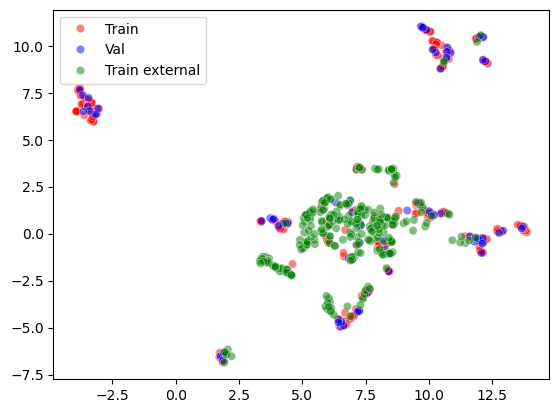

In [132]:
import umap
import seaborn as sns

all_ecfp = np.concatenate([train_ecfp, val_ecfp, train_ext_ecfp])
all_ecfp_umap = umap.UMAP(
    n_components=2, random_state=RANDOM_STATE, n_jobs=1, metric='jaccard'
).fit_transform(all_ecfp)
sns.scatterplot(
    x=all_ecfp_umap[:, 0], y=all_ecfp_umap[:, 1], 
    hue=['Train']*len(train_ecfp) + ['Val']*len(val_ecfp) + ['Train external']*len(train_ext_ecfp),
    palette={'Train': 'red', 'Val': 'blue', 'Train external': 'green'},
    alpha=0.5
);

In [160]:
def get_all_topk_smiles_with_properties(
        ref_data, query_data, query2ref_dist, properties, topk=TOPK
    ):
    for i in range(query2ref_dist.shape[0]):
        query_smiles = query_data.iloc[i]['smiles_std']
        query_properties = {}
        topk_smiles2properties = defaultdict(dict)
        for property in properties:
            query_property = query_data.iloc[i][property]
            if not np.isnan(query_property):
                query_properties[property] = query_property

            ref_data_with_property = ref_data[ref_data[property].notna()]
            dist = query2ref_dist[i, ref_data_with_property.index]
            order = np.argsort(dist)[::-1]
            ordered_dist = dist[order]
            order = order[~np.isclose(ordered_dist, 1.0)]  # remove self-similarity including duplicates
            topk_idx = order[:topk]
            topk_smiles = ref_data_with_property.iloc[topk_idx]['smiles_std'].tolist()
            topk_properties = ref_data_with_property.iloc[topk_idx][property].tolist()

            for smi, prop in zip(topk_smiles, topk_properties):
                topk_smiles2properties[smi][property] = prop
        
        yield topk_smiles2properties, query_smiles, query_properties

In [161]:
system_instruction_internal = """
You are an experienced medicinal chemist who worked many years determining ADME properties of drug-like molecules. You can determine ADME properties based on molecular structure and properties of similar molecules from a reference set.

You are given a list of reference molecules represented in SMILES paired with their property values. Here is the list of properties that you may or may not be given as input:
Log HLM (uL/min/mg), human microsomal stability
Log MLM (uL/min/mg), rat microsomal stability
Log KSOL (uM), KSOL assay readouts for solubility at pH 7.4
LogD, LogD calculation for solubility at pH 7.4
Log MDR1-MDCKII (10^-6 cm/s), MDR1-MDCKII assay readouts for permeability

Some values might be incorrect due to assay errors. Your task is to determine the requested properties of the molecule represented in SMILES. Answer only with a single floating point number per property."
"""

system_instruction_external = """
You are an experienced medicinal chemist who worked many years determining ADME properties of drug-like molecules. You can determine ADME properties based on molecular structure and properties of similar molecules from a reference set.

You are given a list of reference molecules represented in SMILES paired with their property values. Here is the list of properties that you may or may not be given as input:
LOG HLM_CLint (mL/min/kg), human microsomal stability
LOG RLM_CLint (mL/min/kg), rat microsomal stability
LOG PLASMA PROTEIN BINDING (% unbound), human plasma protein binding
LOG PLASMA PROTEIN BINDING (% unbound), rat plasma protein binding
LOG MDR1-MDCK ER (B-A/A-B), permeability
LOG SOLUBILITY, calculation for solubility at pH 6.8

Some values might be incorrect due to assay errors. Your task is to determine the requested properties of the molecule represented in SMILES. Answer only with a single floating point number per property."
"""

In [162]:
def format_data(
    topk_smiles2properties: dict[str, dict[str, float]],
    query_smiles: str,
    query_properties: dict[str, float] | None = None,
    system_instruction: str | None = None,
    properties: list[str] | None = None
):
    if system_instruction is not None:
        output = {
            "systemInstruction": {
            "parts": [
            {
                "text": system_instruction
            }
            ]
        }
    }
    else:
        output = {}

    parts = [
        {
            "text": "; ".join([
                f"SMILES: {smi}, " + ", ".join([
                    f"{prop_name}={prop_val:.2f}"
                    for prop_name, prop_val in prop_name2prop_val.items()
                ])
                for smi, prop_name2prop_val in topk_smiles2properties.items()
            ])
        }
    ]
    if query_properties is not None:
        parts.append({
            "text": f"SMILES: {query_smiles}; " + "Determine " + ", ".join([
                f"{prop_name}" for prop_name in query_properties.keys()
            ])
        })
    else:
        parts.append({
            "text": f"SMILES: {query_smiles}; " + "Determine " +", ".join([
                f"{prop_name}" for prop_name in properties
            ])
        })
    
    output.update({
        "contents": [
            {
            "role": "user",
            "parts": parts
            }
        ]
    })

    if query_properties is not None:
        output['contents'].append({
            "role": "model",
            "parts": [
                {
                    "text": ", ".join([
                        f"{prop_name}={prop_val:.2f}"
                        for prop_name, prop_val in query_properties.items()
                    ])
                }
            ]
        })
    
    return output

In [163]:
train_dataset = [
    format_data(
        topk_smiles2properties=topk_smiles2properties,
        query_smiles=query_smiles,
        query_properties=query_properties,
        system_instruction=system_instruction_internal,
        properties=INTERNAL_PROPERTIES
    )
    for topk_smiles2properties, query_smiles, query_properties in get_all_topk_smiles_with_properties(
        ref_data=ref_data,
        query_data=train,
        query2ref_dist=train2ref_dist,
        properties=INTERNAL_PROPERTIES,
        topk=TOPK
    )
] + [
    format_data(
        topk_smiles2properties=topk_smiles2properties,
        query_smiles=query_smiles,
        query_properties=query_properties,
        system_instruction=system_instruction_external,
        properties=EXTERNAL_PROPERTIES
    )
    for topk_smiles2properties, query_smiles, query_properties in get_all_topk_smiles_with_properties(
        ref_data=ref_ext,
        query_data=train_ext,
        query2ref_dist=train_ext2ref_ext_dist,
        properties=EXTERNAL_PROPERTIES,
        topk=TOPK
    )
]

In [164]:
train_dataset[0]

{'systemInstruction': {'parts': [{'text': '\nYou are an experienced medicinal chemist who worked many years determining ADME properties of drug-like molecules. You can determine ADME properties based on molecular structure and properties of similar molecules from a reference set.\n\nYou are given a list of reference molecules represented in SMILES paired with their property values. Here is the list of properties that you may or may not be given as input:\nLog HLM (uL/min/mg), human microsomal stability\nLog MLM (uL/min/mg), rat microsomal stability\nLog KSOL (uM), KSOL assay readouts for solubility at pH 7.4\nLogD, LogD calculation for solubility at pH 7.4\nLog MDR1-MDCKII (10^-6 cm/s), MDR1-MDCKII assay readouts for permeability\n\nSome values might be incorrect due to assay errors. Your task is to determine the requested properties of the molecule represented in SMILES. Answer only with a single floating point number per property."\n'}]},
 'contents': [{'role': 'user',
   'parts': [{

In [165]:
train_dataset[-1]

{'systemInstruction': {'parts': [{'text': '\nYou are an experienced medicinal chemist who worked many years determining ADME properties of drug-like molecules. You can determine ADME properties based on molecular structure and properties of similar molecules from a reference set.\n\nYou are given a list of reference molecules represented in SMILES paired with their property values. Here is the list of properties that you may or may not be given as input:\nLOG HLM_CLint (mL/min/kg), human microsomal stability\nLOG RLM_CLint (mL/min/kg), rat microsomal stability\nLOG PLASMA PROTEIN BINDING (% unbound), human plasma protein binding\nLOG PLASMA PROTEIN BINDING (% unbound), rat plasma protein binding\nLOG MDR1-MDCK ER (B-A/A-B), permeability\nLOG SOLUBILITY, calculation for solubility at pH 6.8\n\nSome values might be incorrect due to assay errors. Your task is to determine the requested properties of the molecule represented in SMILES. Answer only with a single floating point number per pr

In [166]:
val_dataset = [
    format_data(
        topk_smiles2properties=topk_smiles2properties,
        query_smiles=query_smiles,
        query_properties=query_properties,
        system_instruction=system_instruction_internal,
        properties=INTERNAL_PROPERTIES
    )
    for topk_smiles2properties, query_smiles, query_properties in get_all_topk_smiles_with_properties(
        ref_data=ref_data,
        query_data=val,
        query2ref_dist=val2ref_dist,
        properties=INTERNAL_PROPERTIES,
        topk=TOPK
    )
]

In [167]:
val_dataset[0]

{'systemInstruction': {'parts': [{'text': '\nYou are an experienced medicinal chemist who worked many years determining ADME properties of drug-like molecules. You can determine ADME properties based on molecular structure and properties of similar molecules from a reference set.\n\nYou are given a list of reference molecules represented in SMILES paired with their property values. Here is the list of properties that you may or may not be given as input:\nLog HLM (uL/min/mg), human microsomal stability\nLog MLM (uL/min/mg), rat microsomal stability\nLog KSOL (uM), KSOL assay readouts for solubility at pH 7.4\nLogD, LogD calculation for solubility at pH 7.4\nLog MDR1-MDCKII (10^-6 cm/s), MDR1-MDCKII assay readouts for permeability\n\nSome values might be incorrect due to assay errors. Your task is to determine the requested properties of the molecule represented in SMILES. Answer only with a single floating point number per property."\n'}]},
 'contents': [{'role': 'user',
   'parts': [{

In [168]:
data_dir = Path(f"../data/asap/datasets/rnd_splits/split_{SPLIT}/")
data_dir.mkdir(parents=True, exist_ok=True)
train_data_path = data_dir / f"gemini_all_prop_top{TOPK}ext_train.jsonl"
val_data_path = data_dir / f"gemini_all_prop_top{TOPK}ext_val.jsonl"
train_gs_uri = f"<gs_bucket>/data/asap/datasets/rnd_splits/split_{SPLIT}/gemini_all_prop_top{TOPK}ext_train.jsonl"
val_gs_uri = f"<gs_bucket>/data/asap/datasets/rnd_splits/split_{SPLIT}/gemini_all_prop_top{TOPK}ext_val.jsonl"

save_and_upload_training_data(train_dataset, train_data_path, train_gs_uri)
save_and_upload_training_data(val_dataset, val_data_path, val_gs_uri)

In [159]:
start_finetuning_sft(
    train_dataset_gs_uri=train_gs_uri, val_dataset_gs_uri=val_gs_uri,
    source_model="gemini-1.5-flash-002", epochs=10
)

Creating SupervisedTuningJob
SupervisedTuningJob created. Resource name: projects/199759238457/locations/us-central1/tuningJobs/3555650197105147904
To use this SupervisedTuningJob in another session:
tuning_job = sft.SupervisedTuningJob('projects/199759238457/locations/us-central1/tuningJobs/3555650197105147904')
View Tuning Job:
https://console.cloud.google.com/vertex-ai/generative/language/locations/us-central1/tuning/tuningJob/3555650197105147904?project=199759238457


In [169]:
TUNING_JOB_ID = "3555650197105147904"  # gemini-1.5-flash-002, 10 epochs, system instruction (with units), external data separate, aMAE=0
sft_tuning_job = sft.SupervisedTuningJob(f"projects/{PROJECT_ID}/locations/{LOCATION}/tuningJobs/{TUNING_JOB_ID}")
tuned_model = GenerativeModel(
    sft_tuning_job.tuned_model_endpoint_name,
    generation_config=GenerationConfig(
        temperature=0.0,
    ),
    system_instruction=system_instruction
)

In [170]:
val_dataset = [
    format_data(
        topk_smiles2properties=topk_smiles2properties,
        query_smiles=query_smiles,
        # query_properties=query_properties,
        system_instruction=system_instruction_internal,
        properties=INTERNAL_PROPERTIES
    )
    for topk_smiles2properties, query_smiles, query_properties in get_all_topk_smiles_with_properties(
        ref_data=ref_data,
        query_data=val,
        query2ref_dist=val2ref_dist,
        properties=INTERNAL_PROPERTIES,
        topk=TOPK
    )
]

In [171]:
for content in val_dataset:
    result = tuned_model.generate_content(content['contents'])
    print(result)
    break

candidates {
  content {
    role: "model"
    parts {
      text: "LogHLM=1.60, LogMLM=1.90, LogD=1.60, LogKSOL=2.58, LogMDR1-MDCKII=0.69\n\n"
    }
  }
  finish_reason: STOP
  avg_logprobs: -0.35048373540242511
}
usage_metadata {
  prompt_token_count: 1024
  candidates_token_count: 48
  total_token_count: 1072
  prompt_tokens_details {
    modality: TEXT
    token_count: 1024
  }
  candidates_tokens_details {
    modality: TEXT
    token_count: 48
  }
}
create_time {
  seconds: 1741909403
  nanos: 697859000
}
response_id: "m23TZ4PMKquAm9IP9KXQ2Ag"



In [173]:
predictions = list(tqdm(map(partial(get_answer, tuned_model), val_dataset), total=len(val_dataset)))
predictions = pd.DataFrame(predictions).rename(columns={prop: f'pred_{prop}' for prop in PROPERTIES})
val_ = pd.concat([val, predictions], axis=1)
val_preds = extract_preds(val_)
val_refs = extract_refs(val_)
metrics = eval_admet(val_preds, val_refs, target_columns=TARGET_COLUMNS)
print(json.dumps(metrics, indent=2))

100%|██████████| 81/81 [01:22<00:00,  1.02s/it]

{
  "HLM": {
    "mean_absolute_error": 0.33405890587089776,
    "r2": 0.37435839437912566
  },
  "MLM": {
    "mean_absolute_error": 0.36140188211202856,
    "r2": 0.4668971117968782
  },
  "LogD": {
    "mean_absolute_error": 0.5244262295081967,
    "r2": 0.7346939192682593
  },
  "KSOL": {
    "mean_absolute_error": 0.3455056524342982,
    "r2": 0.32939210131761165
  },
  "MDR1-MDCKII": {
    "mean_absolute_error": 0.26468941875851737,
    "r2": 0.21621007497000755
  },
  "aggregated": {
    "macro_mean_absolute_error": 0.3660164177367878,
    "macro_r2": 0.42431032034637645
  }
}


## Hypothesis 9 - top-k closest molecules from train with given properties + external data

In [180]:
TOPK = 5

In [207]:
data = pd.read_csv(f'../data/asap/datasets/rnd_splits/split_{SPLIT}.csv')
external_data = pd.read_csv('../data/asap/preproc/biogen-adme-fang-v1-std.tsv', sep='\t')
external_data

,UNIQUE_ID,MOL_smiles,SMILES,LOG_HLM_CLint,LOG_RLM_CLint,LOG_MDR1-MDCK_ER,LOG_HPPB,LOG_RPPB,LOG_SOLUBILITY,smiles_std
0,b5e1231aef0080c76b4207ca1355485432877339,Brc1cc2c(cc1Cn1cncn1)OCCCO2,Brc1cc2c(cc1Cn1cncn1)OCCCO2,0.886265,2.357933,-0.247518,NaN,NaN,1.536432,Brc1cc2c(cc1Cn1cncn1)OCCCO2
1,0604cf74e44450d5963d169e18854d96c4e5dba8,Brc1ccc(-c2nnc(Cn3cnc4ccccc43)o2)o1,Brc1ccc(-c2nnc(Cn3cnc4ccccc43)o2)o1,0.675687,1.613704,-0.010669,NaN,NaN,1.797475,Brc1ccc(-c2nnc(Cn3cnc4ccccc43)o2)o1
2,c518badac8533fdb0de4679c17ce4035eab9ac28,Brc1cnc(N2CCCN(c3ccccc3)CC2)nc1,Brc1cnc(N2CCCN(c3ccccc3)CC2)nc1,2.081607,3.753651,NaN,NaN,NaN,NaN,Brc1cnc(N2CCCN(c3ccccc3)CC2)nc1
3,9be43035e7b8a5078babf4345584f4dc6dcd1448,Brc1cnc2ccccc2c1,Brc1cnc2ccccc2c1,NaN,NaN,NaN,NaN,NaN,-0.033858,Brc1cnc2ccccc2c1
4,57b907f2f455c3ce3ba21114f32f93b301c99a34,Brc1nnc(N2CCC(OC3CCCC3)CC2)s1,Brc1nnc(N2CCC(OC3CCCC3)CC2)s1,1.888410,3.492201,-0.235024,NaN,NaN,NaN,Brc1nnc(N2CCC(OC3CCCC3)CC2)s1
...,...,...,...,...,...,...,...,...,...,...
3512,6170f36d417c6cebd1a98e82f03005da39ccc983,c1nc(N2CCC3(CCCCC3)C2)c2cn[nH]c2n1,c1nc(N2CCC3(CCCCC3)C2)c2cn[nH]c2n1,0.920801,2.851225,-0.096904,NaN,NaN,NaN,c1nc(N2CCC3(CCCCC3)C2)c2cn[nH]c2n1
3513,644313d1941ab4550760b7c1162c54d209a7435f,c1nc(NC2CCN(C3CC3)CC2)c2sccc2n1,c1nc(NC2CCN(C3CC3)CC2)c2sccc2n1,1.240899,1.906157,0.094514,NaN,NaN,1.749891,c1nc(NC2CCN(C3CC3)CC2)c2sccc2n1
3514,32658afab9952faf20249dbb305e1ac85ef10a1b,c1nc(Nc2ccc3c(c2)OCCCO3)c2sccc2n1,c1nc(Nc2ccc3c(c2)OCCCO3)c2sccc2n1,1.964066,3.196559,NaN,NaN,NaN,1.707229,c1nc(Nc2ccc3c(c2)OCCCO3)c2sccc2n1
3515,de4a8fd15738b6f012f58b93bb6784afc82f9742,c1nn(C2CCOCC2)cc1Nc1ncc2nnn(-c3ccc4cn[nH]c4c3)...,c1nn(C2CCOCC2)cc1Nc1ncc2nnn(-c3ccc4cn[nH]c4c3)...,1.985754,2.883853,2.725057,NaN,NaN,NaN,c1nn(C2CCOCC2)cc1Nc1ncc2nnn(-c3ccc4cn[nH]c4c3)...


In [208]:
external_data['LogD'] = external_data['LOG_SOLUBILITY']
external_data['LogHLM'] = external_data['LOG_HLM_CLint']
external_data['LogMLM'] = external_data['LOG_RLM_CLint']
external_data['LogMDR1-MDCKII'] = external_data['LOG_MDR1-MDCK_ER']

In [209]:
train = data[data['split'] == 'train'].reset_index(drop=True)
val = data[data['split'] == 'val'].reset_index(drop=True)
ref_data = pd.concat([
    data[(data['split'] == 'train') & ~data[PROPERTY].isna()],
    external_data[~external_data[PROPERTY].isna()]
]).reset_index(drop=True)
train_ecfp = np.array(train['smiles_std'].apply(partial(ECFP_from_smiles, use_chirality=True)).tolist())
val_ecfp = np.array(val['smiles_std'].apply(partial(ECFP_from_smiles, use_chirality=True)).tolist())
ref_ecfp = np.array(ref_data['smiles_std'].apply(partial(ECFP_from_smiles, use_chirality=True)).tolist())
train2ref_dist = tanimoto_similarity(train_ecfp, ref_ecfp)
val2ref_dist = tanimoto_similarity(val_ecfp, ref_ecfp)
train2ref_dist.shape, val2ref_dist.shape

((323, 2427), (81, 2427))

In [210]:
ref_data

,smiles,HLM,KSOL,LogD,MLM,MDR1-MDCKII,smiles_std,cxsmiles_std,mol_idx,smiles_ext,...,split,UNIQUE_ID,MOL_smiles,SMILES,LOG_HLM_CLint,LOG_RLM_CLint,LOG_MDR1-MDCK_ER,LOG_HPPB,LOG_RPPB,LOG_SOLUBILITY
0,O=C(NCC(F)F)[C@H](NC1=CC2=C(C=C1Br)CNC2)C1=CC(...,NaN,333.0,2.900000,NaN,0.2,O=C(NCC(F)F)[C@H](Nc1cc2c(cc1Br)CNC2)c1cc(Cl)c...,O=C(NCC(F)F)[C@H](Nc1cc2c(cc1Br)CNC2)c1cc(Cl)c...,335.0,|&1:7|,...,train,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,O=C(NCC(F)F)[C@H](NC1=CC=C2CNCC2=C1)C1=CC(Br)=...,NaN,NaN,0.400000,NaN,0.5,O=C(NCC(F)F)[C@H](Nc1ccc2c(c1)CNC2)c1cc(Br)cc2...,O=C(NCC(F)F)[C@H](Nc1ccc2c(c1)CNC2)c1cc(Br)cc2...,336.0,|&1:7|,...,train,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NC(=O)[C@H]1CCCN(C(=O)CC2=CC=CC3=C2C=CO3)C1 |&...,NaN,376.0,1.000000,NaN,8.5,NC(=O)[C@H]1CCCN(C(=O)Cc2cccc3occc23)C1,NC(=O)[C@H]1CCCN(C(=O)Cc2cccc3occc23)C1 |&1:3|,300.0,|&1:3|,...,train,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,CC1=CC(CC(=O)N2CCC[C@H](C(N)=O)C2)=CC=N1 |&1:11|,NaN,375.0,-0.300000,NaN,0.9,Cc1cc(CC(=O)N2CCC[C@H](C(N)=O)C2)ccn1,Cc1cc(CC(=O)N2CCC[C@H](C(N)=O)C2)ccn1 |&1:11|,249.0,|&1:11|,...,train,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,COC1=CC(Cl)=CC([C@H](NC2=CC=C3CNCC3=C2)C(=O)NC...,NaN,NaN,0.500000,NaN,0.7,COc1cc(Cl)cc([C@H](Nc2ccc3c(c2)CNC3)C(=O)NCC(F...,COc1cc(Cl)cc([C@H](Nc2ccc3c(c2)CNC3)C(=O)NCC(F...,178.0,|&1:8|,...,train,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2422,NaN,NaN,NaN,1.239049,NaN,NaN,c1cncc(-c2ccnn2CN2CCOCC2)c1,NaN,NaN,NaN,...,NaN,6b39954041ed15e815bc15457e06440183006a00,c1cncc(-c2ccnn2CN2CCOCC2)c1,c1cncc(-c2ccnn2CN2CCOCC2)c1,NaN,NaN,NaN,NaN,NaN,1.239049
2423,NaN,NaN,NaN,-0.107905,NaN,NaN,c1cnn(-c2ccc(-c3ccc(NC4CC4)nn3)cc2)c1,NaN,NaN,NaN,...,NaN,d08dfa20c576ef45061fd2af3a1c7acc286bc6d2,c1cnn(-c2ccc(-c3ccc(NC4CC4)nn3)cc2)c1,c1cnn(-c2ccc(-c3ccc(NC4CC4)nn3)cc2)c1,NaN,NaN,NaN,NaN,NaN,-0.107905
2424,NaN,NaN,NaN,1.690107,NaN,NaN,c1csc(-c2csc3nc(CN4CCOCC4)nc(N4CCc5[nH]ncc5C4)...,NaN,NaN,NaN,...,NaN,c9bf3aca6d10ff3538ce617d83b9de8c80723024,c1csc(-c2csc3nc(CN4CCOCC4)nc(N4CCc5[nH]ncc5C4)...,c1csc(-c2csc3nc(CN4CCOCC4)nc(N4CCc5[nH]ncc5C4)...,2.747507,3.118970,1.921635,NaN,NaN,1.690107
2425,NaN,NaN,NaN,1.749891,NaN,NaN,c1nc(NC2CCN(C3CC3)CC2)c2sccc2n1,NaN,NaN,NaN,...,NaN,644313d1941ab4550760b7c1162c54d209a7435f,c1nc(NC2CCN(C3CC3)CC2)c2sccc2n1,c1nc(NC2CCN(C3CC3)CC2)c2sccc2n1,1.240899,1.906157,0.094514,NaN,NaN,1.749891


In [211]:
def get_all_topk_smiles_with_properties(ref_data, query_data, query2ref_dist, topk=TOPK, property=PROPERTY):
    for i in range(query2ref_dist.shape[0]):
        query_smiles = query_data.iloc[i]['smiles_std']
        query_property = query_data.iloc[i][property]
        if np.isnan(query_property):
            continue

        dist = query2ref_dist[i]
        order = np.argsort(dist)[::-1]
        ordered_dist = dist[order]
        order = order[~np.isclose(ordered_dist, 1.0)]  # remove self-similarity including duplicates
        topk_idx = order[:topk]
        topk_smiles = ref_data.iloc[topk_idx]['smiles_std'].tolist()
        topk_properties = ref_data.iloc[topk_idx][property].tolist()
        yield topk_smiles, topk_properties, query_smiles, query_property

In [212]:
def format_data(
    input_smiles: list[str],
    input_properties: list[float],
    query_smiles: str,
    query_property: float | None = None,
    system_instruction: str | None = None
):
    if system_instruction is not None:
        output = {
            "systemInstruction": {
            "role": "Ignored",
            "parts": [
            {
                "text": system_instruction
            }
            ]
        }
    }
    else:
        output = {}
    
    output.update({
        "contents": [
            {
            "role": "user",
            "parts": [{
                "text": "; ".join([
                    f"{smi}, {PROPERTY}={prop:.2f}" 
                    for smi, prop in zip(input_smiles, input_properties)
                ]) + f"; Determine {PROPERTY} of {query_smiles}"
            }]
            # {
                #     "text": f"SMILES: {smi}, {PROPERTY}: {prop:.2f}",
                # }
                # for smi, prop in zip(input_smiles, input_properties)
            # "text": f"Determine {PROPERTY} of {query_smiles}"
            }
        ]
    })

    if query_property is not None:
        output['contents'].append({
            "role": "model",
            "parts": [
                {
                    "text": f"{PROPERTY}={query_property:.2f}"
                }
            ]
        })
    
    return output

In [219]:
SYSTEM_INSTRUCTIONS = {
    "LogD": \
        f"You are an experienced medicinal chemist who worked determining the {PROPERTY} of molecules for years. "
        f"You can determine the {PROPERTY} of a molecule based on its structure and properties of similar molecules from a reference set. "
        f"You are given a list of {TOPK} reference molecules represented in SMILES paired with their {PROPERTY} values. "
        f"Some values might be incorrect due to assay errors. Take these compounds with care. "
        f"Your task is to determine the {PROPERTY} the molecule represented in SMILES. "
        f"Answer only with a single floating point number."
}

In [220]:
train_dataset = [
    format_data(
        input_smiles=input_smiles,
        input_properties=input_properties,
        query_smiles=query_smiles,
        query_property=query_property,
        system_instruction=SYSTEM_INSTRUCTIONS[PROPERTY]
    )
    for input_smiles, input_properties, query_smiles, query_property in get_all_topk_smiles_with_properties(
        ref_data=ref_data,
        query_data=train,
        query2ref_dist=train2ref_dist,
        topk=TOPK,
        property=PROPERTY
    )
]

In [221]:
val_dataset = [
    format_data(
        input_smiles=input_smiles,
        input_properties=input_properties,
        query_smiles=query_smiles
    )
    for input_smiles, input_properties, query_smiles, _ in get_all_topk_smiles_with_properties(
        ref_data=ref_data,
        query_data=val,
        query2ref_dist=val2ref_dist,
        topk=TOPK,
        property=PROPERTY
    )
]

In [222]:
train_dataset[0]

{'systemInstruction': {'role': 'Ignored',
  'parts': [{'text': 'You are an experienced medicinal chemist who worked determining the LogD of molecules for years. You can determine the LogD of a molecule based on its structure and properties of similar molecules from a reference set. You are given a list of 5 reference molecules represented in SMILES paired with their LogD values. Some values might be incorrect due to assay errors. Take these compounds with care. Your task is to determine the LogD the molecule represented in SMILES. Answer only with a single floating point number.'}]},
 'contents': [{'role': 'user',
   'parts': [{'text': 'O=C(NCC(F)F)[C@H](Nc1ccc2c(c1)CNC2)c1cc(Cl)cc(C2CC2)c1, LogD=1.60; O=C(NCC(F)F)[C@H](Nc1ccc2c(c1)CNC2)c1cc(Cl)cc(C2CC2)c1, LogD=1.35; CN(c1ccc2c(c1)CNC2)[C@H](C(=O)NCC(F)F)c1cc(Cl)cc(C2CC2)c1, LogD=1.60; O=C(NCCCF)[C@H](Nc1ccc2c(c1)CNC2)c1cc(Cl)cc(C2CC2)c1, LogD=1.20; CCCCNC(=O)[C@H](Nc1ccc2c(c1)CNC2)c1cc(Cl)cc(C2CC2)c1, LogD=2.30; Determine LogD of O=C

In [223]:
val_dataset[0]

{'contents': [{'role': 'user',
   'parts': [{'text': 'COc1cc2c(cc1OC)CN(C(=O)C1CCCN(C(=O)Nc3ccccc3)C1)CC2, LogD=1.82; NC(=O)[C@H]1CCCN(C(=O)Cc2cccc3occc23)C1, LogD=1.00; Cc1cc(CC(=O)N2CCC[C@H](C(N)=O)C2)ccn1, LogD=-0.30; CNC(=O)c1cccc(NC(=O)N2CCC(Oc3ccccc3Cl)CC2)c1, LogD=1.84; COc1cc2c(cc1OC)CN(C(=O)C1CCCN(C(C)=O)C1)CC2, LogD=1.74; Determine LogD of COc1cccc(Cl)c1NC(=O)N1CCC[C@H](C(N)=O)C1'}]}]}

In [224]:
data_path = Path(f"../data/asap/datasets/rnd_splits/split_{SPLIT}/gemini_train.jsonl")
data_path.parent.mkdir(parents=True, exist_ok=True)
gs_uri = f"<gs_bucket>/data/asap/datasets/rnd_splits/split_{SPLIT}/gemini_train.jsonl"

save_and_upload_training_data(train_dataset, data_path, gs_uri)

In [225]:
start_finetuning_sft(train_dataset_gs_uri=gs_uri, source_model="gemini-1.5-flash-002", epochs=10)

Creating SupervisedTuningJob
SupervisedTuningJob created. Resource name: projects/199759238457/locations/us-central1/tuningJobs/4774014633797222400
To use this SupervisedTuningJob in another session:
tuning_job = sft.SupervisedTuningJob('projects/199759238457/locations/us-central1/tuningJobs/4774014633797222400')
View Tuning Job:
https://console.cloud.google.com/vertex-ai/generative/language/locations/us-central1/tuning/tuningJob/4774014633797222400?project=199759238457


In [226]:
TUNING_JOB_ID = "4774014633797222400"   # gemini-1.5-flash-002, epochs=10, top-k=5, MAE=0.426
sft_tuning_job = sft.SupervisedTuningJob(f"projects/{PROJECT_ID}/locations/{LOCATION}/tuningJobs/{TUNING_JOB_ID}")
tuned_model = GenerativeModel(
    sft_tuning_job.tuned_model_endpoint_name,
    generation_config=GenerationConfig(
        temperature=0.0
    ),
    system_instruction=SYSTEM_INSTRUCTIONS[PROPERTY]
)

In [227]:
for content in val_dataset:
    result = tuned_model.generate_content(content['contents'])
    print(result)
    break

candidates {
  content {
    role: "model"
    parts {
      text: "LogD=0.60\n\n"
    }
  }
  finish_reason: STOP
  avg_logprobs: -0.35810506343841553
}
usage_metadata {
  prompt_token_count: 329
  candidates_token_count: 8
  total_token_count: 337
  prompt_tokens_details {
    modality: TEXT
    token_count: 329
  }
  candidates_tokens_details {
    modality: TEXT
    token_count: 8
  }
}
create_time {
  seconds: 1741914820
  nanos: 83650000
}
response_id: "xILTZ8KNBfCTmecPzZupmQc"



In [231]:
predictions = list(tqdm(map(partial(get_single_property_answer, tuned_model), val_dataset), total=len(val_dataset)))
val_ = val.copy()
val_.loc[val_[PROPERTY].notna(), f'pred_{PROPERTY}'] = predictions
val_preds = extract_preds(val_, target_columns=[PROPERTY])
val_refs = extract_refs(val_, target_columns=[PROPERTY])
metrics = eval_admet(val_preds, val_refs, target_columns=[TARGET_COLUMN])
print(json.dumps(metrics, indent=2))

100%|██████████| 61/61 [00:48<00:00,  1.26it/s]

{
  "LogD": {
    "mean_absolute_error": 0.42606557377049176,
    "r2": 0.798277442715098
  },
  "aggregated": {
    "macro_mean_absolute_error": 0.42606557377049176,
    "macro_r2": 0.798277442715098
  }
}


## Hypothesis 10 - top-k closest molecules from train with given properties + regularization

In [315]:
TOPK = 5
PROPERTY = 'LogD'
TARGET_COLUMN = 'LogD'
# PROPERTY = 'LogKSOL'
# TARGET_COLUMN = 'KSOL'

In [316]:
data = pd.read_csv(f'../data/asap/datasets/rnd_splits/split_{SPLIT}.csv')
data

,smiles,HLM,KSOL,LogD,MLM,MDR1-MDCKII,smiles_std,cxsmiles_std,mol_idx,smiles_ext,LogHLM,LogMLM,LogKSOL,LogMDR1-MDCKII,split
0,COC1=CC=CC(Cl)=C1NC(=O)N1CCC[C@H](C(N)=O)C1 |a...,NaN,NaN,0.3,NaN,2.0,COc1cccc(Cl)c1NC(=O)N1CCC[C@H](C(N)=O)C1,COc1cccc(Cl)c1NC(=O)N1CCC[C@H](C(N)=O)C1 |a:16|,191,|a:16|,NaN,NaN,NaN,0.477121,val
1,O=C(NCC(F)F)[C@H](NC1=CC2=C(C=C1Br)CNC2)C1=CC(...,NaN,333.0,2.9,NaN,0.2,O=C(NCC(F)F)[C@H](Nc1cc2c(cc1Br)CNC2)c1cc(Cl)c...,O=C(NCC(F)F)[C@H](Nc1cc2c(cc1Br)CNC2)c1cc(Cl)c...,335,|&1:7|,NaN,NaN,2.523746,0.079181,train
2,O=C(NCC(F)F)[C@H](NC1=CC=C2CNCC2=C1)C1=CC(Br)=...,NaN,NaN,0.4,NaN,0.5,O=C(NCC(F)F)[C@H](Nc1ccc2c(c1)CNC2)c1cc(Br)cc2...,O=C(NCC(F)F)[C@H](Nc1ccc2c(c1)CNC2)c1cc(Br)cc2...,336,|&1:7|,NaN,NaN,NaN,0.176091,train
3,NC(=O)[C@H]1CCCN(C(=O)CC2=CC=CC3=C2C=CO3)C1 |&...,NaN,376.0,1.0,NaN,8.5,NC(=O)[C@H]1CCCN(C(=O)Cc2cccc3occc23)C1,NC(=O)[C@H]1CCCN(C(=O)Cc2cccc3occc23)C1 |&1:3|,300,|&1:3|,NaN,NaN,2.576341,0.977724,train
4,CC1=CC(CC(=O)N2CCC[C@H](C(N)=O)C2)=CC=N1 |&1:11|,NaN,375.0,-0.3,NaN,0.9,Cc1cc(CC(=O)N2CCC[C@H](C(N)=O)C2)ccn1,Cc1cc(CC(=O)N2CCC[C@H](C(N)=O)C2)ccn1 |&1:11|,249,|&1:11|,NaN,NaN,2.575188,0.278754,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399,CC(C)NC[C@H](O)COC1=CC=CC2=CC=CC=C12 |&1:5|,25.5,NaN,NaN,63.0,NaN,CC(C)NC[C@H](O)COc1cccc2ccccc12,CC(C)NC[C@H](O)COc1cccc2ccccc12 |&1:5|,22,|&1:5|,1.423246,1.806180,NaN,NaN,val
400,O=C(O)CC1=CC=CC=C1NC1=C(Cl)C=CC=C1Cl,216.0,NaN,NaN,386.0,NaN,O=C(O)Cc1ccccc1Nc1c(Cl)cccc1Cl,O=C(O)Cc1ccccc1Nc1c(Cl)cccc1Cl,380,NaN,2.336460,2.587711,NaN,NaN,val
401,NCC1=CC(Cl)=CC(C(=O)NC2=CC=C3CNCC3=C2)=C1,NaN,NaN,2.0,NaN,NaN,NCc1cc(Cl)cc(C(=O)Nc2ccc3c(c2)CNC3)c1,NCc1cc(Cl)cc(C(=O)Nc2ccc3c(c2)CNC3)c1,303,NaN,NaN,NaN,NaN,NaN,train
402,COC(=O)NC1=NC2=CC=C(C(=O)C3=CC=CC=C3)C=C2N1,NaN,NaN,2.9,NaN,NaN,COC(=O)Nc1nc2ccc(C(=O)c3ccccc3)cc2[nH]1,COC(=O)Nc1nc2ccc(C(=O)c3ccccc3)cc2[nH]1,166,NaN,NaN,NaN,NaN,NaN,train


In [317]:
train = data[data['split'] == 'train'].reset_index(drop=True)
val = data[data['split'] == 'val'].reset_index(drop=True)
ref_data = data[(data['split'] == 'train') & ~data[PROPERTY].isna()].reset_index(drop=True)
train_ecfp = np.array(train['smiles_std'].apply(partial(ECFP_from_smiles, use_chirality=True)).tolist())
val_ecfp = np.array(val['smiles_std'].apply(partial(ECFP_from_smiles, use_chirality=True)).tolist())
ref_ecfp = np.array(ref_data['smiles_std'].apply(partial(ECFP_from_smiles, use_chirality=True)).tolist())
train2ref_dist = tanimoto_similarity(train_ecfp, ref_ecfp)
val2ref_dist = tanimoto_similarity(val_ecfp, ref_ecfp)
train2ref_dist.shape, val2ref_dist.shape

((323, 257), (81, 257))

In [318]:
ref_data

,smiles,HLM,KSOL,LogD,MLM,MDR1-MDCKII,smiles_std,cxsmiles_std,mol_idx,smiles_ext,LogHLM,LogMLM,LogKSOL,LogMDR1-MDCKII,split
0,O=C(NCC(F)F)[C@H](NC1=CC2=C(C=C1Br)CNC2)C1=CC(...,NaN,333.0,2.90,NaN,0.2,O=C(NCC(F)F)[C@H](Nc1cc2c(cc1Br)CNC2)c1cc(Cl)c...,O=C(NCC(F)F)[C@H](Nc1cc2c(cc1Br)CNC2)c1cc(Cl)c...,335,|&1:7|,NaN,NaN,2.523746,0.079181,train
1,O=C(NCC(F)F)[C@H](NC1=CC=C2CNCC2=C1)C1=CC(Br)=...,NaN,NaN,0.40,NaN,0.5,O=C(NCC(F)F)[C@H](Nc1ccc2c(c1)CNC2)c1cc(Br)cc2...,O=C(NCC(F)F)[C@H](Nc1ccc2c(c1)CNC2)c1cc(Br)cc2...,336,|&1:7|,NaN,NaN,NaN,0.176091,train
2,NC(=O)[C@H]1CCCN(C(=O)CC2=CC=CC3=C2C=CO3)C1 |&...,NaN,376.0,1.00,NaN,8.5,NC(=O)[C@H]1CCCN(C(=O)Cc2cccc3occc23)C1,NC(=O)[C@H]1CCCN(C(=O)Cc2cccc3occc23)C1 |&1:3|,300,|&1:3|,NaN,NaN,2.576341,0.977724,train
3,CC1=CC(CC(=O)N2CCC[C@H](C(N)=O)C2)=CC=N1 |&1:11|,NaN,375.0,-0.30,NaN,0.9,Cc1cc(CC(=O)N2CCC[C@H](C(N)=O)C2)ccn1,Cc1cc(CC(=O)N2CCC[C@H](C(N)=O)C2)ccn1 |&1:11|,249,|&1:11|,NaN,NaN,2.575188,0.278754,train
4,COC1=CC(Cl)=CC([C@H](NC2=CC=C3CNCC3=C2)C(=O)NC...,NaN,NaN,0.50,NaN,0.7,COc1cc(Cl)cc([C@H](Nc2ccc3c(c2)CNC3)C(=O)NCC(F...,COc1cc(Cl)cc([C@H](Nc2ccc3c(c2)CNC3)C(=O)NCC(F...,178,|&1:8|,NaN,NaN,NaN,0.230449,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252,CNC(=O)CN1C[C@@]2(C(=O)N(C3=CN=CC4=CC=CC=C34)C...,1.0,NaN,1.07,23.0,1.7,CNC(=O)CN1C[C@@]2(C(=O)N(c3cncc4ccccc34)C[C@@H...,CNC(=O)CN1C[C@@]2(C(=O)N(c3cncc4ccccc34)C[C@@H...,112,NaN,0.301030,1.380211,NaN,0.431364,train
253,O=C(O)C[C@H](NC(=O)C1=NC=NC2=C1C=CN2)C1=CC=C(B...,6.0,NaN,0.22,1.0,2.6,O=C(O)C[C@H](NC(=O)c1ncnc2[nH]ccc12)c1ccc(Br)cc1,O=C(O)C[C@H](NC(=O)c1ncnc2[nH]ccc12)c1ccc(Br)c...,379,|&1:4|,0.845098,0.301030,NaN,0.556303,train
254,O=C(NC1=CC=CC=C1)NC1=CC=C(C(=O)NC2C3=C(CC2C(=O...,9.0,319.0,0.12,2.0,0.7,O=C(Nc1ccccc1)Nc1ccc(C(=O)NC2c3cccc(O)c3CC2C(=...,O=C(Nc1ccccc1)Nc1ccc(C(=O)NC2c3cccc(O)c3CC2C(=...,377,NaN,1.000000,0.477121,2.505150,0.230449,train
255,NCC1=CC(Cl)=CC(C(=O)NC2=CC=C3CNCC3=C2)=C1,NaN,NaN,2.00,NaN,NaN,NCc1cc(Cl)cc(C(=O)Nc2ccc3c(c2)CNC3)c1,NCc1cc(Cl)cc(C(=O)Nc2ccc3c(c2)CNC3)c1,303,NaN,NaN,NaN,NaN,NaN,train


In [319]:
def get_all_topk_smiles_with_properties(ref_data, query_data, query2ref_dist, topk=TOPK, property=PROPERTY, randomize=False):
    for i in range(query2ref_dist.shape[0]):
        query_smiles = query_data.iloc[i]['cxsmiles_std']
        query_property = query_data.iloc[i][property]
        if np.isnan(query_property):
            continue
        if randomize:
            query_property = random.uniform(query_property - 0.1, query_property + 0.1)

        dist = query2ref_dist[i]
        order = np.argsort(dist)[::-1]
        ordered_dist = dist[order]
        order = order[~np.isclose(ordered_dist, 1.0)]  # remove self-similarity including duplicates
        topk_idx = order[:topk]
        topk_smiles = ref_data.iloc[topk_idx]['cxsmiles_std'].tolist()
        topk_properties = ref_data.iloc[topk_idx][property].tolist()
        yield topk_smiles, topk_properties, query_smiles, query_property

In [320]:
def format_data(
    input_smiles: list[str],
    input_properties: list[float],
    query_smiles: str,
    query_property: float | None = None,
    system_instruction: str | None = None
):
    if system_instruction is not None:
        output = {
            "systemInstruction": {
            "role": "Ignored",
            "parts": [
            {
                "text": system_instruction
            }
            ]
        }
    }
    else:
        output = {}
    
    output.update({
        "contents": [
            {
            "role": "user",
            "parts": [{
                "text": "; ".join([
                    f"{smi}, {PROPERTY}={prop:.2f}" 
                    for smi, prop in zip(input_smiles, input_properties)
                ]) + f"; Determine {PROPERTY} of {query_smiles}"
            }]
            }
        ]
    })

    if query_property is not None:
        output['contents'].append({
            "role": "model",
            "parts": [
                {
                    "text": f"{PROPERTY}={query_property:.2f}"
                }
            ]
        })
    
    return output

In [321]:
SYSTEM_INSTRUCTIONS = {
    f"{PROPERTY}": \
        f"You are an experienced medicinal chemist who worked determining the {PROPERTY} of molecules for years. "
        f"You can determine the {PROPERTY} of a molecule based on its structure and properties of similar molecules from a reference set. "
        f"You are given a list of {TOPK} reference molecules represented in SMILES paired with their {PROPERTY} values. "
        f"Some values might be incorrect due to assay errors. If you see extended notation like |&1:3|, "
        f"it means that the molecule has mixed stereochemistry. If you see notation like |o1:4|, it means "
        f"that the molecule has undefined stereochemistry (either R or S isomer). Take these compounds with care. "
        f"If a molecule doesn't have a notation or notation is like |a:16|, it means there's absolute (known) stereochemistry of the compound. "
        f"Your task is to determine the {PROPERTY} the molecule represented in SMILES. "
        f"Answer only with a single floating point number."
}

In [322]:
random.seed(RANDOM_SEED)
train_dataset = [
    format_data(
        input_smiles=input_smiles,
        input_properties=input_properties,
        query_smiles=query_smiles,
        query_property=query_property,
        system_instruction=SYSTEM_INSTRUCTIONS[PROPERTY]
    )
    for _ in range(10)
    for input_smiles, input_properties, query_smiles, query_property in get_all_topk_smiles_with_properties(
        ref_data=ref_data,
        query_data=train,
        query2ref_dist=train2ref_dist,
        topk=TOPK,
        property=PROPERTY,
        randomize=True
    )
]

In [323]:
val_dataset = [
    format_data(
        input_smiles=input_smiles,
        input_properties=input_properties,
        query_smiles=query_smiles,
        query_property=query_property,
        system_instruction=SYSTEM_INSTRUCTIONS[PROPERTY]
    )
    for input_smiles, input_properties, query_smiles, query_property in get_all_topk_smiles_with_properties(
        ref_data=ref_data,
        query_data=val,
        query2ref_dist=val2ref_dist,
        topk=TOPK,
        property=PROPERTY
    )
]

In [324]:
train_dataset[0]

{'systemInstruction': {'role': 'Ignored',
  'parts': [{'text': "You are an experienced medicinal chemist who worked determining the LogD of molecules for years. You can determine the LogD of a molecule based on its structure and properties of similar molecules from a reference set. You are given a list of 5 reference molecules represented in SMILES paired with their LogD values. Some values might be incorrect due to assay errors. If you see extended notation like |&1:3|, it means that the molecule has mixed stereochemistry. If you see notation like |o1:4|, it means that the molecule has undefined stereochemistry (either R or S isomer). Take these compounds with care. If a molecule doesn't have a notation or notation is like |a:16|, it means there's absolute (known) stereochemistry of the compound. Your task is to determine the LogD the molecule represented in SMILES. Answer only with a single floating point number."}]},
 'contents': [{'role': 'user',
   'parts': [{'text': 'O=C(NCC(F)F)

In [325]:
train_dataset[257]

{'systemInstruction': {'role': 'Ignored',
  'parts': [{'text': "You are an experienced medicinal chemist who worked determining the LogD of molecules for years. You can determine the LogD of a molecule based on its structure and properties of similar molecules from a reference set. You are given a list of 5 reference molecules represented in SMILES paired with their LogD values. Some values might be incorrect due to assay errors. If you see extended notation like |&1:3|, it means that the molecule has mixed stereochemistry. If you see notation like |o1:4|, it means that the molecule has undefined stereochemistry (either R or S isomer). Take these compounds with care. If a molecule doesn't have a notation or notation is like |a:16|, it means there's absolute (known) stereochemistry of the compound. Your task is to determine the LogD the molecule represented in SMILES. Answer only with a single floating point number."}]},
 'contents': [{'role': 'user',
   'parts': [{'text': 'O=C(NCC(F)F)

In [326]:
val_dataset[0]

{'systemInstruction': {'role': 'Ignored',
  'parts': [{'text': "You are an experienced medicinal chemist who worked determining the LogD of molecules for years. You can determine the LogD of a molecule based on its structure and properties of similar molecules from a reference set. You are given a list of 5 reference molecules represented in SMILES paired with their LogD values. Some values might be incorrect due to assay errors. If you see extended notation like |&1:3|, it means that the molecule has mixed stereochemistry. If you see notation like |o1:4|, it means that the molecule has undefined stereochemistry (either R or S isomer). Take these compounds with care. If a molecule doesn't have a notation or notation is like |a:16|, it means there's absolute (known) stereochemistry of the compound. Your task is to determine the LogD the molecule represented in SMILES. Answer only with a single floating point number."}]},
 'contents': [{'role': 'user',
   'parts': [{'text': 'NC(=O)[C@H]1

In [327]:
for content in val_dataset:
    if len(content['contents']) < 2:
        print(content)
        break

### Dry test - what if taking average property of top-k molecules does the job already?

In [328]:
val_tmp = val.copy()
pred_tmp = [
    np.mean(topk_properties)
    for topk_smiles, topk_properties, query_smiles, query_property in get_all_topk_smiles_with_properties(
        ref_data=ref_data,
        query_data=val,
        query2ref_dist=val2ref_dist,
        topk=5,
        property=PROPERTY
    )
]
val_tmp.loc[val_tmp[f'{PROPERTY}'].notna(), f'pred_{PROPERTY}'] = pred_tmp
val_preds = extract_preds(val_tmp, target_columns=[PROPERTY])
val_refs = extract_refs(val_tmp, target_columns=[PROPERTY])
metrics = eval_admet(val_preds, val_refs, target_columns=[TARGET_COLUMN])
print(json.dumps(metrics, indent=2))

{
  "LogD": {
    "mean_absolute_error": 0.6279999999999999,
    "r2": 0.5873154414980756
  },
  "aggregated": {
    "macro_mean_absolute_error": 0.6279999999999999,
    "macro_r2": 0.5873154414980756
  }
}


In [313]:
data_dir = Path(f"../data/asap/datasets/rnd_splits/split_{SPLIT}/")
data_dir.mkdir(parents=True, exist_ok=True)
train_data_path = data_dir / f"gemini_rnd_reg_{PROPERTY}_top{TOPK}_train.jsonl"
val_data_path = data_dir / f"gemini_rnd_reg_{PROPERTY}_top{TOPK}_val.jsonl"
train_gs_uri = f"<gs_bucket>/data/asap/datasets/rnd_splits/split_{SPLIT}/gemini_rnd_reg_{PROPERTY}_top{TOPK}_train.jsonl"
val_gs_uri = f"<gs_bucket>/data/asap/datasets/rnd_splits/split_{SPLIT}/gemini_rnd_reg_{PROPERTY}_top{TOPK}_val.jsonl"

save_and_upload_training_data(train_dataset, train_data_path, train_gs_uri)
save_and_upload_training_data(val_dataset, val_data_path, val_gs_uri)

In [314]:
start_finetuning_sft(train_dataset_gs_uri=train_gs_uri, val_dataset_gs_uri=val_gs_uri, source_model="gemini-1.5-flash-002", epochs=5)

Creating SupervisedTuningJob
SupervisedTuningJob created. Resource name: projects/199759238457/locations/us-central1/tuningJobs/8165295521951383552
To use this SupervisedTuningJob in another session:
tuning_job = sft.SupervisedTuningJob('projects/199759238457/locations/us-central1/tuningJobs/8165295521951383552')
View Tuning Job:
https://console.cloud.google.com/vertex-ai/generative/language/locations/us-central1/tuning/tuningJob/8165295521951383552?project=199759238457


In [ ]:
TUNING_JOB_ID = "8165295521951383552"   # gemini-1.5-flash-002, system instruction (improved, many years experience), text joined (improved), epochs=5, top-k=5, MAE=0.42
# TUNING_JOB_ID = "4667828198833127424"   # gemini-1.5-flash-002, system instruction (improved, many years experience), text joined (improved), epochs=1, top-k=5, MAE=0.64
sft_tuning_job = sft.SupervisedTuningJob(f"projects/{PROJECT_ID}/locations/{LOCATION}/tuningJobs/{TUNING_JOB_ID}")
tuned_model = GenerativeModel(
    sft_tuning_job.tuned_model_endpoint_name,
    generation_config=GenerationConfig(
        temperature=0.0
    ),
    system_instruction=SYSTEM_INSTRUCTIONS[PROPERTY]
)

In [330]:
val_dataset = [
    format_data(
        input_smiles=input_smiles,
        input_properties=input_properties,
        query_smiles=query_smiles,
        system_instruction=SYSTEM_INSTRUCTIONS[PROPERTY]
    )
    for input_smiles, input_properties, query_smiles, query_property in get_all_topk_smiles_with_properties(
        ref_data=ref_data,
        query_data=val,
        query2ref_dist=val2ref_dist,
        topk=TOPK,
        property=PROPERTY
    )
]

In [331]:
for content in val_dataset:
    result = tuned_model.generate_content(content['contents'])
    print(result)
    break

candidates {
  content {
    role: "model"
    parts {
      text: "LogD=0.64\n\n"
    }
  }
  finish_reason: STOP
  avg_logprobs: -0.58593517541885376
}
usage_metadata {
  prompt_token_count: 435
  candidates_token_count: 8
  total_token_count: 443
  prompt_tokens_details {
    modality: TEXT
    token_count: 435
  }
  candidates_tokens_details {
    modality: TEXT
    token_count: 8
  }
}
create_time {
  seconds: 1741929164
  nanos: 844533000
}
response_id: "zLrTZ_XFM-KSmecPl5udkAw"



In [332]:
predictions = list(tqdm(map(partial(get_single_property_answer, tuned_model), val_dataset), total=len(val_dataset)))
val_ = val.copy()
val_.loc[val_[PROPERTY].notna(), f'pred_{PROPERTY}'] = predictions
val_preds = extract_preds(val_, target_columns=[PROPERTY])
val_refs = extract_refs(val_, target_columns=[PROPERTY])
metrics = eval_admet(val_preds, val_refs, target_columns=[TARGET_COLUMN])
print(json.dumps(metrics, indent=2))

100%|██████████| 61/61 [00:46<00:00,  1.33it/s]

{
  "LogD": {
    "mean_absolute_error": 0.420327868852459,
    "r2": 0.792972597483732
  },
  "aggregated": {
    "macro_mean_absolute_error": 0.420327868852459,
    "macro_r2": 0.792972597483732
  }
}


## Hypothesis 11 - top-k closest molecules from train with given properties (for all properties) + external data + regularization

In [179]:
SPLIT = 2
TOPK_TARGET_DATA = 5
TOPK_EXTERNAL_DATA = 3
INTERNAL_PROPERTIES = PROPERTIES
EXTERNAL_PROPERTIES = ['LOG_HLM_CLint', 'LOG_RLM_CLint', 'LOG_MDR1-MDCK_ER', 'LOG_HPPB', 'LOG_RPPB', 'LOG_SOLUBILITY']

In [180]:
data = pd.read_csv(f'../data/asap/datasets/rnd_splits/split_{SPLIT}.csv')
external_data = pd.read_csv('../data/asap/preproc/biogen-adme-fang-v1-std.tsv', sep='\t')
external_data

,UNIQUE_ID,MOL_smiles,SMILES,LOG_HLM_CLint,LOG_RLM_CLint,LOG_MDR1-MDCK_ER,LOG_HPPB,LOG_RPPB,LOG_SOLUBILITY,smiles_std
0,b5e1231aef0080c76b4207ca1355485432877339,Brc1cc2c(cc1Cn1cncn1)OCCCO2,Brc1cc2c(cc1Cn1cncn1)OCCCO2,0.886265,2.357933,-0.247518,NaN,NaN,1.536432,Brc1cc2c(cc1Cn1cncn1)OCCCO2
1,0604cf74e44450d5963d169e18854d96c4e5dba8,Brc1ccc(-c2nnc(Cn3cnc4ccccc43)o2)o1,Brc1ccc(-c2nnc(Cn3cnc4ccccc43)o2)o1,0.675687,1.613704,-0.010669,NaN,NaN,1.797475,Brc1ccc(-c2nnc(Cn3cnc4ccccc43)o2)o1
2,c518badac8533fdb0de4679c17ce4035eab9ac28,Brc1cnc(N2CCCN(c3ccccc3)CC2)nc1,Brc1cnc(N2CCCN(c3ccccc3)CC2)nc1,2.081607,3.753651,NaN,NaN,NaN,NaN,Brc1cnc(N2CCCN(c3ccccc3)CC2)nc1
3,9be43035e7b8a5078babf4345584f4dc6dcd1448,Brc1cnc2ccccc2c1,Brc1cnc2ccccc2c1,NaN,NaN,NaN,NaN,NaN,-0.033858,Brc1cnc2ccccc2c1
4,57b907f2f455c3ce3ba21114f32f93b301c99a34,Brc1nnc(N2CCC(OC3CCCC3)CC2)s1,Brc1nnc(N2CCC(OC3CCCC3)CC2)s1,1.888410,3.492201,-0.235024,NaN,NaN,NaN,Brc1nnc(N2CCC(OC3CCCC3)CC2)s1
...,...,...,...,...,...,...,...,...,...,...
3512,6170f36d417c6cebd1a98e82f03005da39ccc983,c1nc(N2CCC3(CCCCC3)C2)c2cn[nH]c2n1,c1nc(N2CCC3(CCCCC3)C2)c2cn[nH]c2n1,0.920801,2.851225,-0.096904,NaN,NaN,NaN,c1nc(N2CCC3(CCCCC3)C2)c2cn[nH]c2n1
3513,644313d1941ab4550760b7c1162c54d209a7435f,c1nc(NC2CCN(C3CC3)CC2)c2sccc2n1,c1nc(NC2CCN(C3CC3)CC2)c2sccc2n1,1.240899,1.906157,0.094514,NaN,NaN,1.749891,c1nc(NC2CCN(C3CC3)CC2)c2sccc2n1
3514,32658afab9952faf20249dbb305e1ac85ef10a1b,c1nc(Nc2ccc3c(c2)OCCCO3)c2sccc2n1,c1nc(Nc2ccc3c(c2)OCCCO3)c2sccc2n1,1.964066,3.196559,NaN,NaN,NaN,1.707229,c1nc(Nc2ccc3c(c2)OCCCO3)c2sccc2n1
3515,de4a8fd15738b6f012f58b93bb6784afc82f9742,c1nn(C2CCOCC2)cc1Nc1ncc2nnn(-c3ccc4cn[nH]c4c3)...,c1nn(C2CCOCC2)cc1Nc1ncc2nnn(-c3ccc4cn[nH]c4c3)...,1.985754,2.883853,2.725057,NaN,NaN,NaN,c1nn(C2CCOCC2)cc1Nc1ncc2nnn(-c3ccc4cn[nH]c4c3)...


In [181]:
train = data[data['split'] == 'train'].reset_index(drop=True)
ref_data = pd.concat([train, external_data]).reset_index(drop=True)
val = data[data['split'] == 'val'].reset_index(drop=True)
train_ecfp = np.array(train['smiles_std'].apply(partial(ECFP_from_smiles, use_chirality=True)).tolist())
val_ecfp = np.array(val['smiles_std'].apply(partial(ECFP_from_smiles, use_chirality=True)).tolist())
ref_ecfp = np.array(ref_data['smiles_std'].apply(partial(ECFP_from_smiles, use_chirality=True)).tolist())
train2ref_dist = tanimoto_similarity(train_ecfp, ref_ecfp)
val2ref_dist = tanimoto_similarity(val_ecfp, ref_ecfp)
train2ref_dist.shape, val2ref_dist.shape

((323, 3840), (81, 3840))

In [182]:
ref_data

,smiles,HLM,KSOL,LogD,MLM,MDR1-MDCKII,smiles_std,cxsmiles_std,mol_idx,smiles_ext,...,split,UNIQUE_ID,MOL_smiles,SMILES,LOG_HLM_CLint,LOG_RLM_CLint,LOG_MDR1-MDCK_ER,LOG_HPPB,LOG_RPPB,LOG_SOLUBILITY
0,COC1=CC=CC(Cl)=C1NC(=O)N1CCC[C@H](C(N)=O)C1 |a...,NaN,NaN,0.3,NaN,2.0,COc1cccc(Cl)c1NC(=O)N1CCC[C@H](C(N)=O)C1,COc1cccc(Cl)c1NC(=O)N1CCC[C@H](C(N)=O)C1 |a:16|,191.0,|a:16|,...,train,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,O=C(NCC(F)F)[C@H](NC1=CC2=C(C=C1Br)CNC2)C1=CC(...,NaN,333.0,2.9,NaN,0.2,O=C(NCC(F)F)[C@H](Nc1cc2c(cc1Br)CNC2)c1cc(Cl)c...,O=C(NCC(F)F)[C@H](Nc1cc2c(cc1Br)CNC2)c1cc(Cl)c...,335.0,|&1:7|,...,train,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NC(=O)[C@H]1CCCN(C(=O)CC2=CC=CC3=C2C=CO3)C1 |&...,NaN,376.0,1.0,NaN,8.5,NC(=O)[C@H]1CCCN(C(=O)Cc2cccc3occc23)C1,NC(=O)[C@H]1CCCN(C(=O)Cc2cccc3occc23)C1 |&1:3|,300.0,|&1:3|,...,train,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,CC1=CC(CC(=O)N2CCC[C@H](C(N)=O)C2)=CC=N1 |&1:11|,NaN,375.0,-0.3,NaN,0.9,Cc1cc(CC(=O)N2CCC[C@H](C(N)=O)C2)ccn1,Cc1cc(CC(=O)N2CCC[C@H](C(N)=O)C2)ccn1 |&1:11|,249.0,|&1:11|,...,train,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,O=C(NCC(F)F)[C@H](NC1=CN=C2CNCC2=C1)C1=CC(Cl)=...,NaN,362.0,1.5,NaN,0.8,O=C(NCC(F)F)[C@H](Nc1cnc2c(c1)CNC2)c1cc(Cl)cc(...,O=C(NCC(F)F)[C@H](Nc1cnc2c(c1)CNC2)c1cc(Cl)cc(...,341.0,|&1:7|,...,train,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3835,NaN,NaN,NaN,NaN,NaN,NaN,c1nc(N2CCC3(CCCCC3)C2)c2cn[nH]c2n1,NaN,NaN,NaN,...,NaN,6170f36d417c6cebd1a98e82f03005da39ccc983,c1nc(N2CCC3(CCCCC3)C2)c2cn[nH]c2n1,c1nc(N2CCC3(CCCCC3)C2)c2cn[nH]c2n1,0.920801,2.851225,-0.096904,NaN,NaN,NaN
3836,NaN,NaN,NaN,NaN,NaN,NaN,c1nc(NC2CCN(C3CC3)CC2)c2sccc2n1,NaN,NaN,NaN,...,NaN,644313d1941ab4550760b7c1162c54d209a7435f,c1nc(NC2CCN(C3CC3)CC2)c2sccc2n1,c1nc(NC2CCN(C3CC3)CC2)c2sccc2n1,1.240899,1.906157,0.094514,NaN,NaN,1.749891
3837,NaN,NaN,NaN,NaN,NaN,NaN,c1nc(Nc2ccc3c(c2)OCCCO3)c2sccc2n1,NaN,NaN,NaN,...,NaN,32658afab9952faf20249dbb305e1ac85ef10a1b,c1nc(Nc2ccc3c(c2)OCCCO3)c2sccc2n1,c1nc(Nc2ccc3c(c2)OCCCO3)c2sccc2n1,1.964066,3.196559,NaN,NaN,NaN,1.707229
3838,NaN,NaN,NaN,NaN,NaN,NaN,c1nn(C2CCOCC2)cc1Nc1ncc2nnn(-c3ccc4cn[nH]c4c3)...,NaN,NaN,NaN,...,NaN,de4a8fd15738b6f012f58b93bb6784afc82f9742,c1nn(C2CCOCC2)cc1Nc1ncc2nnn(-c3ccc4cn[nH]c4c3)...,c1nn(C2CCOCC2)cc1Nc1ncc2nnn(-c3ccc4cn[nH]c4c3)...,1.985754,2.883853,2.725057,NaN,NaN,NaN


In [183]:
def get_all_topk_smiles_with_properties(
        ref_data, query_data, query2ref_dist,
        topk_target=TOPK_TARGET_DATA, topk_external=TOPK_EXTERNAL_DATA, randomize=False,
        similarity_threshold: float | None = None
    ):
    for i in range(query2ref_dist.shape[0]):
        query_smiles = query_data.iloc[i]['smiles_std']
        query_properties = {}
        topk_smiles2properties = defaultdict(dict)
        for property in INTERNAL_PROPERTIES + EXTERNAL_PROPERTIES:
            if property in INTERNAL_PROPERTIES:
                topk = topk_target
            else:
                topk = topk_external
            
            if property in INTERNAL_PROPERTIES:
                query_property = query_data.iloc[i][property]
                if not np.isnan(query_property):
                    if randomize:
                        query_property = random.uniform(query_property - 0.05, query_property + 0.05)
                        # query_property = query_property + random.gauss(0., 0.02)
                    query_properties[property] = query_property

            ref_data_with_property = ref_data[ref_data[property].notna()]
            dist = query2ref_dist[i, ref_data_with_property.index]
            order = np.argsort(dist)[::-1]
            ordered_dist = dist[order]
            mask = ~np.isclose(ordered_dist, 1.0)   # remove self-similarity including duplicates
            if similarity_threshold is not None:
                mask &= (ordered_dist >= similarity_threshold)
            order = order[mask]
            topk_idx = order[:topk]
            topk_smiles = ref_data_with_property.iloc[topk_idx]['smiles_std'].tolist()
            topk_properties = ref_data_with_property.iloc[topk_idx][property].tolist()

            for smi, prop in zip(topk_smiles, topk_properties):
                if randomize:
                    prop = random.uniform(prop - 0.05, prop + 0.05)
                    # prop = prop + random.gauss(0., 0.02)
                topk_smiles2properties[smi][property] = prop
        
        yield topk_smiles2properties, query_smiles, query_properties

In [184]:
system_instruction = """
You are an experienced medicinal chemist who worked many years determining ADME properties of drug-like molecules. You can determine properties like LogD (solubility), LogHLM (human liver microsome stability), LogMLM (mouse liver microsome stability), LogKSOL (kinetic solubility), and LogMDR1-MDCKII (MDR1-MDCKII permeability) based on molecular structure and properties of similar molecules from a reference set.

You are given a list of reference molecules represented in SMILES paired with their property values. Here is the list of properties that you may or may not be given as input:
### Target dataset from one wetlab:
Log HLM (uL/min/mg), human microsomal stability
Log MLM (uL/min/mg), rat microsomal stability
Log KSOL (uM), KSOL assay readouts for solubility at pH 7.4
LogD, LogD calculation for solubility at pH 7.4
Log MDR1-MDCKII (10^-6 cm/s), MDR1-MDCKII assay readouts for permeability
### External dataset from another wetlab:
LOG HLM_CLint (mL/min/kg), human microsomal stability
LOG RLM_CLint (mL/min/kg), rat microsomal stability
LOG PLASMA PROTEIN BINDING (% unbound), human plasma protein binding
LOG PLASMA PROTEIN BINDING (% unbound), rat plasma protein binding
LOG MDR1-MDCK ER (B-A/A-B), permeability
LOG SOLUBILITY, LogD calculation for solubility at pH 6.8

Some values might be incorrect due to assay errors. Your task is to determine the requested properties of the molecule represented in SMILES. Answer only with a single floating point number per property."
"""

In [185]:
system_instruction

'\nYou are an experienced medicinal chemist who worked many years determining ADME properties of drug-like molecules. You can determine properties like LogD (solubility), LogHLM (human liver microsome stability), LogMLM (mouse liver microsome stability), LogKSOL (kinetic solubility), and LogMDR1-MDCKII (MDR1-MDCKII permeability) based on molecular structure and properties of similar molecules from a reference set.\n\nYou are given a list of reference molecules represented in SMILES paired with their property values. Here is the list of properties that you may or may not be given as input:\n### Target dataset from one wetlab:\nLog HLM (uL/min/mg), human microsomal stability\nLog MLM (uL/min/mg), rat microsomal stability\nLog KSOL (uM), KSOL assay readouts for solubility at pH 7.4\nLogD, LogD calculation for solubility at pH 7.4\nLog MDR1-MDCKII (10^-6 cm/s), MDR1-MDCKII assay readouts for permeability\n### External dataset from another wetlab:\nLOG HLM_CLint (mL/min/kg), human microsoma

In [186]:
def format_data(
    topk_smiles2properties: dict[str, dict[str, float]],
    query_smiles: str,
    query_properties: dict[str, float] | None = None,
    system_instruction: str | None = None
):
    if system_instruction is not None:
        output = {
            "systemInstruction": {
            "parts": [
            {
                "text": system_instruction
            }
            ]
        }
    }
    else:
        output = {}

    parts = [
        {
            "text": "; ".join([
                f"SMILES: {smi}, " + ", ".join([
                    f"{prop_name}={prop_val:.2f}"
                    for prop_name, prop_val in prop_name2prop_val.items()
                ])
                for smi, prop_name2prop_val in topk_smiles2properties.items()
            ])
        }
    ]
    if query_properties is not None:
        parts.append({
            "text": f"SMILES: {query_smiles}; " + "Determine " + ", ".join([
                f"{prop_name}" for prop_name in query_properties.keys()
            ])
        })
    else:
        parts.append({
            "text": f"SMILES: {query_smiles}; " + "Determine " +", ".join([
                f"{prop_name}" for prop_name in PROPERTIES
            ])
        })
    
    output.update({
        "contents": [
            {
            "role": "user",
            "parts": parts
            }
        ]
    })

    if query_properties is not None:
        output['contents'].append({
            "role": "model",
            "parts": [
                {
                    "text": ", ".join([
                        f"{prop_name}={prop_val:.2f}"
                        for prop_name, prop_val in query_properties.items()
                    ])
                }
            ]
        })
    
    return output

In [187]:
random.seed(RANDOM_SEED)
train_dataset = [
    format_data(
        topk_smiles2properties=topk_smiles2properties,
        query_smiles=query_smiles,
        query_properties=query_properties,
        # system_instruction=system_instruction
    )
    for _ in range(10)
    for topk_smiles2properties, query_smiles, query_properties in get_all_topk_smiles_with_properties(
        ref_data=ref_data,
        query_data=train,
        query2ref_dist=train2ref_dist,
        topk_target=TOPK_TARGET_DATA,
        topk_external=TOPK_EXTERNAL_DATA,
        randomize=True
    )
]

In [188]:
train_dataset[0]

{'contents': [{'role': 'user',
   'parts': [{'text': 'SMILES: O=C(O)Cc1ccccc1Nc1c(Cl)cccc1Cl, LogHLM=2.35, LogMLM=2.61; SMILES: O=C(Nc1cccc(B(O)O)c1)[C@H]1CCN(Cc2ccccc2)C1, LogHLM=0.86, LogMLM=1.47, LogD=1.87; SMILES: COc1ccccc1NC(=O)Nc1c[nH]c(=O)c2ccccc12, LogHLM=1.22, LogMLM=2.00, LogD=2.21; SMILES: O=C(O)c1cc(Cl)ccc1NS(=O)(=O)c1ccc(Oc2ccccc2Cl)cc1, LogHLM=2.17, LogMLM=1.14, LogD=3.00; SMILES: O=C(O)c1cc(Cl)c(F)cc1S(=O)(=O)Nc1ccc(Oc2ccccc2Cl)cc1, LogHLM=1.86; SMILES: CN1CC[C@H](NC(=O)c2cccc(B(O)O)c2)[C@H]1c1ccc(Cl)cc1, LogMLM=1.69; SMILES: NC(=O)[C@H]1CCCN(C(=O)Cc2cccc3occc23)C1, LogD=1.00, LogKSOL=2.55, LogMDR1-MDCKII=0.96; SMILES: Cc1cc(CC(=O)N2CCC[C@H](C(N)=O)C2)ccn1, LogD=-0.35, LogKSOL=2.58, LogMDR1-MDCKII=0.24; SMILES: CNS(=O)(=O)[C@H]1CCCN(C(=O)Cc2cncc3ccccc23)C1, LogKSOL=2.61, LogMDR1-MDCKII=0.73; SMILES: COc1ccccc1[C@@H]1C[C@H](C)CCN1C(=O)Cc1cncc2ccccc12, LogKSOL=2.29, LogMDR1-MDCKII=1.25; SMILES: O=C(Cc1cncc2ccccc12)N1CCC[C@H](c2nnc3ccccn23)C1, LogKSOL=2.63, LogMDR1-MDCKII=

In [189]:
val_dataset = [
    format_data(
        topk_smiles2properties=topk_smiles2properties,
        query_smiles=query_smiles,
        query_properties=query_properties,
        # system_instruction=system_instruction
    )
    for topk_smiles2properties, query_smiles, query_properties in get_all_topk_smiles_with_properties(
        ref_data=ref_data,
        query_data=val,
        query2ref_dist=val2ref_dist,
        topk_target=TOPK_TARGET_DATA,
        topk_external=TOPK_EXTERNAL_DATA
    )
]

In [190]:
val_dataset[0]

{'contents': [{'role': 'user',
   'parts': [{'text': 'SMILES: COCCNC(=O)[C@H](Nc1ccc2c(c1)CNC2)c1cc(Cl)cc(C2CC2)c1, LogHLM=1.32, LogMLM=1.10; SMILES: CC(C)NC(=O)[C@H](Nc1ccc2c(c1)CNC2)c1cc(Cl)cc2[nH]c(-c3ccccc3)nc12, LogHLM=1.38, LogMLM=1.08; SMILES: CN(c1ccc2c(c1)CNC2)[C@H](C(=O)NCC(F)F)c1cc(Cl)cc(C2CC2)c1, LogHLM=1.26, LogMLM=1.06; SMILES: N#C[C@H](Nc1ccc2c(c1)CNC2)c1cc(Cl)cc2[nH]ncc12, LogHLM=1.05; SMILES: O=C(Nc1ccc2c(c1)CNC2)c1cc(F)cc(-c2cn[nH]c2)c1, LogHLM=1.57; SMILES: O=C(Nc1ccc2c(c1)CNC2)c1cc(Br)cc2[nH]ccc12, LogMLM=1.55; SMILES: Cn1c(=O)[nH]c2c(C(=O)Nc3ccc4c(c3)CNC4)cc(Br)cc21, LogMLM=1.13; SMILES: O=C(NCC(F)F)[C@H](Nc1ccc2c(c1)CNC2)c1cc(Cl)cc2c1CCC2, LogD=1.20, LogMDR1-MDCKII=0.28; SMILES: O=C(NCC(F)F)[C@H](Nc1ccc2c(c1)CNC2)c1cc(Cl)cc2ccoc12, LogD=0.60, LogKSOL=2.27, LogMDR1-MDCKII=0.49; SMILES: O=C(NCC(F)F)[C@H](Nc1ccc2c(c1)CNC2)c1cc(Cl)cc(C2CC2)c1, LogD=1.35, LogKSOL=2.57, LogMDR1-MDCKII=0.41; SMILES: COc1cc(Cl)cc([C@H](Nc2ccc3c(c2)CNC3)C(=O)NCC(F)F)c1, LogD=0.50, LogMDR1-

In [125]:
data_dir = Path(f"../data/asap/datasets/rnd_splits/split_{SPLIT}/")
data_dir.mkdir(parents=True, exist_ok=True)
train_data_path = data_dir / f"gemini_all_prop_rnd_reg_split_{SPLIT}_top{TOPK_TARGET_DATA}target_{TOPK_EXTERNAL_DATA}ext_train.jsonl"
val_data_path = data_dir / f"gemini_all_prop_rnd_reg_split_{SPLIT}_top{TOPK_TARGET_DATA}target_{TOPK_EXTERNAL_DATA}ext_val.jsonl"
train_gs_uri = f"<gs_bucket>/data/asap/datasets/rnd_splits/split_{SPLIT}/gemini_all_prop_rnd_reg_split_top{TOPK_TARGET_DATA}target_{TOPK_EXTERNAL_DATA}ext_train.jsonl"
val_gs_uri = f"<gs_bucket>/data/asap/datasets/rnd_splits/split_{SPLIT}/gemini_all_prop_rnd_reg_split_top{TOPK_TARGET_DATA}target_{TOPK_EXTERNAL_DATA}ext_val.jsonl"

save_and_upload_training_data(train_dataset, train_data_path, train_gs_uri)
save_and_upload_training_data(val_dataset, val_data_path, val_gs_uri)

In [126]:
start_finetuning_sft(
    train_dataset_gs_uri=train_gs_uri, val_dataset_gs_uri=val_gs_uri,
    source_model="gemini-1.5-flash-002", epochs=3, adapter_size=16,
    tuned_model_display_name=train_data_path.stem + "_adapter_16"
)

Creating SupervisedTuningJob
SupervisedTuningJob created. Resource name: projects/199759238457/locations/us-central1/tuningJobs/7592379595135909888
To use this SupervisedTuningJob in another session:
tuning_job = sft.SupervisedTuningJob('projects/199759238457/locations/us-central1/tuningJobs/7592379595135909888')
View Tuning Job:
https://console.cloud.google.com/vertex-ai/generative/language/locations/us-central1/tuning/tuningJob/7592379595135909888?project=199759238457


In [191]:
TUNING_JOB_ID = "7592379595135909888"  # split 2, gemini-1.5-flash-002, adapter 16, 3 epochs, aMAE=0.4, aMAE= (no ext on inference)
# TUNING_JOB_ID = "4470259153461313536"  # split 2, gemini-1.5-flash-002, 3 epochs, aMAE=0.4, aMAE= (no ext on inference)
# TUNING_JOB_ID = "9115440694117269504"  # split 2, gemini-1.5-flash-002, 5 epochs, gaussian noise, aMAE=0.41, aMAE= (no ext on inference), aMAE=0.40 (8 candidates, temperature=0.5, median and mean)
# TUNING_JOB_ID = "6860685393176559616"  # split 2, gemini-1.5-flash-002, 5 epochs, gaussian noise, 3 digits after decimal point, aMAE=0.4, aMAE=0.39 (no ext on inference)
# TUNING_JOB_ID = "4781121876959166464"  # split 1, gemini-1.5-flash-002, 5 epochs, aMAE=0.36, aMAE=0.39 (no ext on inference), aMAE=0.348 (7 candidates, temperature=0.5, mean), aMAE=0.358 (7 candidates, temperature=0.5, median), aMAE=0.349 (8 candidates, temperature=0.5, median and mean)
sft_tuning_job = sft.SupervisedTuningJob(f"projects/{PROJECT_ID}/locations/{LOCATION}/tuningJobs/{TUNING_JOB_ID}")
tuned_model = GenerativeModel(
    sft_tuning_job.tuned_model_endpoint_name,
    generation_config=GenerationConfig(
        temperature=0.,
        # temperature=0.5,
        # candidate_count=8,
        seed=RANDOM_SEED
    ),
    # system_instruction=system_instruction
)

In [192]:
val_dataset = [
    format_data(
        topk_smiles2properties=topk_smiles2properties,
        query_smiles=query_smiles,
        # query_properties=query_properties
    )
    for topk_smiles2properties, query_smiles, query_properties in get_all_topk_smiles_with_properties(
        ref_data=ref_data,
        query_data=val,
        query2ref_dist=val2ref_dist,
        topk_target=TOPK_TARGET_DATA,
        topk_external=TOPK_EXTERNAL_DATA,
        # similarity_threshold=0.3
    )
]

In [193]:
val_dataset[0]

{'contents': [{'role': 'user',
   'parts': [{'text': 'SMILES: COCCNC(=O)[C@H](Nc1ccc2c(c1)CNC2)c1cc(Cl)cc(C2CC2)c1, LogHLM=1.32, LogMLM=1.10; SMILES: CC(C)NC(=O)[C@H](Nc1ccc2c(c1)CNC2)c1cc(Cl)cc2[nH]c(-c3ccccc3)nc12, LogHLM=1.38, LogMLM=1.08; SMILES: CN(c1ccc2c(c1)CNC2)[C@H](C(=O)NCC(F)F)c1cc(Cl)cc(C2CC2)c1, LogHLM=1.26, LogMLM=1.06; SMILES: N#C[C@H](Nc1ccc2c(c1)CNC2)c1cc(Cl)cc2[nH]ncc12, LogHLM=1.05; SMILES: O=C(Nc1ccc2c(c1)CNC2)c1cc(F)cc(-c2cn[nH]c2)c1, LogHLM=1.57; SMILES: O=C(Nc1ccc2c(c1)CNC2)c1cc(Br)cc2[nH]ccc12, LogMLM=1.55; SMILES: Cn1c(=O)[nH]c2c(C(=O)Nc3ccc4c(c3)CNC4)cc(Br)cc21, LogMLM=1.13; SMILES: O=C(NCC(F)F)[C@H](Nc1ccc2c(c1)CNC2)c1cc(Cl)cc2c1CCC2, LogD=1.20, LogMDR1-MDCKII=0.28; SMILES: O=C(NCC(F)F)[C@H](Nc1ccc2c(c1)CNC2)c1cc(Cl)cc2ccoc12, LogD=0.60, LogKSOL=2.27, LogMDR1-MDCKII=0.49; SMILES: O=C(NCC(F)F)[C@H](Nc1ccc2c(c1)CNC2)c1cc(Cl)cc(C2CC2)c1, LogD=1.35, LogKSOL=2.57, LogMDR1-MDCKII=0.41; SMILES: COc1cc(Cl)cc([C@H](Nc2ccc3c(c2)CNC3)C(=O)NCC(F)F)c1, LogD=0.50, LogMDR1-

In [194]:
for content in val_dataset:
    result = tuned_model.generate_content(content['contents'])
    print(result)
    break

candidates {
  content {
    role: "model"
    parts {
      text: "LogHLM=1.28, LogMLM=1.16, LogD=0.78, LogKSOL=2.29, LogMDR1-MDCKII=0.38\n\n"
    }
  }
  finish_reason: STOP
  avg_logprobs: -0.40306206544240314
}
usage_metadata {
  prompt_token_count: 1413
  candidates_token_count: 48
  total_token_count: 1461
  prompt_tokens_details {
    modality: TEXT
    token_count: 1413
  }
  candidates_tokens_details {
    modality: TEXT
    token_count: 48
  }
}
create_time {
  seconds: 1741948521
  nanos: 52513000
}
response_id: "aQbUZ6GaA8OTmecPlPXk-QI"



In [195]:
predictions = list(tqdm(map(partial(get_answer, tuned_model), val_dataset), total=len(val_dataset)))
predictions = pd.DataFrame(predictions).rename(columns={prop: f'pred_{prop}' for prop in PROPERTIES})
val_ = pd.concat([val, predictions], axis=1)
val_preds = extract_preds(val_)
val_refs = extract_refs(val_)
metrics = eval_admet(val_preds, val_refs, target_columns=TARGET_COLUMNS)
print(json.dumps(metrics, indent=2))

100%|██████████| 81/81 [01:30<00:00,  1.12s/it]

{
  "HLM": {
    "mean_absolute_error": 0.3793670451927883,
    "r2": 0.014836253363541219
  },
  "MLM": {
    "mean_absolute_error": 0.47664811484220204,
    "r2": -0.2321099523815091
  },
  "LogD": {
    "mean_absolute_error": 0.6012121212121212,
    "r2": 0.5958654236579882
  },
  "KSOL": {
    "mean_absolute_error": 0.3169502456636613,
    "r2": 0.44063444098066284
  },
  "MDR1-MDCKII": {
    "mean_absolute_error": 0.22592469953100408,
    "r2": 0.33630395289098813
  },
  "aggregated": {
    "macro_mean_absolute_error": 0.4000204452883554,
    "macro_r2": 0.23110602370233427
  }
}


In [360]:
val_dataset = [
    format_data(
        topk_smiles2properties=topk_smiles2properties,
        query_smiles=query_smiles,
        # query_properties=query_properties
    )
    for topk_smiles2properties, query_smiles, query_properties in get_all_topk_smiles_with_properties(
        ref_data=ref_data,
        query_data=val,
        query2ref_dist=val2ref_dist,
        topk_target=TOPK_TARGET_DATA,
        topk_external=0
    )
]

In [361]:
val_dataset[0]

{'contents': [{'role': 'user',
   'parts': [{'text': 'SMILES: COCCNC(=O)[C@H](Nc1ccc2c(c1)CNC2)c1cc(Cl)cc(C2CC2)c1, LogHLM=1.316, LogMLM=1.104; SMILES: CC(C)NC(=O)[C@H](Nc1ccc2c(c1)CNC2)c1cc(Cl)cc2[nH]c(-c3ccccc3)nc12, LogHLM=1.384, LogMLM=1.079; SMILES: CN(c1ccc2c(c1)CNC2)[C@H](C(=O)NCC(F)F)c1cc(Cl)cc(C2CC2)c1, LogHLM=1.258, LogMLM=1.064; SMILES: N#C[C@H](Nc1ccc2c(c1)CNC2)c1cc(Cl)cc2[nH]ncc12, LogHLM=1.053; SMILES: O=C(Nc1ccc2c(c1)CNC2)c1cc(F)cc(-c2cn[nH]c2)c1, LogHLM=1.572; SMILES: O=C(Nc1ccc2c(c1)CNC2)c1cc(Br)cc2[nH]ccc12, LogMLM=1.548; SMILES: Cn1c(=O)[nH]c2c(C(=O)Nc3ccc4c(c3)CNC4)cc(Br)cc21, LogMLM=1.130; SMILES: O=C(NCC(F)F)[C@H](Nc1ccc2c(c1)CNC2)c1cc(Cl)cc2c1CCC2, LogD=1.200, LogMDR1-MDCKII=0.279; SMILES: O=C(NCC(F)F)[C@H](Nc1ccc2c(c1)CNC2)c1cc(Cl)cc2ccoc12, LogD=0.600, LogKSOL=2.274, LogMDR1-MDCKII=0.491; SMILES: O=C(NCC(F)F)[C@H](Nc1ccc2c(c1)CNC2)c1cc(Cl)cc(C2CC2)c1, LogD=1.350, LogKSOL=2.566, LogMDR1-MDCKII=0.415; SMILES: COc1cc(Cl)cc([C@H](Nc2ccc3c(c2)CNC3)C(=O)NCC(F)F)c1, L

In [362]:
predictions = list(tqdm(map(partial(get_answer, tuned_model), val_dataset), total=len(val_dataset)))
predictions = pd.DataFrame(predictions).rename(columns={prop: f'pred_{prop}' for prop in PROPERTIES})
val_ = pd.concat([val, predictions], axis=1)
val_preds = extract_preds(val_)
val_refs = extract_refs(val_)
metrics = eval_admet(val_preds, val_refs, target_columns=TARGET_COLUMNS)
print(json.dumps(metrics, indent=2))

100%|██████████| 81/81 [01:22<00:00,  1.02s/it]

{
  "HLM": {
    "mean_absolute_error": 0.3731933093313531,
    "r2": 0.026314284801275956
  },
  "MLM": {
    "mean_absolute_error": 0.4653771323417972,
    "r2": -0.24551485487176827
  },
  "LogD": {
    "mean_absolute_error": 0.5976060606060606,
    "r2": 0.5744546260001604
  },
  "KSOL": {
    "mean_absolute_error": 0.3443823356881739,
    "r2": 0.4274363928893803
  },
  "MDR1-MDCKII": {
    "mean_absolute_error": 0.20930940708054427,
    "r2": 0.3474150980001891
  },
  "aggregated": {
    "macro_mean_absolute_error": 0.3979736490095858,
    "macro_r2": 0.22602110936384748
  }
}


## Hypothesis 12 - SMILES only + all properties + regularization

In [207]:
SPLIT = 1
INTERNAL_PROPERTIES = PROPERTIES
EXTERNAL_PROPERTIES = ['LOG_HLM_CLint', 'LOG_RLM_CLint', 'LOG_MDR1-MDCK_ER', 'LOG_HPPB', 'LOG_RPPB', 'LOG_SOLUBILITY']

In [208]:
data = pd.read_csv(f'../data/asap/datasets/rnd_splits/split_{SPLIT}.csv')
external_data = pd.read_csv('../data/asap/preproc/biogen-adme-fang-v1-std.tsv', sep='\t')
external_data

,UNIQUE_ID,MOL_smiles,SMILES,LOG_HLM_CLint,LOG_RLM_CLint,LOG_MDR1-MDCK_ER,LOG_HPPB,LOG_RPPB,LOG_SOLUBILITY,smiles_std
0,b5e1231aef0080c76b4207ca1355485432877339,Brc1cc2c(cc1Cn1cncn1)OCCCO2,Brc1cc2c(cc1Cn1cncn1)OCCCO2,0.886265,2.357933,-0.247518,NaN,NaN,1.536432,Brc1cc2c(cc1Cn1cncn1)OCCCO2
1,0604cf74e44450d5963d169e18854d96c4e5dba8,Brc1ccc(-c2nnc(Cn3cnc4ccccc43)o2)o1,Brc1ccc(-c2nnc(Cn3cnc4ccccc43)o2)o1,0.675687,1.613704,-0.010669,NaN,NaN,1.797475,Brc1ccc(-c2nnc(Cn3cnc4ccccc43)o2)o1
2,c518badac8533fdb0de4679c17ce4035eab9ac28,Brc1cnc(N2CCCN(c3ccccc3)CC2)nc1,Brc1cnc(N2CCCN(c3ccccc3)CC2)nc1,2.081607,3.753651,NaN,NaN,NaN,NaN,Brc1cnc(N2CCCN(c3ccccc3)CC2)nc1
3,9be43035e7b8a5078babf4345584f4dc6dcd1448,Brc1cnc2ccccc2c1,Brc1cnc2ccccc2c1,NaN,NaN,NaN,NaN,NaN,-0.033858,Brc1cnc2ccccc2c1
4,57b907f2f455c3ce3ba21114f32f93b301c99a34,Brc1nnc(N2CCC(OC3CCCC3)CC2)s1,Brc1nnc(N2CCC(OC3CCCC3)CC2)s1,1.888410,3.492201,-0.235024,NaN,NaN,NaN,Brc1nnc(N2CCC(OC3CCCC3)CC2)s1
...,...,...,...,...,...,...,...,...,...,...
3512,6170f36d417c6cebd1a98e82f03005da39ccc983,c1nc(N2CCC3(CCCCC3)C2)c2cn[nH]c2n1,c1nc(N2CCC3(CCCCC3)C2)c2cn[nH]c2n1,0.920801,2.851225,-0.096904,NaN,NaN,NaN,c1nc(N2CCC3(CCCCC3)C2)c2cn[nH]c2n1
3513,644313d1941ab4550760b7c1162c54d209a7435f,c1nc(NC2CCN(C3CC3)CC2)c2sccc2n1,c1nc(NC2CCN(C3CC3)CC2)c2sccc2n1,1.240899,1.906157,0.094514,NaN,NaN,1.749891,c1nc(NC2CCN(C3CC3)CC2)c2sccc2n1
3514,32658afab9952faf20249dbb305e1ac85ef10a1b,c1nc(Nc2ccc3c(c2)OCCCO3)c2sccc2n1,c1nc(Nc2ccc3c(c2)OCCCO3)c2sccc2n1,1.964066,3.196559,NaN,NaN,NaN,1.707229,c1nc(Nc2ccc3c(c2)OCCCO3)c2sccc2n1
3515,de4a8fd15738b6f012f58b93bb6784afc82f9742,c1nn(C2CCOCC2)cc1Nc1ncc2nnn(-c3ccc4cn[nH]c4c3)...,c1nn(C2CCOCC2)cc1Nc1ncc2nnn(-c3ccc4cn[nH]c4c3)...,1.985754,2.883853,2.725057,NaN,NaN,NaN,c1nn(C2CCOCC2)cc1Nc1ncc2nnn(-c3ccc4cn[nH]c4c3)...


In [209]:
train = data[data['split'] == 'train'].reset_index(drop=True)
val = data[data['split'] == 'val'].reset_index(drop=True)
train_ecfp = np.array(train['smiles_std'].apply(partial(ECFP_from_smiles, use_chirality=True)).tolist())
val_ecfp = np.array(val['smiles_std'].apply(partial(ECFP_from_smiles, use_chirality=True)).tolist())

data_ecfp = np.array(data['smiles_std'].apply(partial(ECFP_from_smiles, use_chirality=True)).tolist())
ext_ecfp = np.array(external_data['smiles_std'].apply(partial(ECFP_from_smiles, use_chirality=True)).tolist())
data2ext_dist = tanimoto_similarity(data_ecfp, ext_ecfp)
sel_external_idx = np.argsort(data2ext_dist.max(axis=0))[::-1][:len(train)]
train_ext = external_data.iloc[sel_external_idx].reset_index(drop=True)
train_ext_ecfp = np.array(train_ext['smiles_std'].apply(partial(ECFP_from_smiles, use_chirality=True)).tolist())

train.shape, train_ext.shape

((323, 15), (323, 10))

/opt/conda/envs/admet/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/envs/admet/lib/python3.11/site-packages/umap/umap_.py:1887: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(


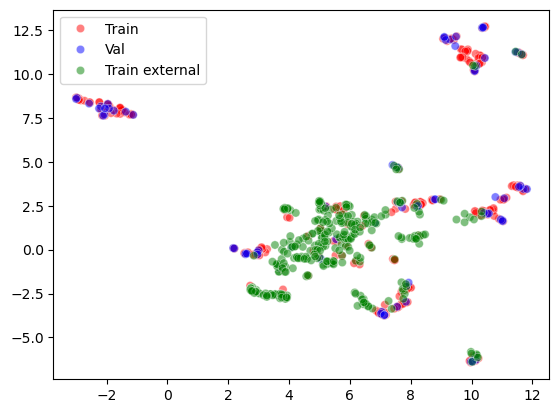

In [210]:
import umap
import seaborn as sns

all_ecfp = np.concatenate([train_ecfp, val_ecfp, train_ext_ecfp])
all_ecfp_umap = umap.UMAP(
    n_components=2, random_state=RANDOM_SEED, n_jobs=1, metric='jaccard'
).fit_transform(all_ecfp)
sns.scatterplot(
    x=all_ecfp_umap[:, 0], y=all_ecfp_umap[:, 1], 
    hue=['Train']*len(train_ecfp) + ['Val']*len(val_ecfp) + ['Train external']*len(train_ext_ecfp),
    palette={'Train': 'red', 'Val': 'blue', 'Train external': 'green'},
    alpha=0.5
);

In [211]:
def get_smiles_with_all_given_properties(data, properties):
    for i in range(data.shape[0]):
        query_smiles = data.iloc[i]['smiles_std']
        query_properties = data.iloc[i][properties]
        query_properties = {
            prop: random.uniform(query_properties[prop] - 0.05, query_properties[prop] + 0.05)
            for prop in properties if not np.isnan(query_properties[prop])
        }

        yield query_smiles, query_properties

In [220]:
def format_data(
    smiles: str,
    system_instruction: str | None = None,
    query_properties: dict[str, float] | None = None
):
    if system_instruction is not None:
        output = {
            "systemInstruction": {
            "parts": [
            {
                "text": system_instruction
            }
            ]
        }
    }
    else:
        output = {}
    
    output.update({
        "contents": [
            {
            "role": "user",
            "parts": [
                {
                    "text": f"{smiles}; " + ", ".join([
                        f"{prop_name}"
                        for prop_name in query_properties.keys()
                    ]) if query_properties is not None else f"{smiles}; " + ", ".join([
                        f"{prop_name}" for prop_name in PROPERTIES
                    ])
                }
            ]
            }
        ]
    })

    if query_properties is not None:
        output['contents'].append({
            "role": "model",
            "parts": [
                {
                    "text": ", ".join([
                        f"{prop_name}={prop_val:.2f}"
                        for prop_name, prop_val in query_properties.items()
                    ])
                }
            ]
        })
    
    return output

In [213]:
random.seed(RANDOM_SEED)
train_dataset = [
    format_data(
        smiles=smiles,
        query_properties=query_properties
    )
    for _ in range(10)
    for smiles, query_properties in get_smiles_with_all_given_properties(train, INTERNAL_PROPERTIES)
] + [
    format_data(
        smiles=smiles,
        query_properties=query_properties
    )
    for _ in range(10)
    for smiles, query_properties in get_smiles_with_all_given_properties(train_ext, EXTERNAL_PROPERTIES)
]

In [214]:
train_dataset[0]

{'contents': [{'role': 'user',
   'parts': [{'text': 'COc1cccc(Cl)c1NC(=O)N1CCC[C@H](C(N)=O)C1; LogD, LogMDR1-MDCKII'}]},
  {'role': 'model', 'parts': [{'text': 'LogD=0.31, LogMDR1-MDCKII=0.43'}]}]}

In [215]:
train_dataset[-1]

{'contents': [{'role': 'user',
   'parts': [{'text': 'Cc1noc(C2CCN(CCc3ccccc3)CC2)n1; LOG_HLM_CLint, LOG_RLM_CLint, LOG_MDR1-MDCK_ER, LOG_SOLUBILITY'}]},
  {'role': 'model',
   'parts': [{'text': 'LOG_HLM_CLint=1.26, LOG_RLM_CLint=2.64, LOG_MDR1-MDCK_ER=-0.33, LOG_SOLUBILITY=1.83'}]}]}

In [216]:
val_dataset = [
    format_data(
        smiles=smiles,
        query_properties=query_properties
    )
    for smiles, query_properties in get_smiles_with_all_given_properties(val, INTERNAL_PROPERTIES)
]

In [217]:
val_dataset[0]

{'contents': [{'role': 'user',
   'parts': [{'text': 'NC(=O)[C@H]1CCCN(C(=O)Cc2cccc3occc23)C1; LogD, LogKSOL, LogMDR1-MDCKII'}]},
  {'role': 'model',
   'parts': [{'text': 'LogD=1.02, LogKSOL=2.58, LogMDR1-MDCKII=0.96'}]}]}

In [34]:
train_data_dir = Path(f"../data/asap/datasets/rnd_splits/split_{SPLIT}")
train_data_dir.mkdir(parents=True, exist_ok=True)
train_data_path = train_data_dir / "gemini_train_smiles_all_prop_rnd_reg.jsonl"
train_gs_uri = f"<gs_bucket>/data/asap/datasets/rnd_splits/split_{SPLIT}/gemini_train_smiles_all_prop_rnd_reg.jsonl"

val_data_dir = Path(f"../data/asap/datasets/rnd_splits/split_{SPLIT}")
val_data_dir.mkdir(parents=True, exist_ok=True)
val_data_path = val_data_dir / "gemini_val_smiles_all_prop_rnd_reg.jsonl"
val_gs_uri = f"<gs_bucket>/data/asap/datasets/rnd_splits/split_{SPLIT}/gemini_val_smiles_all_prop_rnd_reg.jsonl"

save_and_upload_training_data(train_dataset, train_data_path, train_gs_uri)
save_and_upload_training_data(val_dataset, val_data_path, val_gs_uri)

In [35]:
start_finetuning_sft(
    train_dataset_gs_uri=train_gs_uri, val_dataset_gs_uri=val_gs_uri,
    source_model="gemini-1.5-flash-002", epochs=10,
    tuned_model_display_name=train_data_path.stem
)

Creating SupervisedTuningJob
SupervisedTuningJob created. Resource name: projects/199759238457/locations/us-central1/tuningJobs/1865604068190191616
To use this SupervisedTuningJob in another session:
tuning_job = sft.SupervisedTuningJob('projects/199759238457/locations/us-central1/tuningJobs/1865604068190191616')
View Tuning Job:
https://console.cloud.google.com/vertex-ai/generative/language/locations/us-central1/tuning/tuningJob/1865604068190191616?project=199759238457


In [218]:
TUNING_JOB_ID = "1865604068190191616"   # aMAE=0.6
sft_tuning_job = sft.SupervisedTuningJob(f"projects/{PROJECT_ID}/locations/{LOCATION}/tuningJobs/{TUNING_JOB_ID}")
tuned_model = GenerativeModel(
    sft_tuning_job.tuned_model_endpoint_name,
    generation_config=GenerationConfig(
        temperature=0.,
        seed=RANDOM_SEED
    )
)

In [221]:
val_dataset = [
    format_data(
        smiles=smiles,
        # query_properties=query_properties
    )
    for smiles, query_properties in get_smiles_with_all_given_properties(val, INTERNAL_PROPERTIES)
]

In [222]:
for content in val_dataset:
    result = tuned_model.generate_content(content['contents'])
    print(result)
    break

candidates {
  content {
    role: "model"
    parts {
      text: "LogHLM=1.66, LogMLM=1.90, LogD=2.66, LogKSOL=2.56, LogMDR1-MDCKII=0.36\n\n"
    }
  }
  finish_reason: STOP
  avg_logprobs: -0.46590904394785565
}
usage_metadata {
  prompt_token_count: 50
  candidates_token_count: 48
  total_token_count: 98
  prompt_tokens_details {
    modality: TEXT
    token_count: 50
  }
  candidates_tokens_details {
    modality: TEXT
    token_count: 48
  }
}
create_time {
  seconds: 1741935494
  nanos: 284118000
}
response_id: "htPTZ9arEa75ld8P7r3PgQY"



In [223]:
predictions = list(tqdm(map(partial(get_answer, tuned_model), val_dataset), total=len(val_dataset)))
predictions = pd.DataFrame(predictions).rename(columns={prop: f'pred_{prop}' for prop in PROPERTIES})
val_ = pd.concat([val, predictions], axis=1)
val_preds = extract_preds(val_)
val_refs = extract_refs(val_)
metrics = eval_admet(val_preds, val_refs, target_columns=TARGET_COLUMNS)
print(json.dumps(metrics, indent=2))

100%|██████████| 81/81 [01:26<00:00,  1.07s/it]

{
  "HLM": {
    "mean_absolute_error": 0.5153856375862446,
    "r2": -0.010605497793306773
  },
  "MLM": {
    "mean_absolute_error": 0.5602609082071518,
    "r2": 0.02453203201131504
  },
  "LogD": {
    "mean_absolute_error": 1.1401515151515151,
    "r2": -0.2754341973547272
  },
  "KSOL": {
    "mean_absolute_error": 0.49391012721445354,
    "r2": -0.5786010984882888
  },
  "MDR1-MDCKII": {
    "mean_absolute_error": 0.31900404006125666,
    "r2": -0.37131485243834295
  },
  "aggregated": {
    "macro_mean_absolute_error": 0.6057424456441244,
    "macro_r2": -0.24228472281267016
  }
}


## Hypothesis 13 - top-k closest molecules from train with given properties (for all properties) + external data + regularization + MACCS similarity + RDKit

In [10]:
SPLIT = 2
TOPK_TARGET_DATA = 3
TOPK_EXTERNAL_DATA = 1
INTERNAL_PROPERTIES = PROPERTIES
EXTERNAL_PROPERTIES = ['LOG_HLM_CLint', 'LOG_RLM_CLint', 'LOG_MDR1-MDCK_ER', 'LOG_HPPB', 'LOG_RPPB', 'LOG_SOLUBILITY']

In [11]:
data = pd.read_csv(f'../data/asap/datasets/rnd_splits/split_{SPLIT}.csv')
external_data = pd.read_csv('../data/asap/preproc/biogen-adme-fang-v1-std.tsv', sep='\t')
external_data

,UNIQUE_ID,MOL_smiles,SMILES,LOG_HLM_CLint,LOG_RLM_CLint,LOG_MDR1-MDCK_ER,LOG_HPPB,LOG_RPPB,LOG_SOLUBILITY,smiles_std
0,b5e1231aef0080c76b4207ca1355485432877339,Brc1cc2c(cc1Cn1cncn1)OCCCO2,Brc1cc2c(cc1Cn1cncn1)OCCCO2,0.886265,2.357933,-0.247518,NaN,NaN,1.536432,Brc1cc2c(cc1Cn1cncn1)OCCCO2
1,0604cf74e44450d5963d169e18854d96c4e5dba8,Brc1ccc(-c2nnc(Cn3cnc4ccccc43)o2)o1,Brc1ccc(-c2nnc(Cn3cnc4ccccc43)o2)o1,0.675687,1.613704,-0.010669,NaN,NaN,1.797475,Brc1ccc(-c2nnc(Cn3cnc4ccccc43)o2)o1
2,c518badac8533fdb0de4679c17ce4035eab9ac28,Brc1cnc(N2CCCN(c3ccccc3)CC2)nc1,Brc1cnc(N2CCCN(c3ccccc3)CC2)nc1,2.081607,3.753651,NaN,NaN,NaN,NaN,Brc1cnc(N2CCCN(c3ccccc3)CC2)nc1
3,9be43035e7b8a5078babf4345584f4dc6dcd1448,Brc1cnc2ccccc2c1,Brc1cnc2ccccc2c1,NaN,NaN,NaN,NaN,NaN,-0.033858,Brc1cnc2ccccc2c1
4,57b907f2f455c3ce3ba21114f32f93b301c99a34,Brc1nnc(N2CCC(OC3CCCC3)CC2)s1,Brc1nnc(N2CCC(OC3CCCC3)CC2)s1,1.888410,3.492201,-0.235024,NaN,NaN,NaN,Brc1nnc(N2CCC(OC3CCCC3)CC2)s1
...,...,...,...,...,...,...,...,...,...,...
3512,6170f36d417c6cebd1a98e82f03005da39ccc983,c1nc(N2CCC3(CCCCC3)C2)c2cn[nH]c2n1,c1nc(N2CCC3(CCCCC3)C2)c2cn[nH]c2n1,0.920801,2.851225,-0.096904,NaN,NaN,NaN,c1nc(N2CCC3(CCCCC3)C2)c2cn[nH]c2n1
3513,644313d1941ab4550760b7c1162c54d209a7435f,c1nc(NC2CCN(C3CC3)CC2)c2sccc2n1,c1nc(NC2CCN(C3CC3)CC2)c2sccc2n1,1.240899,1.906157,0.094514,NaN,NaN,1.749891,c1nc(NC2CCN(C3CC3)CC2)c2sccc2n1
3514,32658afab9952faf20249dbb305e1ac85ef10a1b,c1nc(Nc2ccc3c(c2)OCCCO3)c2sccc2n1,c1nc(Nc2ccc3c(c2)OCCCO3)c2sccc2n1,1.964066,3.196559,NaN,NaN,NaN,1.707229,c1nc(Nc2ccc3c(c2)OCCCO3)c2sccc2n1
3515,de4a8fd15738b6f012f58b93bb6784afc82f9742,c1nn(C2CCOCC2)cc1Nc1ncc2nnn(-c3ccc4cn[nH]c4c3)...,c1nn(C2CCOCC2)cc1Nc1ncc2nnn(-c3ccc4cn[nH]c4c3)...,1.985754,2.883853,2.725057,NaN,NaN,NaN,c1nn(C2CCOCC2)cc1Nc1ncc2nnn(-c3ccc4cn[nH]c4c3)...


In [12]:
def maccs_similarity_matrix(queries, references):
    query_fps = [MACCSkeys.GenMACCSKeys(Chem.MolFromSmiles(s)) for s in queries]
    ref_fps = [MACCSkeys.GenMACCSKeys(Chem.MolFromSmiles(s)) for s in references]

    dist_mat = np.array([
        DataStructs.BulkTanimotoSimilarity(query_fp, ref_fps)
        for query_fp in query_fps
    ])
    
    return dist_mat

In [13]:
train = data[data['split'] == 'train'].reset_index(drop=True)
ref_data = pd.concat([train, external_data]).reset_index(drop=True)
val = data[data['split'] == 'val'].reset_index(drop=True)
train2ref_dist = maccs_similarity_matrix(train['smiles_std'], ref_data['smiles_std'])
val2ref_dist = maccs_similarity_matrix(val['smiles_std'], ref_data['smiles_std'])
train2ref_dist.shape, val2ref_dist.shape

((323, 3840), (81, 3840))

In [14]:
ref_data

,smiles,HLM,KSOL,LogD,MLM,MDR1-MDCKII,smiles_std,cxsmiles_std,mol_idx,smiles_ext,...,split,UNIQUE_ID,MOL_smiles,SMILES,LOG_HLM_CLint,LOG_RLM_CLint,LOG_MDR1-MDCK_ER,LOG_HPPB,LOG_RPPB,LOG_SOLUBILITY
0,COC1=CC=CC(Cl)=C1NC(=O)N1CCC[C@H](C(N)=O)C1 |a...,NaN,NaN,0.3,NaN,2.0,COc1cccc(Cl)c1NC(=O)N1CCC[C@H](C(N)=O)C1,COc1cccc(Cl)c1NC(=O)N1CCC[C@H](C(N)=O)C1 |a:16|,191.0,|a:16|,...,train,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,O=C(NCC(F)F)[C@H](NC1=CC2=C(C=C1Br)CNC2)C1=CC(...,NaN,333.0,2.9,NaN,0.2,O=C(NCC(F)F)[C@H](Nc1cc2c(cc1Br)CNC2)c1cc(Cl)c...,O=C(NCC(F)F)[C@H](Nc1cc2c(cc1Br)CNC2)c1cc(Cl)c...,335.0,|&1:7|,...,train,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NC(=O)[C@H]1CCCN(C(=O)CC2=CC=CC3=C2C=CO3)C1 |&...,NaN,376.0,1.0,NaN,8.5,NC(=O)[C@H]1CCCN(C(=O)Cc2cccc3occc23)C1,NC(=O)[C@H]1CCCN(C(=O)Cc2cccc3occc23)C1 |&1:3|,300.0,|&1:3|,...,train,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,CC1=CC(CC(=O)N2CCC[C@H](C(N)=O)C2)=CC=N1 |&1:11|,NaN,375.0,-0.3,NaN,0.9,Cc1cc(CC(=O)N2CCC[C@H](C(N)=O)C2)ccn1,Cc1cc(CC(=O)N2CCC[C@H](C(N)=O)C2)ccn1 |&1:11|,249.0,|&1:11|,...,train,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,O=C(NCC(F)F)[C@H](NC1=CN=C2CNCC2=C1)C1=CC(Cl)=...,NaN,362.0,1.5,NaN,0.8,O=C(NCC(F)F)[C@H](Nc1cnc2c(c1)CNC2)c1cc(Cl)cc(...,O=C(NCC(F)F)[C@H](Nc1cnc2c(c1)CNC2)c1cc(Cl)cc(...,341.0,|&1:7|,...,train,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3835,NaN,NaN,NaN,NaN,NaN,NaN,c1nc(N2CCC3(CCCCC3)C2)c2cn[nH]c2n1,NaN,NaN,NaN,...,NaN,6170f36d417c6cebd1a98e82f03005da39ccc983,c1nc(N2CCC3(CCCCC3)C2)c2cn[nH]c2n1,c1nc(N2CCC3(CCCCC3)C2)c2cn[nH]c2n1,0.920801,2.851225,-0.096904,NaN,NaN,NaN
3836,NaN,NaN,NaN,NaN,NaN,NaN,c1nc(NC2CCN(C3CC3)CC2)c2sccc2n1,NaN,NaN,NaN,...,NaN,644313d1941ab4550760b7c1162c54d209a7435f,c1nc(NC2CCN(C3CC3)CC2)c2sccc2n1,c1nc(NC2CCN(C3CC3)CC2)c2sccc2n1,1.240899,1.906157,0.094514,NaN,NaN,1.749891
3837,NaN,NaN,NaN,NaN,NaN,NaN,c1nc(Nc2ccc3c(c2)OCCCO3)c2sccc2n1,NaN,NaN,NaN,...,NaN,32658afab9952faf20249dbb305e1ac85ef10a1b,c1nc(Nc2ccc3c(c2)OCCCO3)c2sccc2n1,c1nc(Nc2ccc3c(c2)OCCCO3)c2sccc2n1,1.964066,3.196559,NaN,NaN,NaN,1.707229
3838,NaN,NaN,NaN,NaN,NaN,NaN,c1nn(C2CCOCC2)cc1Nc1ncc2nnn(-c3ccc4cn[nH]c4c3)...,NaN,NaN,NaN,...,NaN,de4a8fd15738b6f012f58b93bb6784afc82f9742,c1nn(C2CCOCC2)cc1Nc1ncc2nnn(-c3ccc4cn[nH]c4c3)...,c1nn(C2CCOCC2)cc1Nc1ncc2nnn(-c3ccc4cn[nH]c4c3)...,1.985754,2.883853,2.725057,NaN,NaN,NaN


In [15]:
def extract_properties_v3(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return ""
    
    properties = {}

    # --- Basic RDKit Descriptors ---
    properties["MW"] = Descriptors.MolWt(mol)
    properties["RotB"] = Descriptors.NumRotatableBonds(mol)
    properties["TPSA"] = rdMolDescriptors.CalcTPSA(mol)
    properties["HBD"] = Descriptors.NumHDonors(mol)
    properties["HBA"] = Descriptors.NumHAcceptors(mol)
    properties["LogP"] = Descriptors.MolLogP(mol)
    
    # --- Ring Counts ---
    properties["aroma"] = rdMolDescriptors.CalcNumAromaticRings(mol)
    properties["alipha"] = rdMolDescriptors.CalcNumAliphaticRings(mol)

    properties = ", ".join([
        f"{prop_name}={int(prop_val)}" if prop_name != "LogP" else f"{prop_name}={prop_val:.2f}"
        for prop_name, prop_val in properties.items()
    ])

    return properties

In [16]:
def get_all_topk_smiles_with_properties(
        ref_data, query_data, query2ref_dist,
        topk_target=TOPK_TARGET_DATA, topk_external=TOPK_EXTERNAL_DATA, randomize=False, is_test=False
    ):
    for i in range(query2ref_dist.shape[0]):
        query_smiles = query_data.iloc[i]['smiles_std']
        query_properties = {}
        topk_smiles2properties = defaultdict(dict)
        topk_smiles2rdkit = defaultdict(str)
        topk_smiles2dist = defaultdict(float)
        for property in INTERNAL_PROPERTIES + EXTERNAL_PROPERTIES:
            if property in INTERNAL_PROPERTIES:
                topk = topk_target
            else:
                topk = topk_external
            
            if property in INTERNAL_PROPERTIES:
                query_property = query_data.iloc[i][property]
                if not np.isnan(query_property):
                    if randomize:
                        query_property = query_property + random.gauss(0., 0.02)
                    query_properties[property] = query_property

            ref_data_with_property = ref_data[ref_data[property].notna()]
            dist = query2ref_dist[i, ref_data_with_property.index]
            order = np.argsort(dist)[::-1]
            ordered_dist = dist[order]
            if not is_test:
                order = order[~np.isclose(ordered_dist, 1.0)]   # remove self-similarity including duplicates
            topk_idx = order[:topk]
            topk_dist = dist[topk_idx]
            topk_smiles = ref_data_with_property.iloc[topk_idx]['smiles_std'].tolist()
            topk_properties = ref_data_with_property.iloc[topk_idx][property].tolist()

            for smi, prop in zip(topk_smiles, topk_properties):
                if randomize:
                    prop = prop + random.gauss(0., 0.02)
                topk_smiles2properties[smi][property] = prop

            for smi, dist_ in zip(topk_smiles, topk_dist):
                topk_smiles2rdkit[smi] = extract_properties_v3(smi)
                topk_smiles2dist[smi] = dist_
            
        query_rdkit = extract_properties_v3(query_smiles)
        
        yield topk_smiles2properties, topk_smiles2rdkit, topk_smiles2dist, query_smiles, query_rdkit, query_properties

In [17]:
def format_data(
    topk_smiles2properties: dict[str, dict[str, float]],
    topk_smiles2rdkit: dict[str, str],
    topk_smiles2dist: dict[str, float],
    query_smiles: str,
    query_rdkit: str,
    query_properties: dict[str, float] | None = None,
    system_instruction: str | None = None
):
    if system_instruction is not None:
        output = {
            "systemInstruction": {
            "parts": [
            {
                "text": system_instruction
            }
            ]
        }
    }
    else:
        output = {}

    parts = [
        {
            "text": "; ".join([
                f"SMILES: {smi}, " + \
                f"{topk_smiles2rdkit[smi]}, " + \
                f"Similarity: {topk_smiles2dist[smi]:.2f}, " + \
                ", ".join([
                    f"{prop_name}={prop_val:.2f}"
                    for prop_name, prop_val in prop_name2prop_val.items()
                ])
                for smi, prop_name2prop_val in topk_smiles2properties.items()
            ])
        }
    ]
    if query_properties is not None:
        parts.append({
            "text": f"SMILES: {query_smiles}, {query_rdkit}; " + "Determine " + ", ".join([
                f"{prop_name}" for prop_name in query_properties.keys()
            ])
        })
    else:
        parts.append({
            "text": f"SMILES: {query_smiles}, {query_rdkit}; " + "Determine " +", ".join([
                f"{prop_name}" for prop_name in PROPERTIES
            ])
        })
    
    output.update({
        "contents": [
            {
            "role": "user",
            "parts": parts
            }
        ]
    })

    if query_properties is not None:
        output['contents'].append({
            "role": "model",
            "parts": [
                {
                    "text": ", ".join([
                        f"{prop_name}={prop_val:.2f}"
                        for prop_name, prop_val in query_properties.items()
                    ])
                }
            ]
        })
    
    return output

In [20]:
system_instruction = """
You are an experienced medicinal chemist who worked many years determining ADME properties of drug-like molecules. You can determine properties based on molecular structure and properties of similar molecules from a reference set.

You are given a list of reference molecules represented in SMILES paired with their property values. Here is the list of properties that you may or may not be given as input:
Target dataset from one wetlab:
- LogHLM (uL/min/mg), human microsomal stability
- LogMLM (uL/min/mg), rat microsomal stability
- LogKSOL (uM), KSOL assay readouts for solubility at pH 7.4
- LogD, LogD calculation for solubility at pH 7.4
- LogMDR1-MDCKII (10^-6 cm/s), MDR1-MDCKII assay readouts for permeability

External dataset from another wetlab:
- LOG_HLM_CLint (mL/min/kg), human microsomal stability
- LOG_RLM_CLint (mL/min/kg), rat microsomal stability
- LOG_HPPB (% unbound), human plasma protein binding
- LOG_RPPB (% unbound), rat plasma protein binding
- LOG_MDR1-MDCK_ER (B-A/A-B), permeability
- LOG_SOLUBILITY, solubility at pH 6.8

Some values might be incorrect due to assay errors. Your task is to determine the requested properties of the molecule represented in SMILES. Answer only with a single floating point number per property."
"""

In [22]:
random.seed(RANDOM_SEED)
train_dataset = [
    format_data(
        topk_smiles2properties=topk_smiles2properties,
        topk_smiles2rdkit=topk_smiles2rdkit,
        topk_smiles2dist=topk_smiles2dist,
        query_smiles=query_smiles,
        query_rdkit=query_rdkit,
        query_properties=query_properties,
        system_instruction=system_instruction
    )
    for _ in range(10)
    for topk_smiles2properties, topk_smiles2rdkit, topk_smiles2dist, query_smiles, query_rdkit, query_properties in 
        get_all_topk_smiles_with_properties(
        ref_data=ref_data,
        query_data=train,
        query2ref_dist=train2ref_dist,
        topk_target=TOPK_TARGET_DATA,
        topk_external=TOPK_EXTERNAL_DATA,
        randomize=True
    )
]

In [23]:
train_dataset[0]

{'systemInstruction': {'parts': [{'text': '\nYou are an experienced medicinal chemist who worked many years determining ADME properties of drug-like molecules. You can determine properties based on molecular structure and properties of similar molecules from a reference set.\n\nYou are given a list of reference molecules represented in SMILES paired with their property values. Here is the list of properties that you may or may not be given as input:\nTarget dataset from one wetlab:\n- LogHLM (uL/min/mg), human microsomal stability\n- LogMLM (uL/min/mg), rat microsomal stability\n- LogKSOL (uM), KSOL assay readouts for solubility at pH 7.4\n- LogD, LogD calculation for solubility at pH 7.4\n- LogMDR1-MDCKII (10^-6 cm/s), MDR1-MDCKII assay readouts for permeability\n\nExternal dataset from another wetlab:\n- LOG_HLM_CLint (mL/min/kg), human microsomal stability\n- LOG_RLM_CLint (mL/min/kg), rat microsomal stability\n- LOG_HPPB (% unbound), human plasma protein binding\n- LOG_RPPB (% unbo

In [24]:
val_dataset = [
    format_data(
        topk_smiles2properties=topk_smiles2properties,
        topk_smiles2rdkit=topk_smiles2rdkit,
        topk_smiles2dist=topk_smiles2dist,
        query_smiles=query_smiles,
        query_rdkit=query_rdkit,
        query_properties=query_properties,
        system_instruction=system_instruction
    )
    for topk_smiles2properties, topk_smiles2rdkit, topk_smiles2dist, query_smiles, query_rdkit, query_properties in 
        get_all_topk_smiles_with_properties(
        ref_data=ref_data,
        query_data=val,
        query2ref_dist=val2ref_dist,
        topk_target=TOPK_TARGET_DATA,
        topk_external=TOPK_EXTERNAL_DATA
    )
]

In [25]:
val_dataset[0]

{'systemInstruction': {'parts': [{'text': '\nYou are an experienced medicinal chemist who worked many years determining ADME properties of drug-like molecules. You can determine properties based on molecular structure and properties of similar molecules from a reference set.\n\nYou are given a list of reference molecules represented in SMILES paired with their property values. Here is the list of properties that you may or may not be given as input:\nTarget dataset from one wetlab:\n- LogHLM (uL/min/mg), human microsomal stability\n- LogMLM (uL/min/mg), rat microsomal stability\n- LogKSOL (uM), KSOL assay readouts for solubility at pH 7.4\n- LogD, LogD calculation for solubility at pH 7.4\n- LogMDR1-MDCKII (10^-6 cm/s), MDR1-MDCKII assay readouts for permeability\n\nExternal dataset from another wetlab:\n- LOG_HLM_CLint (mL/min/kg), human microsomal stability\n- LOG_RLM_CLint (mL/min/kg), rat microsomal stability\n- LOG_HPPB (% unbound), human plasma protein binding\n- LOG_RPPB (% unbo

In [26]:
data_dir = Path(f"../data/asap/datasets/rnd_splits/split_{SPLIT}/")
data_dir.mkdir(parents=True, exist_ok=True)
train_data_path = data_dir / f"gemini_all_prop_rnd_reg_maccs_rdkit_split_{SPLIT}_top{TOPK_TARGET_DATA}target_{TOPK_EXTERNAL_DATA}ext_train.jsonl"
val_data_path = data_dir / f"gemini_all_prop_rnd_reg_maccs_rdkit_split_{SPLIT}_top{TOPK_TARGET_DATA}target_{TOPK_EXTERNAL_DATA}ext_val.jsonl"
train_gs_uri = f"<gs_bucket>/data/asap/datasets/rnd_splits/split_{SPLIT}/gemini_all_prop_rnd_reg_maccs_rdkit_split_top{TOPK_TARGET_DATA}target_{TOPK_EXTERNAL_DATA}ext_train.jsonl"
val_gs_uri = f"<gs_bucket>/data/asap/datasets/rnd_splits/split_{SPLIT}/gemini_all_prop_rnd_reg_maccs_rdkit_split_top{TOPK_TARGET_DATA}target_{TOPK_EXTERNAL_DATA}ext_val.jsonl"

save_and_upload_training_data(train_dataset, train_data_path, train_gs_uri)
save_and_upload_training_data(val_dataset, val_data_path, val_gs_uri)

In [28]:
start_finetuning_sft(
    train_dataset_gs_uri=train_gs_uri, val_dataset_gs_uri=val_gs_uri,
    source_model="gemini-2.0-flash-001", epochs=2,
    tuned_model_display_name=train_data_path.stem
)

Creating SupervisedTuningJob
SupervisedTuningJob created. Resource name: projects/199759238457/locations/us-central1/tuningJobs/5008665808327409664
To use this SupervisedTuningJob in another session:
tuning_job = sft.SupervisedTuningJob('projects/199759238457/locations/us-central1/tuningJobs/5008665808327409664')
View Tuning Job:
https://console.cloud.google.com/vertex-ai/generative/language/locations/us-central1/tuning/tuningJob/5008665808327409664?project=199759238457


In [50]:
TUNING_JOB_ID = "5008665808327409664"  # split 2, gemini-2.0-flash-001, 2 epochs, system instruction, int top=3, ext top=1, aMAE=, aMAE=0.37 (8 candidates), aMAE=0.40 (1 int, 0 ext, 8 candidates), aMAE=0.37 (3 int, 0 ext, 8 candidates)
# TUNING_JOB_ID = "2073884555839799296"  # split 2, gemini-1.5-flash-002, 2 epochs, int top=3, ext top=1, aMAE=, aMAE=0.38 (8 candidates)
# TUNING_JOB_ID = "6146038019494248448"  # split 4, gemini-1.5-flash-002, 2 epochs, aMAE=, aMAE=0.30 (8 candidates)
# TUNING_JOB_ID = "3188580439195385856"  # split 3, gemini-2.0-flash-001, 2 epochs, aMAE=, aMAE=0.32 (8 candidates)
# TUNING_JOB_ID = "8613113413805015040"  # split 3, gemini-1.5-flash-002, 2 epochs, aMAE=, aMAE=0.326 (8 candidates)
# TUNING_JOB_ID = "8276856369752047616"  # split 0, gemini-1.5-flash-002, 2 epochs, aMAE=0.348, aMAE=0.339 (8 candidates), aMAE=0.349 (8 candidate, no ext on inference), aMAE=0.32 (3 int, 3 ext or 3 int, 0 ext)
# TUNING_JOB_ID = "1218871328732348416"  # split 2, gemini-1.5-flash-002, 3 epochs, aMAE=0.39, aMAE=0.37 (8 candidates), aMAE=0.348 (8 candidate, no ext on inference), aMAE=0.38 (8 candidate, 3 int, 3 ext or 3 int, 0 ext)
sft_tuning_job = sft.SupervisedTuningJob(f"projects/{PROJECT_ID}/locations/{LOCATION}/tuningJobs/{TUNING_JOB_ID}")
tuned_model = GenerativeModel(
    sft_tuning_job.tuned_model_endpoint_name,
    generation_config=GenerationConfig(
        # temperature=0.,
        temperature=0.5,
        candidate_count=8,
        seed=RANDOM_SEED
    ),
    system_instruction=system_instruction
)

In [51]:
val_dataset = [
    format_data(
        topk_smiles2properties=topk_smiles2properties,
        topk_smiles2rdkit=topk_smiles2rdkit,
        topk_smiles2dist=topk_smiles2dist,
        query_smiles=query_smiles,
        query_rdkit=query_rdkit,
        # query_properties=query_properties,
        # system_instruction=system_instruction
    )
    for topk_smiles2properties, topk_smiles2rdkit, topk_smiles2dist, query_smiles, query_rdkit, query_properties in 
        get_all_topk_smiles_with_properties(
        ref_data=ref_data,
        query_data=val,
        query2ref_dist=val2ref_dist,
        topk_target=TOPK_TARGET_DATA,
        topk_external=TOPK_EXTERNAL_DATA
    )
]

In [52]:
val_dataset[0]

{'contents': [{'role': 'user',
   'parts': [{'text': 'SMILES: CC(C)NC(=O)[C@H](Nc1ccc2c(c1)CNC2)c1cc(Cl)cc2[nH]c(-c3ccccc3)nc12, MW=459, RotB=6, TPSA=81, HBD=4, HBA=4, LogP=5.16, aroma=4, alipha=1, Similarity: 0.81, LogHLM=1.38; SMILES: O=C(Nc1cc(Br)c2c(c1)CNC2)c1cc(F)cc2[nH]ncc12, MW=375, RotB=2, TPSA=69, HBD=3, HBA=3, LogP=3.32, aroma=3, alipha=1, Similarity: 0.80, LogHLM=1.16; SMILES: O=C(Nc1ccc2c(c1)CNC2)c1cc(F)cc(-c2cn[nH]c2)c1, MW=322, RotB=3, TPSA=69, HBD=3, HBA=3, LogP=3.07, aroma=3, alipha=1, Similarity: 0.76, LogHLM=1.57; SMILES: O=C(Nc1ccc2c(c1)CNC2)c1cc(F)cc2[nH]c(-c3ccc(F)cc3)nc12, MW=390, RotB=3, TPSA=69, HBD=3, HBA=3, LogP=4.36, aroma=4, alipha=1, Similarity: 0.84, LogMLM=1.58, LogD=2.90, LogKSOL=0.85, LogMDR1-MDCKII=0.04; SMILES: O=C(Nc1ccc2c(c1)CNC2)c1cc(Br)cc2[nH]ccc12, MW=356, RotB=2, TPSA=56, HBD=3, HBA=2, LogP=3.79, aroma=3, alipha=1, Similarity: 0.83, LogMLM=1.55, LogMDR1-MDCKII=0.69; SMILES: N#Cc1cccc(-c2nc3c(C(=O)Nc4ccc5c(c4)CNC5)cc(F)cc3[nH]2)c1, MW=397, RotB=3

In [53]:
for content in val_dataset:
    result = tuned_model.generate_content(content['contents'])
    print(result)
    break

candidates {
  content {
    role: "model"
    parts {
      text: "LogHLM=1.40, LogMLM=1.06, LogD=0.80, LogKSOL=2.58, LogMDR1-MDCKII=0.25"
    }
  }
  finish_reason: STOP
  avg_logprobs: -0.43191426865597987
}
candidates {
  index: 1
  content {
    role: "model"
    parts {
      text: "LogHLM=1.16, LogMLM=1.12, LogD=0.71, LogKSOL=2.49, LogMDR1-MDCKII=0.11"
    }
  }
  finish_reason: STOP
  avg_logprobs: -0.44043898075184923
}
candidates {
  index: 2
  content {
    role: "model"
    parts {
      text: "LogHLM=1.22, LogMLM=1.36, LogD=0.23, LogKSOL=2.59, LogMDR1-MDCKII=0.23"
    }
  }
  finish_reason: STOP
  avg_logprobs: -0.46329133054043387
}
candidates {
  index: 3
  content {
    role: "model"
    parts {
      text: "LogHLM=1.20, LogMLM=1.16, LogD=0.62, LogKSOL=2.56, LogMDR1-MDCKII=0.38"
    }
  }
  finish_reason: STOP
  avg_logprobs: -0.43405394858502327
}
candidates {
  index: 4
  content {
    role: "model"
    parts {
      text: "LogHLM=1.22, LogMLM=1.30, LogD=0.72, LogKSOL

In [54]:
predictions = list(tqdm(map(partial(get_answer, tuned_model), val_dataset), total=len(val_dataset)))
predictions = pd.DataFrame(predictions).rename(columns={prop: f'pred_{prop}' for prop in PROPERTIES})
val_ = pd.concat([val, predictions], axis=1)
val_preds = extract_preds(val_)
val_refs = extract_refs(val_)
metrics = eval_admet(val_preds, val_refs, target_columns=TARGET_COLUMNS)
print(json.dumps(metrics, indent=2))

100%|██████████| 81/81 [00:53<00:00,  1.50it/s]

{
  "HLM": {
    "mean_absolute_error": 0.3389030047981523,
    "r2": 0.28007079805886936
  },
  "MLM": {
    "mean_absolute_error": 0.4347556085329456,
    "r2": 0.1252040092690473
  },
  "LogD": {
    "mean_absolute_error": 0.525435606060606,
    "r2": 0.7207640630297285
  },
  "KSOL": {
    "mean_absolute_error": 0.3418590431864945,
    "r2": 0.47402779856434074
  },
  "MDR1-MDCKII": {
    "mean_absolute_error": 0.22375602788574142,
    "r2": 0.40262352563851633
  },
  "aggregated": {
    "macro_mean_absolute_error": 0.37294185809278796,
    "macro_r2": 0.40053803891210044
  }
}


In [55]:
for target in TARGET_COLUMNS:
    if target == 'LogD':
        continue
    val_[f'pred_{target}'] = np.power(10, val_[f'pred_Log{target}']) - 1.

In [58]:
from matplotlib import pyplot as plt
import seaborn as sns

def plot_distributions(data, columns):
    fig, ax = plt.subplots(1, 5, figsize=(15, 3))
    for i, col in enumerate(columns):
        sns.histplot(data[col], ax=ax[i])
        ax[i].set_title(col)
    plt.tight_layout()
    plt.show()

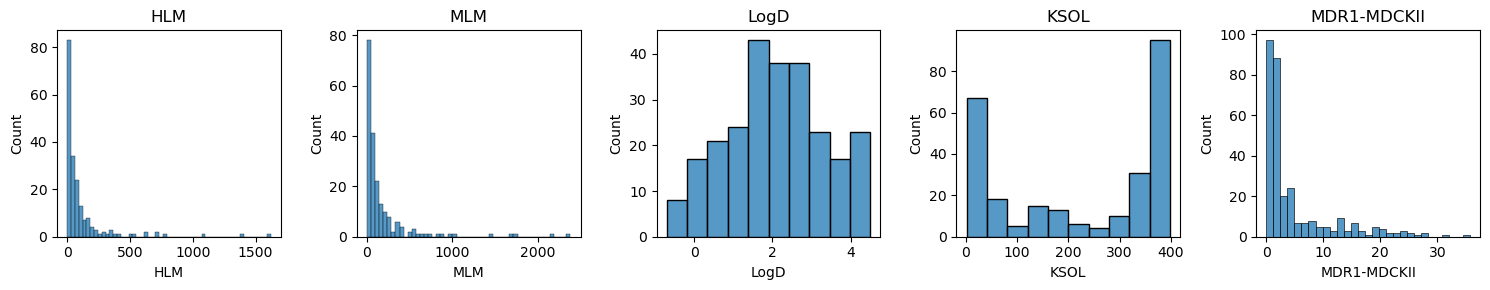

In [59]:
plot_distributions(train, ['HLM', 'MLM', 'LogD', 'KSOL', 'MDR1-MDCKII'])

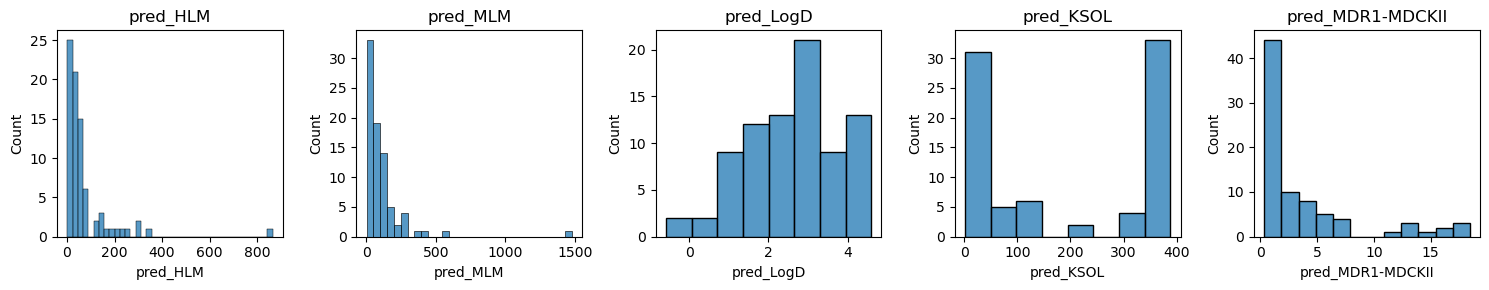

In [60]:
plot_distributions(val_, ['pred_HLM', 'pred_MLM', 'pred_LogD', 'pred_KSOL', 'pred_MDR1-MDCKII'])

Final results after training and validation on all five splits. The generation completion was performed with temperature 0.5 and 8 candidate generations averaging. Top-k=5 for internal and top-k=3 for external data. No system instruction. Here are the results comparing Gemini 1.5 Flash and the best among other baseline methods, Chemprop:

| Gemini 1.5 Flash | Split | HLM (MAE) | MLM (MAE) | LogD (MAE) | KSOL (MAE) | MDR1-MDCKII (MAE) | Agg MAE | Agg MAE (overall) |
| :---- | :---- | :---- | :---- | :---- | :---- | :---- | :---- | :---- |
|  | 0 | **0.300** | 0.366 | 0.470 | **0.338** | **0.228** | **0.341** | **0.340** |
|  | 1 | **0.319** | **0.346** | 0.604 | **0.332** | **0.197** | **0.360** |  |
|  | 2 | 0.391 | 0.431 | 0.510 | **0.326** | **0.189** | 0.370 |  |
|  | 3 | 0.368 | 0.359 | 0.471 | **0.230** | **0.191** | 0.324 |  |
|  | 4 | 0.290 | **0.333** | 0.522 | **0.216** | 0.174 | 0.307 |  |
| Chemprop | 0 | 0.354 | **0.345** | **0.451** | 0.386 | 0.253 | 0.358 | **0.343** |
|  | 1 | 0.364 | 0.442 | **0.505** | 0.354 | 0.229 | 0.379 |  |
|  | 2 | **0.315** | **0.403** | **0.474** | 0.399 | 0.190 | **0.356** |  |
|  | 3 | **0.332** | **0.355** | **0.465** | 0.261 | 0.197 | **0.322** |  |
|  | 4 | **0.269** | 0.334 | **0.425** | 0.305 | **0.166** | **0.300** |  |